In [35]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
from astropy.io import ascii
from matplotlib.patches import Rectangle

import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
from astropy.io import ascii

from matplotlib.patches import Rectangle
from astropy.coordinates import Angle, SkyCoord
from regions import CircleSkyRegion, PixCoord, CirclePixelRegion
import astropy.units as u
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.table import Table
from matplotlib.patches import Ellipse
from regions import EllipseSkyRegion

#panstarrs redshift catalogue

from __future__ import print_function
#import mastcasjobs
from astropy.io import ascii
from astropy.table import Table
from astropy import coordinates, units
import numpy as np
import os
import re
import getpass
import requests 
from urllib.parse import quote as urlencode 
from urllib.request import urlretrieve 
import http.client as httplib
     
from astropy.io import ascii 
from astropy.table import Table 
from astropy import coordinates, units

from astropy.wcs import WCS
#from regions import PixCoord, PolygonPixelRegion
from astropy.visualization import ZScaleInterval
from astropy.cosmology import Planck18 as cosmo

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [2]:
#nu = np.arange(1, 100, dtype=float)
#print (nu)
nu = []
for i in range(1, 100):
    nu.append(i)
print("nu = %s" % nu)

nu = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


In [2]:
def F_nu(t_p,nu_p,F_nup,nu_sed):
    '''Calculates a Synchrotron Self-Absorbed Spectrum for given input parameters.
     axs
    Parameters:
    t_p (days): Time of SSA peak - should be single number
    nu_p (GHz): Frequency of SSA peak - should be single number
    F_nup (mJy): Flux of SSA peak - should be single number
    nu (GHz): Frequencies at which you want the SSA spectrum to be calculated at. Likely an array.
    
    Outputs:
    Fnu (mJy): the flux of the SSA. This is an array with values associated with each value of input array nu.
    '''
    
    m = 0.88 #using stAandard model m = (n-3)/(n-2)
    p = 3.0 #using standard model
    a = (2*m)+0.5
    b = (p+5-(6*m))/2
    t=t_p
    Fnu = F_nup*1.582*(t/t_p)**a*(nu_sed/nu_p)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu_sed/nu_p)**(-(p+4)/2)))
    
    return Fnu


def SSA_props(t_p,nu_p,F_nup,D_L,f=0.5,alpha=1,vw=100,epsilon_b=0.1):
    '''Calculates Synchroton Self-Absorption properties for given input parameters.
    
    Inputs:
    t_p (days): Time of SSA peak - likely a single number
    nu_p (GHz): Frequency of SSA peak - likely a single number
    F_nup (mJy): Flux of SSA peak - likely a single number
    D (Mpc): distance to SN - likely a single number,while D_L is the luminosity distance
    f (unitless): filling factor (fraction of emitting region). default is 0.5
    alpha (unitless): ratio charged particles to magnetic field (epsilon_e/epsilon_b). default 1
    v_w (km/s): wind speed. default = 100
    epsilon_b (unitless): fraction of shock energy into B-fields. default = 0.1
    
    Outputs:
    R (cm): radius of material 
    B : magnetic field flux
    E : intermal energy of emitting material
    v (km/s): expansion velocity of material
    M (1d-5 solar masses per year): inferred mass loss rate of progenitor'''
     #angular distance
    D = D_L/((1+z)**2)

    #Radius
    R = 4.0e14*(alpha)**(-1./19.)*(f/0.5)**(-1./19.)*(F_nup)**(9./19.)*(D)**(18./19.)*(nu_p/5.)**(-1)

    # Magnetic field flux
    B = 1.1*(alpha)**(-4/19)*(f/0.5)**(-4/19)*(F_nup)**(-2/19)*(D)**(-4/19)*(nu_p/5)

    #Internal energy of the emitting material
    E = (1/epsilon_b)*((B**2)/(8* 3.142))*((4*3.142*f*R**3)/3.)

    #expansion velocity in km/s
    v = (R/t_p)*1.1574e-10

    #pre-explosion mass-loss in 1e-5 solar mass per year --wrong
    #M = 1.0*(alpha)**(-8/19)*(epsilon_b/0.1)*(f/0.5)**(-8/19)*(F_nup)**(-4/19)*(D)**(-4/19)*(nu_p/5)*(t_p/10)*(vw/1000)
    
    #pre-explosion mass-loss in 1e-5 solar mass per year ---correct
    M = 0.925*(alpha)**(-8/19)*(epsilon_b/0.1)**(-1)*(f/0.5)**(-8/19)*(F_nup)**(-4/19)*(D)**(-8/19)*(nu_p/5)**(2)*(t_p/10)**(2)*(vw/1000)
   
   

    return R,B,E,v,M


def taufreefree(M,R,nu):
    '''Calculates the free free optical depth for a given set of parameters.
    
    Inputs:
    M (1d-5 solar masses per year): mass loss rate
    R (cm): radius of emitting material
    nu (GHz): Frequencies at which you want tau-ff to be calculated at. Likely an array.
    
    Outputs:
    tau_ff (unitless): the free-free optical depth, calculated at same frequences as input array nu'''

    Z_ave = 1  # Average metallicity 1= pure H. 5.4 for a massive star
    miu = 1 # mean molecular weight of electrons. 1= pure H  1.9 is for a massive star.
    vw_cgs = 100 * 1e5 # assumed wind velocity in cgs (cm/s). Take this as 1000 * 10^5 for now. (i.e. 1000 km/s in cgs)
    T = 10**4 # temperature of the material absorbing in K.  10^4 is a good starting point. 
        
    M_cgs =  M * 1e-5 * 6.307e+25 #mass loss rate in cgs units
    
    tau_ff = 2.021e25*M_cgs**2*Z_ave/(miu**2*nu**(2.1)*R**3*vw_cgs**2*T**(1.35))  
    
    return tau_ff

def den(M,R):
    vw_cgs = 100 * 1e5
    M_cgs =  M * 1e-5 * 6.307e+25 #mass loss rate in cgs units 
        #density of the CSM
    density = M_cgs/(4*3.142*R**2*vw_cgs)
    
    return density


In [2]:
file_in = 'PS11ad.csv' 
data_plot = ascii.read(file_in)
indexa = np.where(data_plot['RuledOut'] == 'False')[0]
data_plot1 = data_plot[indexa]
Radius_v = data_plot1['Radius'][data_plot1['v_shock'] <= 100000]
density_v = data_plot1['den'][data_plot1['v_shock'] <= 100000]

file_inb = 'PS12cht.csv' 
data_plotb = ascii.read(file_inb)
indexb = np.where(data_plotb['RuledOut'] == 'False')[0]
data_plot2 = data_plotb[indexb]
Radius_vb = data_plot2['Radius'][data_plot2['v_shock'] <= 100000]
density_vb = data_plot2['den'][data_plot2['v_shock'] <= 100000]

file_inc = 'PS10acl.csv' 
data_plotc = ascii.read(file_inc)
indexc = np.where(data_plotc['RuledOut'] == 'False')[0]
data_plot3 = data_plotc[indexc]
Radius_vc = data_plot3['Radius'][data_plot3['v_shock'] <= 100000]
density_vc = data_plot3['den'][data_plot3['v_shock'] <= 100000]

file_ind = 'PS11jf.csv' 
data_plotd = ascii.read(file_ind)
indexd = np.where(data_plotd['RuledOut'] == 'False')[0]
data_plot4 = data_plotc[indexd]
Radius_vd = data_plot4['Radius'][data_plot4['v_shock'] <= 100000]
density_vd = data_plot4['den'][data_plot4['v_shock'] <= 100000]

file_ine = 'PS12zc.csv' 
data_plote = ascii.read(file_ine)
indexe = np.where(data_plote['RuledOut'] == 'False')[0]
data_plot5 = data_plote[indexe]
Radius_ve = data_plot5['Radius'][data_plot5['v_shock'] <= 100000]
density_ve = data_plot5['den'][data_plot5['v_shock'] <= 100000]

In [3]:
from astropy.io import ascii
import numpy as np

def process_file(file_name):
    """
    Reads a file, filters data based on conditions, and returns radius and density arrays.
    """
    data = ascii.read(file_name)
    # Filter out rows where 'RuledOut' is 'False'
    filtered_data = data[np.where(data['RuledOut'] == 'False')[0]]
    # Further filter rows where 'v_shock' <= 100000
    radius = filtered_data['Radius'][filtered_data['v_shock'] <= 100000]
    density = filtered_data['den'][filtered_data['v_shock'] <= 100000]
    return radius, density

# Process all files
file_names = ['PS11ad.csv', 'PS12cht.csv', 'PS10acl.csv', 'PS11jf.csv', 'PS12zc.csv']
results = [process_file(file) for file in file_names]

# Unpack results into individual radius and density arrays
Radius_v, density_v = results[0]
Radius_vb, density_vb = results[1]
Radius_vc, density_vc = results[2]
Radius_vd, density_vd = results[3]
Radius_ve, density_ve = results[4]

# Example: print first few values of Radius_v and density_v
#print("Radius_v:", Radius_v[:5])
#print("density_v:", density_v[:5])


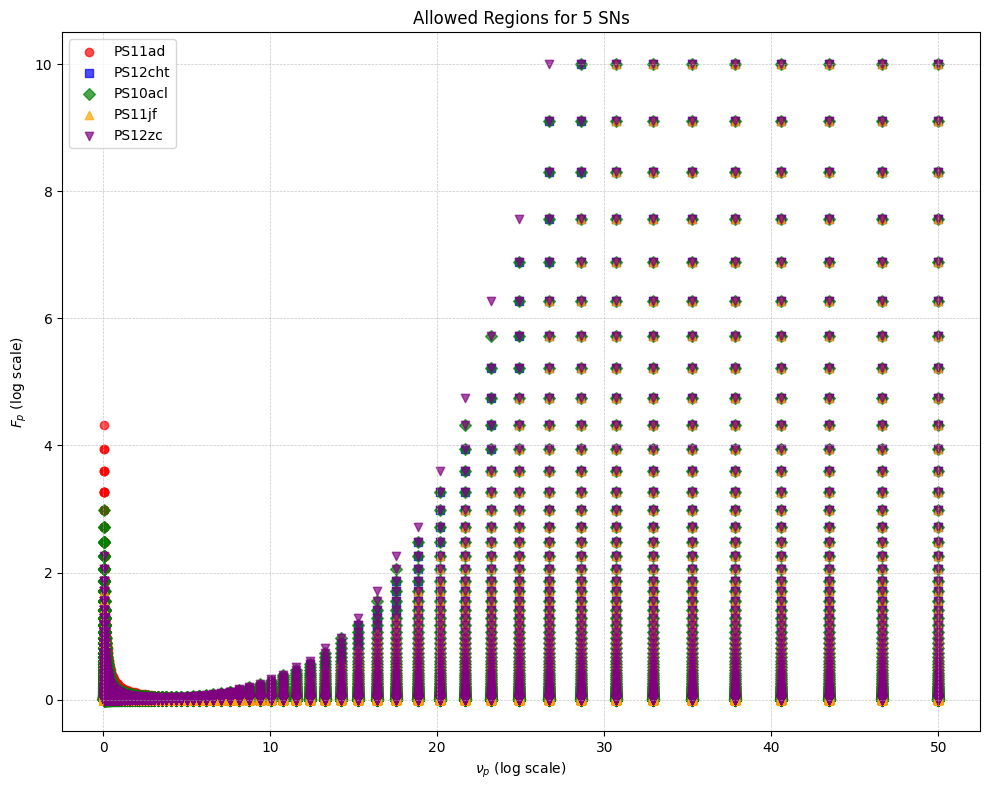

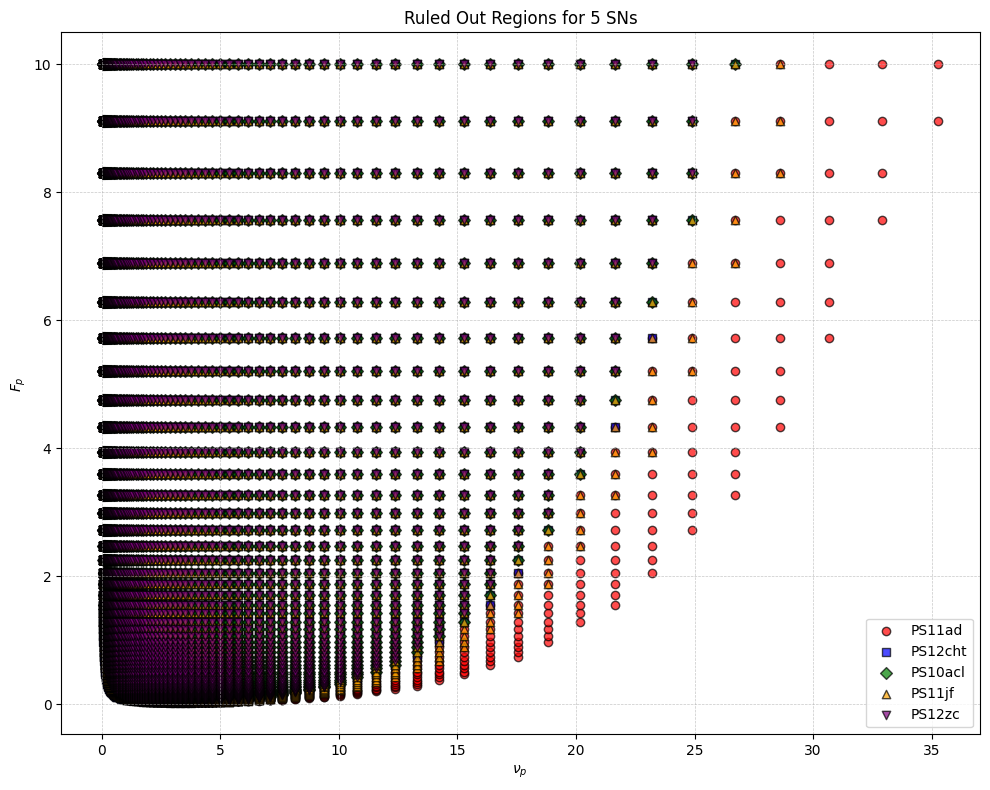

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii

def process_file(file_name):
    """
    Reads a file, filters data based on conditions, and returns F_p, nu_p, and RuledOut status.
    """
    data = ascii.read(file_name)
    
    # Convert 'RuledOut' to boolean if needed
    if data['RuledOut'].dtype.type is np.str_:
        ruled_out = data['RuledOut'] == 'True'
    else:
        ruled_out = data['RuledOut']
    
    # Extract F_p and nu_p values
    F_peak = data['F_peak']
    nu_peak = data['nu_peak']
    
    return F_peak, nu_peak, ruled_out

# List of filenames and corresponding SN labels
file_names = ['PS11ad.csv', 'PS12cht.csv', 'PS10acl.csv', 'PS11jf.csv', 'PS12zc.csv']
sn_labels = ['PS11ad', 'PS12cht', 'PS10acl', 'PS11jf', 'PS12zc']

# Define colors and markers for plotting
colors = ['red', 'blue', 'green', 'orange', 'purple']
markers = ['o', 's', 'D', '^', 'v']

# Plot for "allowed" SNs
plt.figure(figsize=(10, 8))
for i, file_name in enumerate(file_names):
    F_peak, nu_peak, ruled_out = process_file(file_name)
    
    # Plot "allowed" data points
    plt.scatter(
        nu_peak[~ruled_out], F_peak[~ruled_out],
        color=colors[i], marker=markers[i], label=sn_labels[i], alpha=0.7
    )

#plt.xscale('log')
#plt.yscale('log')
plt.xlabel(r'$\nu_p$ (log scale)')
plt.ylabel(r'$F_p$ (log scale)')
plt.title('Allowed Regions for 5 SNs')
plt.legend(loc='best', fontsize=10)
plt.grid(True, which="both", linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

# Plot for "ruled out" SNs
plt.figure(figsize=(10, 8))
for i, file_name in enumerate(file_names):
    F_peak, nu_peak, ruled_out = process_file(file_name)
    
    # Plot "ruled out" data points
    plt.scatter(
        nu_peak[ruled_out], F_peak[ruled_out],
        color=colors[i], marker=markers[i], edgecolor='black', label=sn_labels[i], alpha=0.7
    )

#plt.xscale('log')
#plt.yscale('log')
plt.xlabel(r'$\nu_p$ ')
plt.ylabel(r'$F_p$ ')
plt.title('Ruled Out Regions for 5 SNs')
plt.legend(loc='best', fontsize=10)
plt.grid(True, which="both", linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()


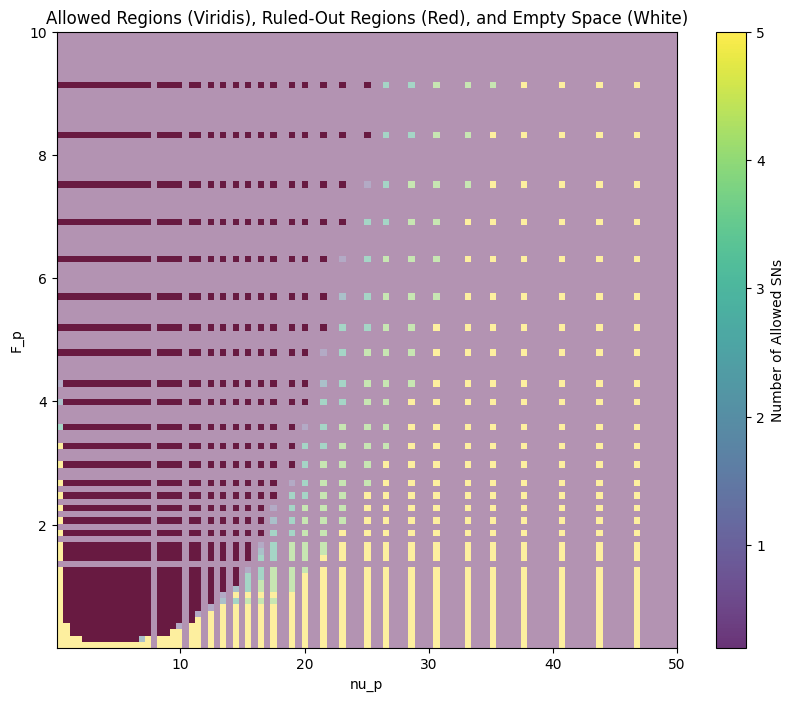

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii

def process_file(file_name):
    """
    Reads a file, filters data based on conditions, and returns F_p, nu_p, and RuledOut status.
    """
    data = ascii.read(file_name)
    
    # Convert 'RuledOut' to boolean if needed
    if data['RuledOut'].dtype.type is np.str_:
        ruled_out = data['RuledOut'] == 'True'
    else:
        ruled_out = data['RuledOut']
    
    # Extract F_p and nu_p values
    F_peak = data['F_peak']
    nu_peak = data['nu_peak']
    
    return F_peak, nu_peak, ruled_out

# Process all files (replace with actual filenames in your case)
file_names = ['PS11ad.csv', 'PS12cht.csv', 'PS10acl.csv', 'PS11jf.csv', 'PS12zc.csv']
results = [process_file(file) for file in file_names]

# Define bins for F_p and nu_p
F_p_bins = np.linspace(min(min(result[0]) for result in results), max(max(result[0]) for result in results), num=100)
nu_p_bins = np.linspace(min(min(result[1]) for result in results), max(max(result[1]) for result in results), num=100)

# Initialize arrays to store the count of allowed SNs and the total data points in each bin
allowed_counts = np.zeros((len(F_p_bins) - 1, len(nu_p_bins) - 1))  # Count of allowed SNs
total_counts = np.zeros((len(F_p_bins) - 1, len(nu_p_bins) - 1))    # Count of total SNs (allowed + ruled out)

# Process each file's data
for F_peak, nu_peak, ruled_out in results:
    # Bin the F_p and nu_p values
    F_p_indices = np.digitize(F_peak, bins=F_p_bins) - 1  # Subtract 1 for zero-based indexing
    nu_p_indices = np.digitize(nu_peak, bins=nu_p_bins) - 1  # Subtract 1 for zero-based indexing
    
    # Update counts for each bin
    for i in range(len(F_peak)):
        if 0 <= F_p_indices[i] < len(F_p_bins) - 1 and 0 <= nu_p_indices[i] < len(nu_p_bins) - 1:
            total_counts[F_p_indices[i], nu_p_indices[i]] += 1
            if not ruled_out[i]:
                allowed_counts[F_p_indices[i], nu_p_indices[i]] += 1

# Create a ruled-out mask (red) and empty parameter space mask (white)
ruled_out_mask = (allowed_counts == 0) & (total_counts > 0)  # No allowed SN but data exists
empty_space_mask = total_counts == 0                        # No data at all in the parameter space

# Plotting the binned data
plt.figure(figsize=(10, 8))

# Overlay the allowed regions with color codes
cmap = plt.cm.viridis
cmap.set_under(color='white')  # Set empty parameter space to white

plt.imshow(
    allowed_counts,
    origin='lower',
    extent=[
        nu_p_bins[0], nu_p_bins[-1],  # Linear scale for nu_p (x-axis)
        F_p_bins[0], F_p_bins[-1]     # Linear scale for F_p (y-axis)
    ],
    cmap='viridis',
    aspect='auto',
    alpha=0.8,
    vmin=0.2,  # Minimum value to avoid white for low counts
    vmax=5     # Color scale for bins with up to 5 SNs
)
# Add colorbar for allowed regions
plt.colorbar(label='Number of Allowed SNs')

# Overlay the ruled-out regions with a constant red color
plt.imshow(
    ruled_out_mask,
    origin='lower',
    extent=[
        nu_p_bins[0], nu_p_bins[-1],  # Linear scale for nu_p (x-axis)
        F_p_bins[0], F_p_bins[-1]     # Linear scale for F_p (y-axis)
    ],
    cmap='Reds',
    aspect='auto',
    alpha=0.5,  # Slight transparency for clarity
    vmin=0,     # Set min for the red color
    vmax=1      # Ensure a constant red color for all ruled-out regions
)

# Labels and title
plt.xlabel('nu_p')
plt.ylabel('F_p')
#plt.xscale('log')
#plt.yscale('log')
plt.title('Allowed Regions (Viridis), Ruled-Out Regions (Red), and Empty Space (White)')
plt.show()


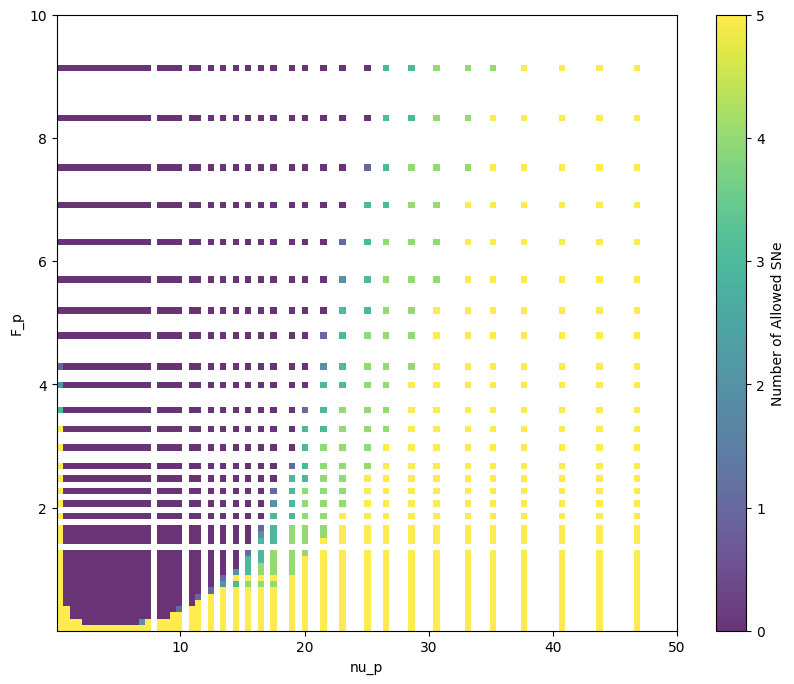

In [110]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
import matplotlib.colors as mcolors

def process_file(file_name):
    """
    Reads a file, filters data based on conditions, and returns F_p, nu_p, and RuledOut status.
    """
    data = ascii.read(file_name)
    
    # Convert 'RuledOut' to boolean if needed
    if data['RuledOut'].dtype.type is np.str_:
        ruled_out = data['RuledOut'] == 'True'
    else:
        ruled_out = data['RuledOut']
    
    # Extract F_p and nu_p values
    F_peak = data['F_peak']
    nu_peak = data['nu_peak']
    
    return F_peak, nu_peak, ruled_out

# Process all files (replace with actual filenames in your case)
file_names = ['PS11ad.csv', 'PS12cht.csv', 'PS10acl.csv', 'PS11jf.csv', 'PS12zc.csv']
results = [process_file(file) for file in file_names]

# Define bins for F_p and nu_p

F_p_bins = np.linspace(min(min(result[0]) for result in results), max(max(result[0]) for result in results), num=100)
nu_p_bins = np.linspace(min(min(result[1]) for result in results), max(max(result[1]) for result in results), num=100)

# Initialize arrays to store the count of allowed SNs and the total data points in each bin
allowed_counts = np.zeros((len(F_p_bins) - 1, len(nu_p_bins) - 1))  # Count of allowed SNs
total_counts = np.zeros((len(F_p_bins) - 1, len(nu_p_bins) - 1))    # Count of total SNs (allowed + ruled out)

# Process each file's data
for F_peak, nu_peak, ruled_out in results:
    # Bin the F_p and nu_p values
    F_p_indices = np.digitize(F_peak, bins=F_p_bins) - 1  # Subtract 1 for zero-based indexing
    nu_p_indices = np.digitize(nu_peak, bins=nu_p_bins) - 1  # Subtract 1 for zero-based indexing
    
    # Update counts for each bin
    for i in range(len(F_peak)):
        if 0 <= F_p_indices[i] < len(F_p_bins) - 1 and 0 <= nu_p_indices[i] < len(nu_p_bins) - 1:
            total_counts[F_p_indices[i], nu_p_indices[i]] += 1
            if not ruled_out[i]:
                allowed_counts[F_p_indices[i], nu_p_indices[i]] += 1

# Create a mask for empty bins
empty_space_mask = total_counts == 0

# Create a combined array for imshow
combined_array = np.where(empty_space_mask, np.nan, np.where(allowed_counts == 0, 0, allowed_counts))

# Plotting the binned data
plt.figure(figsize=(10, 8))

# Create a custom colormap with a specific color for ruled-out bins
cmap = plt.cm.viridis
cmap.set_bad(color='white')  # Set NaN values to white

# Create a custom norm to map ruled-out bins to a specific color
norm = mcolors.Normalize(vmin=0, vmax=5)  # Map values 0-5 to the viridis colormap

# Plot the combined array with the custom colormap
im = plt.imshow(
    combined_array,
    origin='lower',
    extent=[
        nu_p_bins[0], nu_p_bins[-1],  # Linear scale for nu_p (x-axis)
        F_p_bins[0], F_p_bins[-1]     # Linear scale for F_p (y-axis)
    ],
    cmap=cmap,
    aspect='auto',
    alpha=0.8,
    norm=norm
)

# Add colorbar for allowed regions
plt.colorbar(label='Number of Allowed SNe')

#cbar = plt.colorbar(im, label='Number of Allowed SNe')
#cbar.set_ticks([0, 1, 2, 3, 4, 5])
#cbar.set_ticklabels(['Ruled Out', 1, 2, 3, 4, 5])

# Labels and title
plt.xlabel('nu_p')
plt.ylabel('F_p')
#plt.title('Allowed, Ruled-Out, and Empty Parameter Space')
plt.show()


## An attempt to make the bins evenly distributed in the visualization

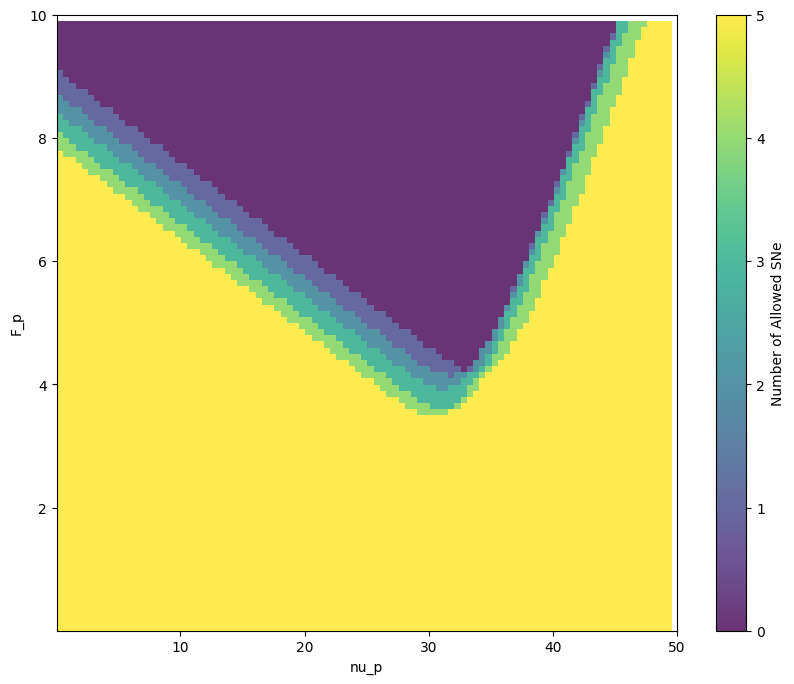

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
import matplotlib.colors as mcolors

def process_file(file_name):
    """
    Reads a file, filters data based on conditions, and returns F_p, nu_p, and RuledOut status.
    """
    data = ascii.read(file_name)
    
    # Convert 'RuledOut' to boolean if needed
    if data['RuledOut'].dtype.type is np.str_:
        ruled_out = data['RuledOut'] == 'True'
    else:
        ruled_out = data['RuledOut']
    
    # Extract F_p and nu_p values
    F_peak = data['F_peak']
    nu_peak = data['nu_peak']
    
    return F_peak, nu_peak, ruled_out

# Process all files (replace with actual filenames in your case)
file_names = ['PS11ad.csv', 'PS12cht.csv', 'PS10acl.csv', 'PS11jf.csv', 'PS12zc.csv']
results = [process_file(file) for file in file_names]

# Define bins for F_p and nu_p
F_p_bins = np.logspace(np.log10(0.001), np.log10(10.0), num=100)
nu_p_bins = np.logspace(np.log10(0.05), np.log10(50), num=100)

# To make the bins evenly spaced in logarithmic scale
F_p_bin_edges = np.logspace(np.log10(0.001), np.log10(10.0), num=101)
nu_p_bin_edges = np.logspace(np.log10(0.05), np.log10(50), num=101)

# Initialize arrays to store the count of allowed SNs and the total data points in each bin
allowed_counts = np.zeros((len(F_p_bin_edges) - 1, len(nu_p_bin_edges) - 1))  # Count of allowed SNs
total_counts = np.zeros((len(F_p_bin_edges) - 1, len(nu_p_bin_edges) - 1))    # Count of total SNs (allowed + ruled out)

# Process each file's data
for F_peak, nu_peak, ruled_out in results:
    # Bin the F_p and nu_p values
    F_p_indices = np.digitize(F_peak, bins=F_p_bins) - 1  # Subtract 1 for zero-based indexing
    nu_p_indices = np.digitize(nu_peak, bins=nu_p_bins) - 1  # Subtract 1 for zero-based indexing
    
    # Update counts for each bin
    for i in range(len(F_peak)):
        if 0 <= F_p_indices[i] < len(F_p_bins) - 1 and 0 <= nu_p_indices[i] < len(nu_p_bins) - 1:
            total_counts[F_p_indices[i], nu_p_indices[i]] += 1
            if not ruled_out[i]:
                allowed_counts[F_p_indices[i], nu_p_indices[i]] += 1

# Create a mask for empty bins
empty_space_mask = total_counts == 0

# Create a combined array for imshow
combined_array = np.where(empty_space_mask, np.nan, np.where(allowed_counts == 0, 0, allowed_counts))

# Plotting the binned data
plt.figure(figsize=(10, 8))

# Create a custom colormap with a specific color for ruled-out bins
cmap = plt.cm.viridis
cmap.set_bad(color='white')  # Set NaN values to white

# Create a custom norm to map ruled-out bins to a specific color
norm = mcolors.Normalize(vmin=0, vmax=5)  # Map values 0-5 to the viridis colormap

# Plot the combined array with the custom colormap
im = plt.imshow(
    combined_array,
    origin='lower',
    extent=[
        nu_p_bins[0], nu_p_bins[-1],  # Linear scale for nu_p (x-axis)
        F_p_bins[0], F_p_bins[-1]     # Linear scale for F_p (y-axis)
    ],
    cmap=cmap,
    aspect='auto',
    alpha=0.8,
    norm=norm
)

# Add colorbar for allowed regions
plt.colorbar(label='Number of Allowed SNe')

#cbar = plt.colorbar(im, label='Number of Allowed SNe')
#cbar.set_ticks([0, 1, 2, 3, 4, 5])
#cbar.set_ticklabels(['Ruled Out', 1, 2, 3, 4, 5])

# Labels and title
plt.xlabel('nu_p')
plt.ylabel('F_p')
#plt.title('Allowed, Ruled-Out, and Empty Parameter Space')
plt.show()


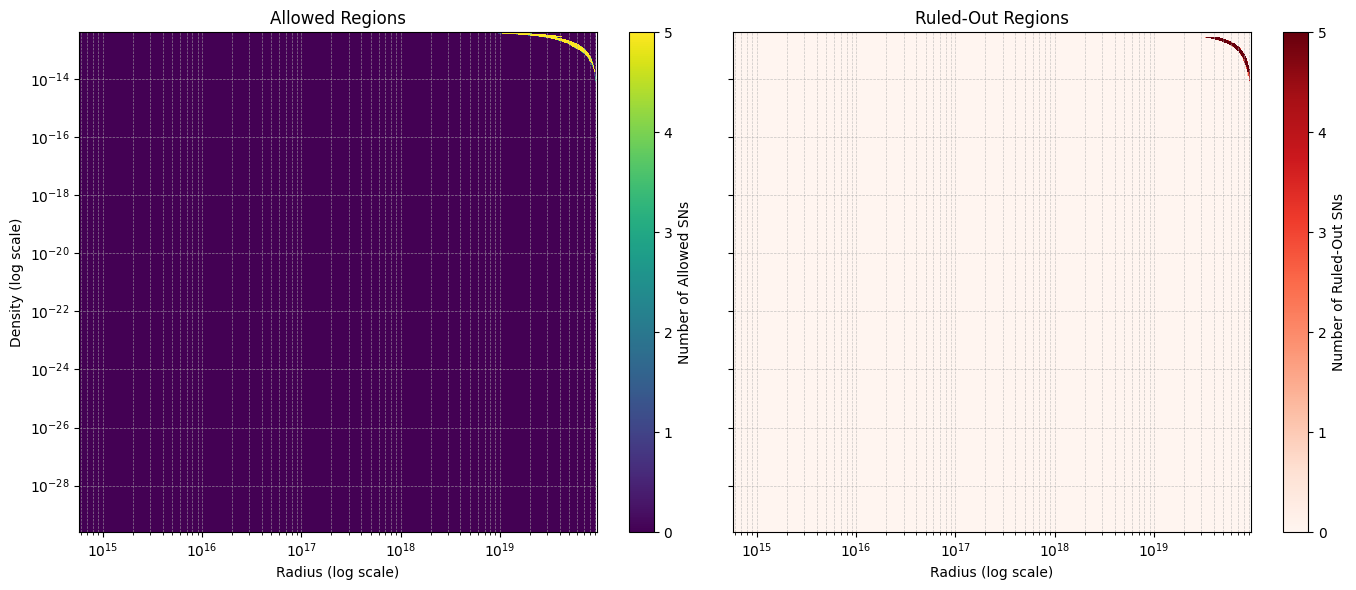

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii

def process_file(file_name):
    """
    Reads a file and returns Radius, Density, and RuledOut status.
    """
    data = ascii.read(file_name)
    
    # Convert 'RuledOut' to boolean if needed
    if data['RuledOut'].dtype.type is np.str_:
        ruled_out = data['RuledOut'] == 'True'
    else:
        ruled_out = data['RuledOut']
    
    # Extract Radius and Density
    rad = data['Radius']
    den = data['den']
    
    return rad, den, ruled_out

# Process all files (replace with actual filenames in your case)
file_names = ['PS11ad.csv', 'PS12cht.csv', 'PS10acl.csv', 'PS11jf.csv', 'PS12zc.csv']
results = [process_file(file) for file in file_names]

# Define bins for Radius and Density
rad_bins = np.logspace(
    np.log10(min(min(result[0]) for result in results)),
    np.log10(max(max(result[0]) for result in results)),
    num=100
)
den_bins = np.logspace(
    np.log10(min(min(result[1]) for result in results)),
    np.log10(max(max(result[1]) for result in results)),
    num=100
)

# Initialize arrays to store counts
allowed_counts = np.zeros((len(rad_bins) - 1, len(den_bins) - 1))  # Allowed SN counts
ruled_out_counts = np.zeros((len(rad_bins) - 1, len(den_bins) - 1))  # Ruled-out SN counts

# Process each file's data
for rad, den, ruled_out in results:
    # Bin the Radius and Density values
    rad_indices = np.digitize(rad, bins=rad_bins) - 1  # Subtract 1 for zero-based indexing
    den_indices = np.digitize(den, bins=den_bins) - 1  # Subtract 1 for zero-based indexing
    
    # Update counts for each bin
    for i in range(len(rad)):
        if 0 <= rad_indices[i] < len(rad_bins) - 1 and 0 <= den_indices[i] < len(den_bins) - 1:
            if ruled_out[i]:
                ruled_out_counts[rad_indices[i], den_indices[i]] += 1
            else:
                allowed_counts[rad_indices[i], den_indices[i]] += 1

# Set up the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)
allowed_ax, ruled_out_ax = axes

# Plot heatmap for allowed regions
allowed_im = allowed_ax.imshow(
    allowed_counts.T, 
    origin='lower', 
    extent=[rad_bins[0], rad_bins[-1], den_bins[0], den_bins[-1]], 
    cmap='viridis', 
    aspect='auto',
    vmin=0,  # Minimum SN count
    vmax=5   # Maximum SN count
)
fig.colorbar(allowed_im, ax=allowed_ax, label='Number of Allowed SNs')

# Plot heatmap for ruled-out regions
ruled_out_im = ruled_out_ax.imshow(
    ruled_out_counts.T, 
    origin='lower', 
    extent=[rad_bins[0], rad_bins[-1], den_bins[0], den_bins[-1]], 
    cmap='Reds', 
    aspect='auto',
    vmin=0,  # Minimum SN count
    vmax=5   # Maximum SN count
)
fig.colorbar(ruled_out_im, ax=ruled_out_ax, label='Number of Ruled-Out SNs')

# Set log scale for the axes
for ax in axes:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Add labels and titles
allowed_ax.set_title('Allowed Regions')
ruled_out_ax.set_title('Ruled-Out Regions')
allowed_ax.set_xlabel('Radius (log scale)')
ruled_out_ax.set_xlabel('Radius (log scale)')
allowed_ax.set_ylabel('Density (log scale)')

# Adjust layout and show
plt.tight_layout()
plt.show()


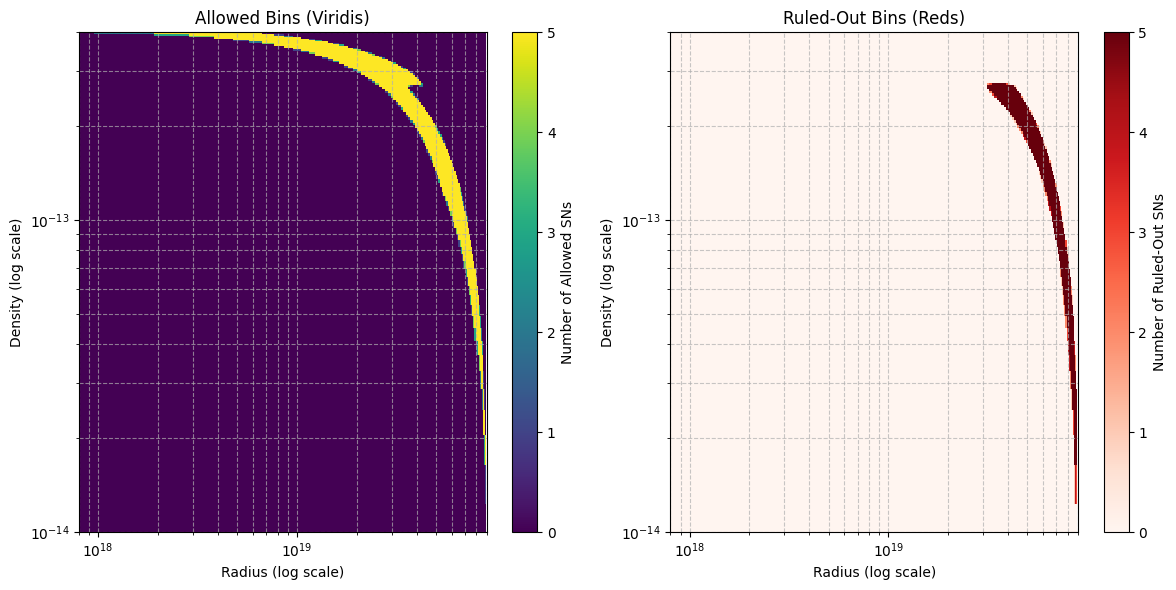

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
from matplotlib import colors

def process_file(file_name):
    """
    Reads a file and returns Radius, Density, and RuledOut status.
    """
    data = ascii.read(file_name)
    
    # Convert 'RuledOut' to boolean if needed
    if data['RuledOut'].dtype.type is np.str_:
        ruled_out = data['RuledOut'] == 'True'
    else:
        ruled_out = data['RuledOut']
    
    # Extract Radius and Density
    rad = data['Radius']
    den = data['den']
    
    return rad, den, ruled_out

# Process all files (replace with actual filenames in your case)
file_names = ['PS11ad.csv', 'PS12cht.csv', 'PS10acl.csv', 'PS11jf.csv', 'PS12zc.csv']
results = [process_file(file) for file in file_names]

# Concatenate all data to determine the range
all_rad = np.concatenate([result[0] for result in results])
all_den = np.concatenate([result[1] for result in results])

# Dynamically set the bin range to data limits
rad_bins = np.logspace(np.log10(min(all_rad)), np.log10(max(all_rad)), num=100)
den_bins = np.logspace(np.log10(min(all_den)), np.log10(max(all_den)), num=100)

# Initialize arrays to store counts
allowed_counts = np.zeros((len(rad_bins) - 1, len(den_bins) - 1))  # Count of allowed SNs
ruled_out_counts = np.zeros((len(rad_bins) - 1, len(den_bins) - 1))  # Count of ruled-out SNs

# Process each file's data
for rad, den, ruled_out in results:
    # Bin the Radius and Density values
    rad_indices = np.digitize(rad, bins=rad_bins) - 1  # Subtract 1 for zero-based indexing
    den_indices = np.digitize(den, bins=den_bins) - 1  # Subtract 1 for zero-based indexing
    
    # Update counts for each bin
    for i in range(len(rad)):
        if 0 <= rad_indices[i] < len(rad_bins) - 1 and 0 <= den_indices[i] < len(den_bins) - 1:
            if ruled_out[i]:
                ruled_out_counts[rad_indices[i], den_indices[i]] += 1
            else:
                allowed_counts[rad_indices[i], den_indices[i]] += 1

# Plotting the heatmaps

plt.figure(figsize=(12, 6))

# Allowed bins
plt.subplot(1, 2, 1)

# Create a custom Normalize instance to control empty space color
norm_allowed = colors.Normalize(vmin=0, vmax=5)

im = plt.imshow(
    allowed_counts.T, 
    origin='lower', 
    extent=[rad_bins[0], rad_bins[-1], den_bins[0], den_bins[-1]], 
    cmap='viridis',  # Colormap for allowed bins
    aspect='auto',
    norm=norm_allowed,  # Apply the custom normalization
    interpolation='nearest'
)
# Set color for empty bins by using a color below the range of `vmin`
im.cmap.set_under('lightgray')

plt.colorbar(im, label='Number of Allowed SNs')
plt.xscale('log')
plt.yscale('log')
plt.xlim(8e17, 9e19)  # Set the zoom limits for the x-axis
plt.ylim(1e-14, 4e-13)  # Set the zoom limits for the y-axis
plt.xlabel('Radius (log scale)')
plt.ylabel('Density (log scale)')
plt.title('Allowed Bins (Viridis)')
plt.grid(which='both', linestyle='--', alpha=0.7)

# Ruled-out bins
plt.subplot(1, 2, 2)

# Create a custom Normalize instance for ruled-out bins
norm_ruled_out = colors.Normalize(vmin=0, vmax=5)

im = plt.imshow(
    ruled_out_counts.T, 
    origin='lower', 
    extent=[rad_bins[0], rad_bins[-1], den_bins[0], den_bins[-1]], 
    cmap='Reds',  # Colormap for ruled-out bins
    aspect='auto',
    norm=norm_ruled_out,  # Apply the custom normalization
    interpolation='nearest'
)
# Set color for empty bins by using a color below the range of `vmin`
im.cmap.set_under('lightgray')

plt.colorbar(im, label='Number of Ruled-Out SNs')
plt.xscale('log')
plt.yscale('log')
plt.xlim(8e17, 9e19)  # Set the zoom limits for the x-axis
plt.ylim(1e-14, 4e-13)  # Set the zoom limits for the y-axis
plt.xlabel('Radius (log scale)')
plt.ylabel('Density (log scale)')
plt.title('Ruled-Out Bins (Reds)')
plt.grid(which='both', linestyle='--', alpha=0.7)

# Adjust layout and show
plt.tight_layout()
plt.show()


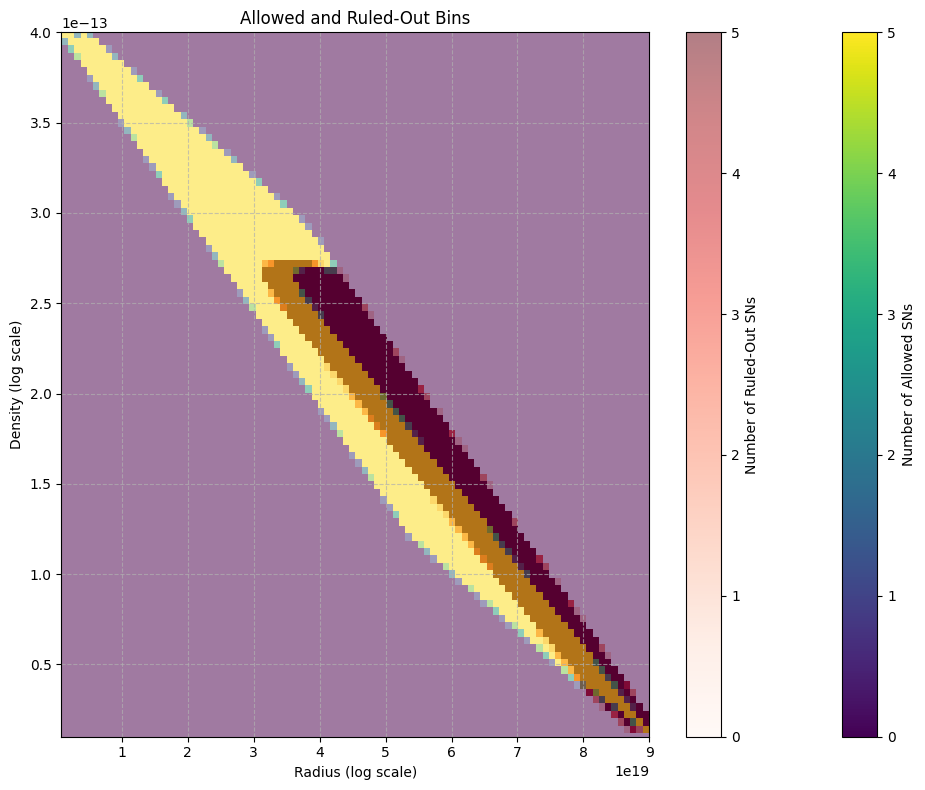

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
from matplotlib import colors

def process_file(file_name):
    """
    Reads a file and returns Radius, Density, and RuledOut status.
    """
    data = ascii.read(file_name)
    
    # Convert 'RuledOut' to boolean if needed
    if data['RuledOut'].dtype.type is np.str_:
        ruled_out = data['RuledOut'] == 'True'
    else:
        ruled_out = data['RuledOut']
    
    # Extract Radius and Density
    rad = data['Radius']
    den = data['den']
    
    return rad, den, ruled_out

# Process all files (replace with actual filenames in your case)
file_names = ['PS11ad.csv', 'PS12cht.csv', 'PS10acl.csv', 'PS11jf.csv', 'PS12zc.csv']
results = [process_file(file) for file in file_names]

# Concatenate all data to determine the range
all_rad = np.concatenate([result[0] for result in results])
all_den = np.concatenate([result[1] for result in results])

# Dynamically set the bin range to data limits
rad_bins = np.logspace(np.log10(min(all_rad)), np.log10(max(all_rad)), num=100)
den_bins = np.logspace(np.log10(min(all_den)), np.log10(max(all_den)), num=100)

# Initialize arrays to store counts
allowed_counts = np.zeros((len(rad_bins) - 1, len(den_bins) - 1))  # Count of allowed SNs
ruled_out_counts = np.zeros((len(rad_bins) - 1, len(den_bins) - 1))  # Count of ruled-out SNs

# Process each file's data
for rad, den, ruled_out in results:
    # Bin the Radius and Density values
    rad_indices = np.digitize(rad, bins=rad_bins) - 1  # Subtract 1 for zero-based indexing
    den_indices = np.digitize(den, bins=den_bins) - 1  # Subtract 1 for zero-based indexing
    
    # Update counts for each bin
    for i in range(len(rad)):
        if 0 <= rad_indices[i] < len(rad_bins) - 1 and 0 <= den_indices[i] < len(den_bins) - 1:
            if ruled_out[i]:
                ruled_out_counts[rad_indices[i], den_indices[i]] += 1
            else:
                allowed_counts[rad_indices[i], den_indices[i]] += 1

# Plotting the heatmap for both allowed and ruled-out regions in a single plot
plt.figure(figsize=(10, 8))

# Create a custom Normalize instance to control empty space color
norm_allowed = colors.Normalize(vmin=0, vmax=5)
norm_ruled_out = colors.Normalize(vmin=0, vmax=5)

# Plot allowed regions
im_allowed = plt.imshow(
    allowed_counts.T, 
    origin='lower', 
    extent=[rad_bins[0], rad_bins[-1], den_bins[0], den_bins[-1]], 
    cmap='viridis',  # Colormap for allowed bins
    aspect='auto',
    norm=norm_allowed,  # Apply the custom normalization
    interpolation='nearest'
)

# Plot ruled-out regions with transparency
im_ruled_out = plt.imshow(
    ruled_out_counts.T, 
    origin='lower', 
    extent=[rad_bins[0], rad_bins[-1], den_bins[0], den_bins[-1]], 
    cmap='Reds',  # Colormap for ruled-out bins
    aspect='auto',
    norm=norm_ruled_out,  # Apply the custom normalization
    alpha=0.5,  # Set transparency for ruled-out regions
    interpolation='nearest'
)

# Set color for empty bins by using a color below the range of `vmin`
im_allowed.cmap.set_under('lightgray')
im_ruled_out.cmap.set_under('lightgray')

# Add colorbars for both regions
cbar_allowed = plt.colorbar(im_allowed, label='Number of Allowed SNs')
cbar_ruled_out = plt.colorbar(im_ruled_out, label='Number of Ruled-Out SNs')

# Set axes properties
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(8e17, 9e19)  # Set the zoom limits for the x-axis
plt.ylim(1e-14, 4e-13)  # Set the zoom limits for the y-axis
plt.xlabel('Radius (log scale)')
plt.ylabel('Density (log scale)')
plt.title('Allowed and Ruled-Out Bins')
plt.grid(which='both', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


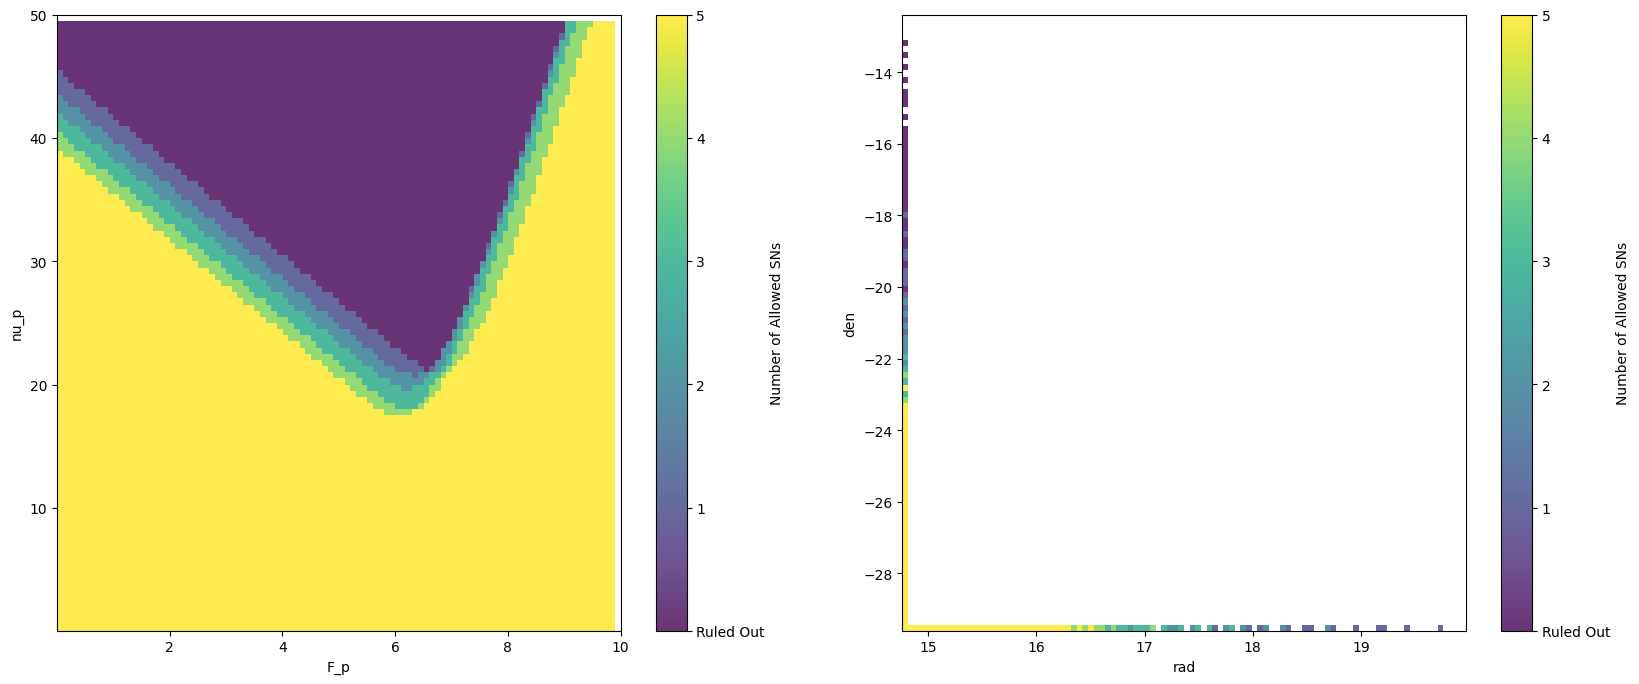

In [122]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
import matplotlib.colors as mcolors

def process_file(file_name):
    """
    Reads a file, filters data based on conditions, and returns F_p, nu_p, rad, den, and RuledOut status.
    """
    data = ascii.read(file_name)
    
    # Convert 'RuledOut' to boolean if needed
    if data['RuledOut'].dtype.type is np.str_:
        ruled_out = data['RuledOut'] == 'True'
    else:
        ruled_out = data['RuledOut']
    
    # Extract F_p, nu_p, rad, and den values
    F_peak = data['F_peak']
    nu_peak = data['nu_peak']
    rad = data['Radius']
    den = data['den']
    
    return F_peak, nu_peak, rad, den, ruled_out

# Process all files (replace with actual filenames in your case)
file_names = ['PS11ad.csv', 'PS12cht.csv', 'PS10acl.csv', 'PS11jf.csv', 'PS12zc.csv']
results = [process_file(file) for file in file_names]

# Define bins for F_p, nu_p, rad, and den
F_p_bins = np.logspace(np.log10(0.001), np.log10(10.0), num=100)
nu_p_bins = np.logspace(np.log10(0.05), np.log10(50), num=100)
rad_bins = np.linspace(min(min(result[2]) for result in results), max(max(result[2]) for result in results), num=100)
den_bins = np.linspace(min(min(result[3]) for result in results), max(max(result[3]) for result in results), num=100)

# To make the bins evenly spaced in logarithmic scale
F_p_bin_edges = np.logspace(np.log10(0.001), np.log10(10.0), num=101)
nu_p_bin_edges = np.logspace(np.log10(0.05), np.log10(50), num=101)
rad_bin_edges = np.linspace(min(min(result[2]) for result in results), max(max(result[2]) for result in results), num=101)
den_bin_edges = np.linspace(min(min(result[3]) for result in results), max(max(result[3]) for result in results), num=101)

# Initialize arrays to store the count of allowed SNs and the total data points in each bin
F_allowed_counts = np.zeros((len(F_p_bin_edges) - 1, len(nu_p_bin_edges) - 1))  # Count of allowed SNs
F_total_counts = np.zeros((len(F_p_bin_edges) - 1, len(nu_p_bin_edges) - 1))    # Count of total SNs (allowed + ruled out)

rad_allowed_counts = np.zeros((len(rad_bin_edges) - 1, len(den_bin_edges) - 1))  # Count of allowed SNs
rad_total_counts = np.zeros((len(rad_bin_edges) - 1, len(den_bin_edges) - 1))    # Count of total SNs (allowed + ruled out)

# Process each file's data
for F_peak, nu_peak, rad, den, ruled_out in results:
    # Bin the F_p and nu_p values
    F_p_indices = np.digitize(F_peak, bins=F_p_bin_edges) - 1  # Subtract 1 for zero-based indexing
    nu_p_indices = np.digitize(nu_peak, bins=nu_p_bin_edges) - 1  # Subtract 1 for zero-based indexing
    
    # Bin the rad and den values
    rad_indices = np.digitize(rad, bins=rad_bin_edges) - 1  # Subtract 1 for zero-based indexing
    den_indices = np.digitize(den, bins=den_bin_edges) - 1  # Subtract 1 for zero-based indexing
    
    # Update counts for each bin
    for i in range(len(F_peak)):
        if 0 <= F_p_indices[i] < len(F_p_bin_edges) - 1 and 0 <= nu_p_indices[i] < len(nu_p_bin_edges) - 1:
            F_total_counts[F_p_indices[i], nu_p_indices[i]] += 1
            if not ruled_out[i]:
                F_allowed_counts[F_p_indices[i], nu_p_indices[i]] += 1
        
        if 0 <= rad_indices[i] < len(rad_bin_edges) - 1 and 0 <= den_indices[i] < len(den_bin_edges) - 1:
            rad_total_counts[rad_indices[i], den_indices[i]] += 1
            if not ruled_out[i]:
                rad_allowed_counts[rad_indices[i], den_indices[i]] += 1

# Create a mask for empty bins
F_empty_space_mask = F_total_counts == 0
rad_empty_space_mask = rad_total_counts == 0

# Create a combined array for imshow
F_combined_array = np.where(F_empty_space_mask, np.nan, np.where(F_allowed_counts == 0, 0, F_allowed_counts))
rad_combined_array = np.where(rad_empty_space_mask, np.nan, np.where(rad_allowed_counts == 0, 0, rad_allowed_counts))

# Plotting the binned data
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Create a custom colormap with a specific color for ruled-out bins
cmap = plt.cm.viridis
cmap.set_bad(color='white')  # Set NaN values to white

# Create a custom norm to map ruled-out bins to a specific color
norm = mcolors.Normalize(vmin=0, vmax=5)  # Map values 0-5 to the viridis colormap

# Plot the combined array with the custom colormap
im1 = axs[0].imshow(
    F_combined_array,
    origin='lower',
    extent=[
        F_p_bin_edges[0], F_p_bin_edges[-1],  # Linear scale for F_p (x-axis)
        nu_p_bin_edges[0], nu_p_bin_edges[-1]     # Linear scale for nu_p (y-axis)
    ],
    cmap=cmap,
    aspect='auto',
    alpha=0.8,
    norm=norm
)

im2 = axs[1].imshow(
    rad_combined_array,
    origin='lower',
    extent=[
        np.log10(rad_bin_edges[0]), np.log10(rad_bin_edges[-1]),  # Log10 scale for rad (x-axis)
        np.log10(den_bin_edges[0]), np.log10(den_bin_edges[-1])     # Log10 scale for den (y-axis)
    ],
    cmap=cmap,
    aspect='auto',
    alpha=0.8,
    norm=norm
)

# Add colorbar for allowed regions
cbar1 = fig.colorbar(im1, ax=axs[0], label='Number of Allowed SNs')
cbar1.set_ticks([0, 1, 2, 3, 4, 5])
cbar1.set_ticklabels(['Ruled Out', 1, 2, 3, 4, 5])

cbar2 = fig.colorbar(im2, ax=axs[1], label='Number of Allowed SNs')
cbar2.set_ticks([0, 1, 2, 3, 4, 5])
cbar2.set_ticklabels(['Ruled Out', 1, 2, 3, 4, 5])

axs[0].set_xlabel('F_p')
axs[0].set_ylabel('nu_p')
axs[1].set_xlabel('rad')
axs[1].set_ylabel('den')


#axs[1].set_xscale('log')
#axs[1].set_yscale('log')

plt.show()

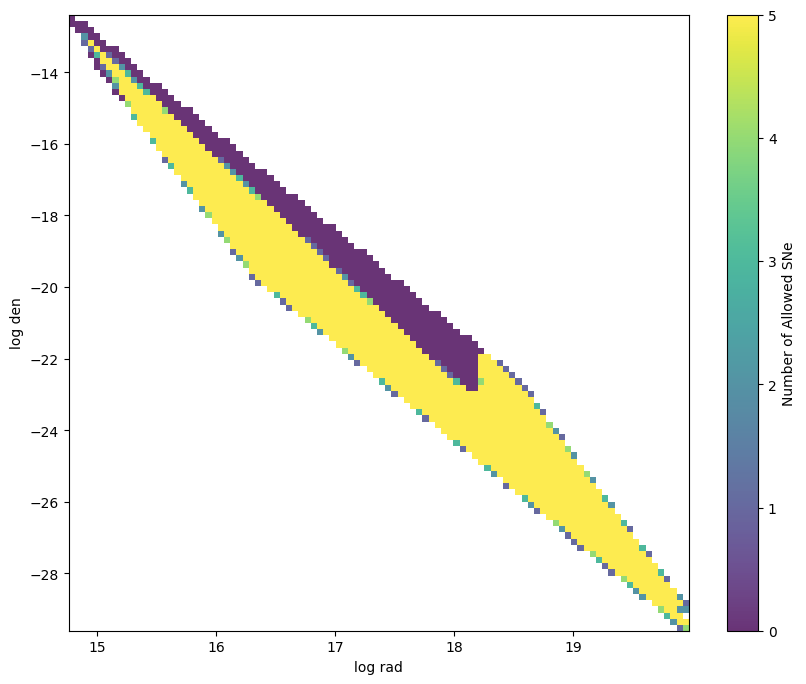

In [131]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
import matplotlib.colors as mcolors

def process_file(file_name):
    """
    Reads a file, filters data based on conditions, and returns rad, den, and RuledOut status.
    """
    data = ascii.read(file_name)
    
    # Convert 'RuledOut' to boolean if needed
    if data['RuledOut'].dtype.type is np.str_:
        ruled_out = data['RuledOut'] == 'True'
    else:
        ruled_out = data['RuledOut']
    
    # Extract rad and den values
    rad = data['Radius']
    den = data['den']
    
    return rad, den, ruled_out

# Process all files (replace with actual filenames in your case)
file_names = ['PS11ad.csv', 'PS12cht.csv', 'PS10acl.csv', 'PS11jf.csv', 'PS12zc.csv']
results = [process_file(file) for file in file_names]

# Define bins for rad and den
rad_bins = np.logspace(np.log10(min(min(result[0]) for result in results)), np.log10(max(max(result[0]) for result in results)), num=100)
den_bins = np.logspace(np.log10(min(min(result[1]) for result in results)), np.log10(max(max(result[1]) for result in results)), num=100)

# To make the bins evenly spaced in logarithmic scale
rad_bin_edges = np.logspace(np.log10(min(min(result[0]) for result in results)), np.log10(max(max(result[0]) for result in results)), num=101)
den_bin_edges = np.logspace(np.log10(min(min(result[1]) for result in results)), np.log10(max(max(result[1]) for result in results)), num=101)

# Initialize arrays to store the count of allowed SNs and the total data points in each bin
rad_allowed_counts = np.zeros((len(rad_bin_edges) - 1, len(den_bin_edges) - 1))  # Count of allowed SNs
rad_total_counts = np.zeros((len(rad_bin_edges) - 1, len(den_bin_edges) - 1))    # Count of total SNs (allowed + ruled out)

# Process each file's data
for rad, den, ruled_out in results:
    # Bin the log10 values of rad and den
    log_rad = np.log10(rad)
    log_den = np.log10(den)
    
    rad_indices = np.digitize(log_rad, bins=np.log10(rad_bin_edges)) - 1  # Subtract 1 for zero-based indexing
    den_indices = np.digitize(log_den, bins=np.log10(den_bin_edges)) - 1  # Subtract 1 for zero-based indexing
    
    # Update counts for each bin
    for i in range(len(rad)):
        if 0 <= rad_indices[i] < len(rad_bin_edges) - 1 and 0 <= den_indices[i] < len(den_bin_edges) - 1:
            rad_total_counts[rad_indices[i], den_indices[i]] += 1
            if not ruled_out[i]:
                rad_allowed_counts[rad_indices[i], den_indices[i]] += 1

# Create a mask for empty bins
rad_empty_space_mask = rad_total_counts == 0

# Create a combined array for imshow
rad_combined_array = np.where(rad_empty_space_mask, np.nan, np.where(rad_allowed_counts == 0, 0, rad_allowed_counts))

# Plotting the binned data
plt.figure(figsize=(10, 8))

# Create a custom colormap with a specific color for ruled-out bins
cmap = plt.cm.viridis
cmap.set_bad(color='white')  # Set NaN values to white

# Create a custom norm to map ruled-out bins to a specific color
norm = mcolors.Normalize(vmin=0, vmax=5)  # Map values 0-5 to the viridis colormap

# Plot the combined array with the custom colormap
im = plt.imshow(
    rad_combined_array,
    origin='lower',
    extent=[
        np.log10(rad_bin_edges[0]), np.log10(rad_bin_edges[-1]),  # Log10 scale for rad (x-axis)
        np.log10(den_bin_edges[0]), np.log10(den_bin_edges[-1])     # Log10 scale for den (y-axis)
    ],
    cmap=cmap,
    aspect='auto',
    alpha=0.8,
    norm=norm
)

# Add colorbar for allowed regions
plt.colorbar(label='Number of Allowed SNe')

#cbar = plt.colorbar(im, label='Number of Allowed SNe')
#cbar.set_ticks([0, 1, 2, 3,4,5])
#cbar.set_ticklabels(['Ruled Out', 1, 2, 3, 4, 5])

plt.xlabel('log rad')
plt.ylabel('log den')


#axs[1].set_xscale('log')
#axs[1].set_yscale('log')

plt.show()

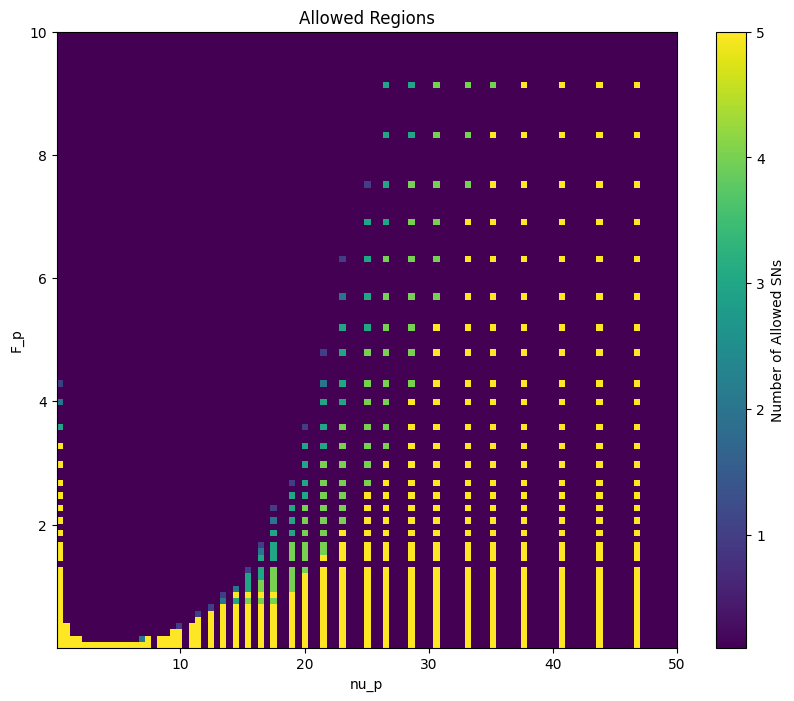

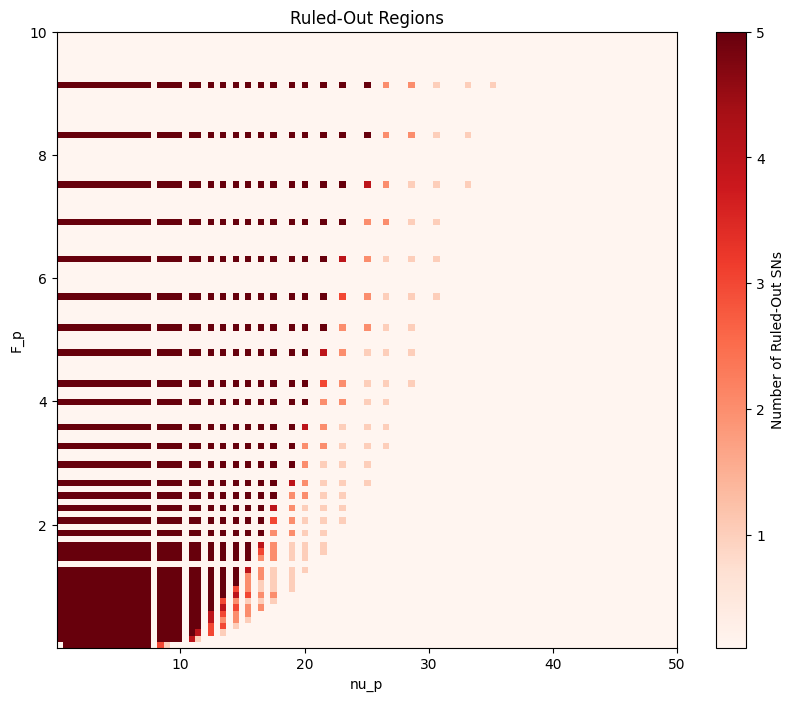

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii

def process_file(file_name):
    """
    Reads a file, filters data based on conditions, and returns F_p, nu_p, and RuledOut status.
    """
    data = ascii.read(file_name)
    
    # Convert 'RuledOut' to boolean if needed
    if data['RuledOut'].dtype.type is np.str_:
        ruled_out = data['RuledOut'] == 'True'
    else:
        ruled_out = data['RuledOut']
    
    # Extract F_p and nu_p values
    F_peak = data['F_peak']
    nu_peak = data['nu_peak']
    
    return F_peak, nu_peak, ruled_out

# Process all files (replace with actual filenames in your case)
file_names = ['PS11ad.csv', 'PS12cht.csv', 'PS10acl.csv', 'PS11jf.csv', 'PS12zc.csv']
results = [process_file(file) for file in file_names]

# Define bins for F_p and nu_p
F_p_bins = np.linspace(min(min(result[0]) for result in results), max(max(result[0]) for result in results), num=100)
nu_p_bins = np.linspace(min(min(result[1]) for result in results), max(max(result[1]) for result in results), num=100)

# Initialize arrays to store the count of allowed SNs and ruled-out regions
allowed_counts = np.zeros((len(F_p_bins) - 1, len(nu_p_bins) - 1))  # Count of allowed SNs
ruled_out_counts = np.zeros((len(F_p_bins) - 1, len(nu_p_bins) - 1))  # Count of ruled-out regions

# Process each file's data
for F_peak, nu_peak, ruled_out in results:
    # Bin the F_p and nu_p values
    F_p_indices = np.digitize(F_peak, bins=F_p_bins) - 1  # Subtract 1 for zero-based indexing
    nu_p_indices = np.digitize(nu_peak, bins=nu_p_bins) - 1  # Subtract 1 for zero-based indexing
    
    # Update counts for each bin
    for i in range(len(F_peak)):
        if 0 <= F_p_indices[i] < len(F_p_bins) - 1 and 0 <= nu_p_indices[i] < len(nu_p_bins) - 1:
            if not ruled_out[i]:
                allowed_counts[F_p_indices[i], nu_p_indices[i]] += 1
            else:
                ruled_out_counts[F_p_indices[i], nu_p_indices[i]] += 1

# Plotting the allowed regions
plt.figure(figsize=(10, 8))
plt.imshow(
    allowed_counts,
    origin='lower',
    extent=[
        nu_p_bins[0], nu_p_bins[-1],  # Linear scale for nu_p (x-axis)
        F_p_bins[0], F_p_bins[-1]     # Linear scale for F_p (y-axis)
    ],
    cmap='viridis',
    aspect='auto',
    vmin=0.1,  # Minimum value to avoid white for low counts
    vmax=5     # Color scale for bins with up to 5 SNs
)
plt.colorbar(label='Number of Allowed SNs')
plt.xlabel('nu_p')
plt.ylabel('F_p')
plt.title('Allowed Regions')
plt.show()

# Plotting the ruled-out regions
plt.figure(figsize=(10, 8))
plt.imshow(
    ruled_out_counts,
    origin='lower',
    extent=[
        nu_p_bins[0], nu_p_bins[-1],  # Linear scale for nu_p (x-axis)
        F_p_bins[0], F_p_bins[-1]     # Linear scale for F_p (y-axis)
    ],
    cmap='Reds',
    aspect='auto',
    vmin=0.1,  # Minimum value to avoid white for low counts
    vmax=5     # Color scale for bins with up to 5 ruled-out SNs
)
plt.colorbar(label='Number of Ruled-Out SNs')
plt.xlabel('nu_p')
plt.ylabel('F_p')
plt.title('Ruled-Out Regions')
plt.show()


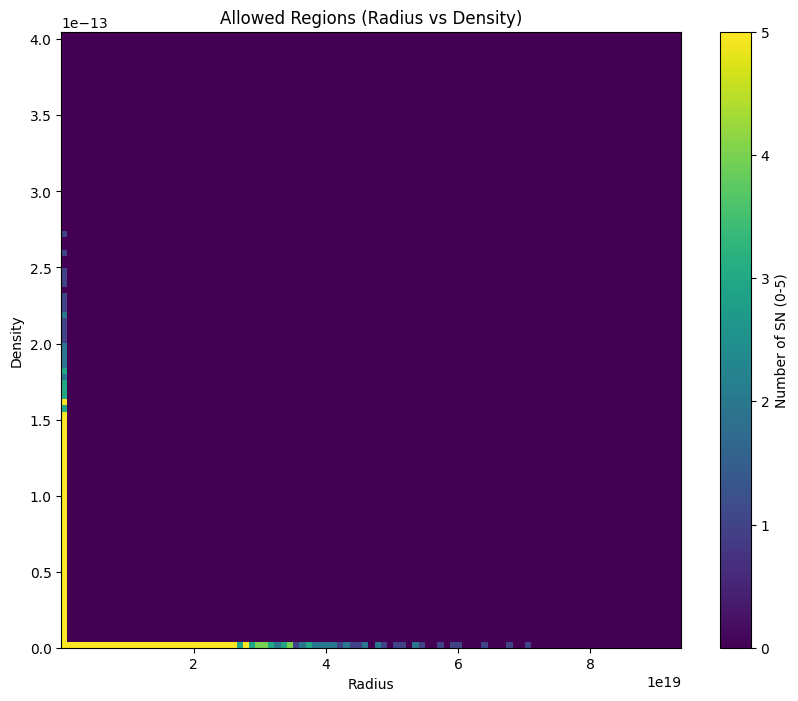

In [126]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii

def process_file(file_name):
    """
    Reads a file, filters data based on conditions, and returns F_p, nu_p, den (density), Radius, and RuledOut status.
    """
    data = ascii.read(file_name)
    
    # Extract the necessary columns: F_p, nu_p, den (density), Radius, and RuledOut status
    F_peak = data['F_peak']
    nu_peak = data['nu_peak']
    density = data['den']  # Assuming 'den' is the column for density
    radius = data['Radius']  # Assuming 'Radius' is the column for radius
    ruled_out = data['RuledOut'] == 'False'  # This will return a boolean array for ruled-out supernovae
    
    return F_peak, nu_peak, density, radius, ruled_out

# Process all files (replace with actual filenames in your case)
file_names = ['PS11ad.csv', 'PS12cht.csv', 'PS10acl.csv', 'PS11jf.csv', 'PS12zc.csv']
results = [process_file(file) for file in file_names]

# Define bins for F_p and nu_p, Radius, and den (density)
F_p_bins = np.linspace(min(min(result[0]) for result in results), max(max(result[0]) for result in results), num=100)
nu_p_bins = np.linspace(min(min(result[1]) for result in results), max(max(result[1]) for result in results), num=100)

# Assuming that 'Radius' and 'den' are continuous variables that we want to bin linearly
radius_bins = np.linspace(min(min(result[3]) for result in results), max(max(result[3]) for result in results), num=100)
density_bins = np.linspace(min(min(result[2]) for result in results), max(max(result[2]) for result in results), num=100)

# Initialize the array to store the count of SN per bin (for each radius and density combination)
bin_counts = np.zeros((len(radius_bins) - 1, len(density_bins) - 1))  # 99 x 99 grid for bins

# Process each file's data
for F_peak, nu_peak, density, radius, ruled_out in results:
    # Bin the F_p and nu_p values (same as before)
    F_p_indices = np.digitize(F_peak, bins=F_p_bins) - 1  # Subtract 1 for zero-based indexing
    nu_p_indices = np.digitize(nu_peak, bins=nu_p_bins) - 1  # Subtract 1 for zero-based indexing
    
    # Bin the Radius and density values
    radius_indices = np.digitize(radius, bins=radius_bins) - 1  # Subtract 1 for zero-based indexing
    density_indices = np.digitize(density, bins=density_bins) - 1  # Subtract 1 for zero-based indexing
    
    # Count only allowed SN (RuledOut == False) for each combination of radius and density (for each F_p and nu_p bin)
    for i in range(len(F_peak)):
        if ruled_out[i]:  # Only consider allowed supernovae (RuledOut == False)
            if 0 <= F_p_indices[i] < len(F_p_bins) - 1 and 0 <= nu_p_indices[i] < len(nu_p_bins) - 1:
                if 0 <= radius_indices[i] < len(radius_bins) - 1 and 0 <= density_indices[i] < len(density_bins) - 1:
                    bin_counts[radius_indices[i], density_indices[i]] += 1  # Increment count for allowed SN

# Plotting the binned data for allowed values only
plt.figure(figsize=(10, 8))
#plt.xscale('log')
#plt.yscale('log')

plt.imshow(
    bin_counts,
    origin='lower',
    extent=[
        radius_bins[0], radius_bins[-1],  # Linear scale for radius (x-axis)
        density_bins[0], density_bins[-1]  # Linear scale for density (y-axis)
    ],
    cmap='viridis',  # Color map for visual representation
    aspect='auto',
    vmin=0,
    vmax=5  # Color scale from 0 to 5 SN per bin
)

plt.colorbar(label='Number of SN (0-5)')
plt.xlabel('Radius')
plt.ylabel('Density')
plt.title('Allowed Regions (Radius vs Density)')
plt.show()


/var/folders/7p/mf_3kv8n7_b0_mszg1x7xcpm0000gn/T/ipykernel_38429/201985443.py:86: UserWarning: Only one of 'bins' and 'norm' arguments can be supplied, ignoring bins=log
  hb = plt.hexbin(


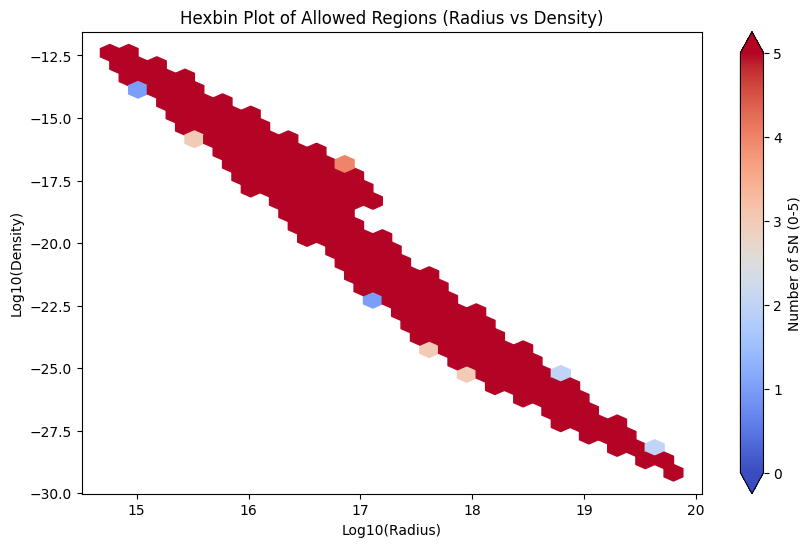

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import ascii
from matplotlib.colors import Normalize

def process_file(file_name):
    """
    Reads a file, filters data based on conditions, and returns the relevant data with bin values and SN name.
    """
    data = ascii.read(file_name)
    
    # Extract the necessary columns: F_p, nu_p, den (density), Radius, and RuledOut status
    F_peak = data['F_peak']
    nu_peak = data['nu_peak']
    density = data['den']  # Assuming 'den' is the column for density
    radius = data['Radius']  # Assuming 'Radius' is the column for radius
    ruled_out = data['RuledOut'] == 'False'  # This will return a boolean array for ruled-out 
    
    # Get the allowed SN data
    allowed_radius = radius[ruled_out]
    allowed_density = density[ruled_out]
    
    # Bin the Radius and Density data into corresponding bins
    radius_bins = np.logspace(np.log10(min(radius)), np.log10(max(radius)), num=50)
    density_bins = np.logspace(np.log10(min(density)), np.log10(max(density)), num=50)
    
    # Get the bin indices for each SN
    radius_indices = np.digitize(allowed_radius, bins=radius_bins) - 1
    density_indices = np.digitize(allowed_density, bins=density_bins) - 1
    
    # Create a DataFrame to store the data, including the bin values and SN names
    sn_data = {
        'Radius': allowed_radius,
        'Density': allowed_density,
        'File': [file_name] * len(allowed_radius),  # Store the SN's file name
        'Radius_bin': radius_indices,
        'Density_bin': density_indices
    }
    
    return pd.DataFrame(sn_data)

# Process all files (replace with actual filenames in your case)
file_names = ['PS11ad.csv', 'PS12cht.csv', 'PS10acl.csv', 'PS11jf.csv', 'PS12zc.csv']
all_sn_data = []

# Process each file and store data in DataFrame
for file_name in file_names:
    sn_data = process_file(file_name)
    all_sn_data.append(sn_data)

# Concatenate all the data into one DataFrame
all_sn_df = pd.concat(all_sn_data, ignore_index=True)

# Example: view the first few rows of the concatenated data
#print(all_sn_df.head())

# To calculate the number of SN per bin, we'll create a grid for radius and density bins
radius_bins = np.logspace(np.log10(min(all_sn_df['Radius'])), np.log10(max(all_sn_df['Radius'])), num=50)
density_bins = np.logspace(np.log10(min(all_sn_df['Density'])), np.log10(max(all_sn_df['Density'])), num=50)

# Create a 2D array to count SN per bin
bin_counts = np.zeros((len(radius_bins) - 1, len(density_bins) - 1))

# Count the number of SN per bin
for _, row in all_sn_df.iterrows():
    radius_bin_idx = row['Radius_bin']
    density_bin_idx = row['Density_bin']
    if 0 <= radius_bin_idx < len(radius_bins) - 1 and 0 <= density_bin_idx < len(density_bins) - 1:
        bin_counts[radius_bin_idx, density_bin_idx] += 1

# Now create a hexbin plot based on the counts in the bins
plt.figure(figsize=(10, 6))

# Create the hexbin plot with color normalization (limits from 0 to 5)
norm = Normalize(vmin=0, vmax=5)

# Hexbin plot
#plt.xscale('log')
#plt.yscale('log')

#hb = plt.hexbin(all_sn_df['Radius'], all_sn_df['Density'],
#    gridsize=30, cmap='coolwarm', mincnt=1, bins='log', norm=norm
#)

hb = plt.hexbin(
    np.log10(all_sn_df['Radius']), np.log10(all_sn_df['Density']),
    gridsize=30, cmap='coolwarm', mincnt=1, bins='log', norm=norm
)

# Colorbar with limits from 0 to 5
plt.colorbar(hb, label='Number of SN (0-5)', extend='both')

# Add labels and title
plt.xlabel('Log10(Radius)')
plt.ylabel('Log10(Density)')
plt.title('Hexbin Plot of Allowed Regions (Radius vs Density)')

# Show the plot
plt.show()


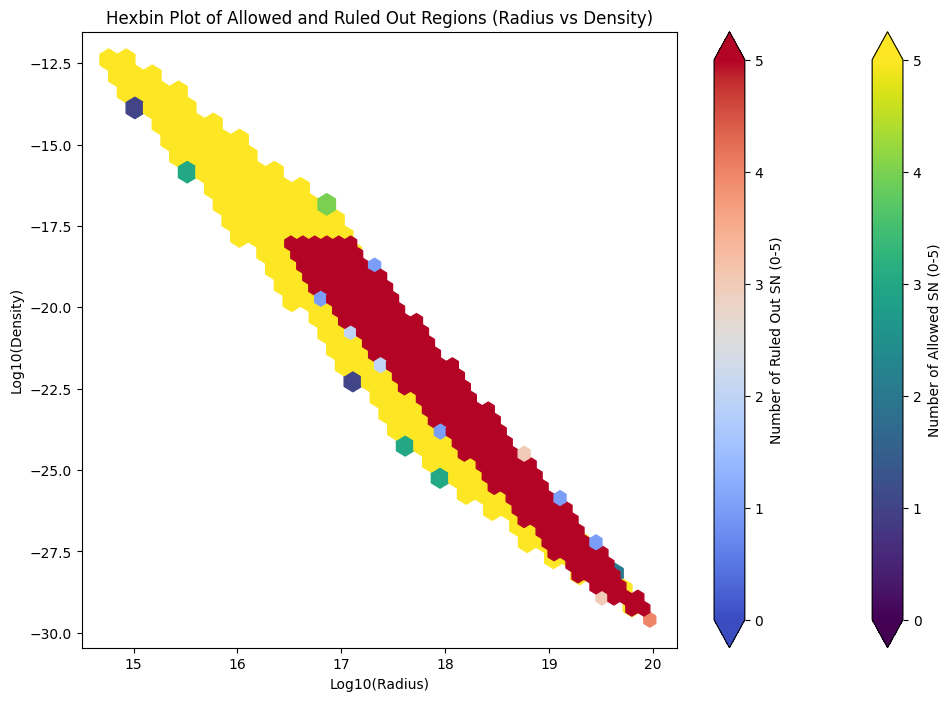

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import ascii
from matplotlib.colors import Normalize

def process_file(file_name):
    """
    Reads a file, filters data based on conditions, and returns the relevant data with bin values and SN name.
    """
    data = ascii.read(file_name)
    
    # Extract the necessary columns: F_p, nu_p, den (density), Radius, and RuledOut status
    F_peak = data['F_peak']
    nu_peak = data['nu_peak']
    density = data['den']  # Assuming 'den' is the column for density
    radius = data['Radius']  # Assuming 'Radius' is the column for radius
    ruled_out = data['RuledOut'] == 'False'  # This will return a boolean array for ruled-out supernovae
    
    # Get both allowed and ruled-out SN data
    allowed_radius = radius[ruled_out]
    allowed_density = density[ruled_out]
    
    ruled_radius = radius[~ruled_out]
    ruled_density = density[~ruled_out]
    
    # Bin the Radius and Density data into corresponding bins
    radius_bins = np.logspace(np.log10(min(radius)), np.log10(max(radius)), num=50)
    density_bins = np.logspace(np.log10(min(density)), np.log10(max(density)), num=50)
    
    # Get the bin indices for allowed and ruled-out SN
    allowed_radius_indices = np.digitize(allowed_radius, bins=radius_bins) - 1
    allowed_density_indices = np.digitize(allowed_density, bins=density_bins) - 1
    
    ruled_radius_indices = np.digitize(ruled_radius, bins=radius_bins) - 1
    ruled_density_indices = np.digitize(ruled_density, bins=density_bins) - 1
    
    # Create a DataFrame to store the data, including the bin values and SN names
    sn_data = {
        'Radius': np.concatenate([allowed_radius, ruled_radius]),
        'Density': np.concatenate([allowed_density, ruled_density]),
        'File': [file_name] * (len(allowed_radius) + len(ruled_radius)),  # Store the SN's file name
        'Radius_bin': np.concatenate([allowed_radius_indices, ruled_radius_indices]),
        'Density_bin': np.concatenate([allowed_density_indices, ruled_density_indices]),
        'Ruled_out': np.concatenate([np.full_like(allowed_radius, False), np.full_like(ruled_radius, True)]),
    }
    
    return pd.DataFrame(sn_data)

# Process all files (replace with actual filenames in your case)
file_names = ['PS11ad.csv', 'PS12cht.csv', 'PS10acl.csv', 'PS11jf.csv', 'PS12zc.csv']
all_sn_data = []

# Process each file and store data in DataFrame
for file_name in file_names:
    sn_data = process_file(file_name)
    all_sn_data.append(sn_data)

# Concatenate all the data into one DataFrame
all_sn_df = pd.concat(all_sn_data, ignore_index=True)

# Example: view the first few rows of the concatenated data
#print(all_sn_df.head())

# To calculate the number of SN per bin, we'll create a grid for radius and density bins
radius_bins = np.logspace(np.log10(min(all_sn_df['Radius'])), np.log10(max(all_sn_df['Radius'])), num=50)
density_bins = np.logspace(np.log10(min(all_sn_df['Density'])), np.log10(max(all_sn_df['Density'])), num=50)

# Create a 2D array to count SN per bin
bin_counts_allowed = np.zeros((len(radius_bins) - 1, len(density_bins) - 1))
bin_counts_ruled_out = np.zeros((len(radius_bins) - 1, len(density_bins) - 1))

# Count the number of SN per bin for allowed and ruled-out regions
for _, row in all_sn_df.iterrows():
    radius_bin_idx = row['Radius_bin']
    density_bin_idx = row['Density_bin']
    
    if 0 <= radius_bin_idx < len(radius_bins) - 1 and 0 <= density_bin_idx < len(density_bins) - 1:
        if row['Ruled_out']:  # If the SN is ruled out
            bin_counts_ruled_out[radius_bin_idx, density_bin_idx] += 1
        else:  # If the SN is allowed
            bin_counts_allowed[radius_bin_idx, density_bin_idx] += 1

# Now create a hexbin plot based on the counts in the bins for both allowed and ruled-out regions
plt.figure(figsize=(12, 8))

# Create the hexbin plot for allowed SN
hb_allowed = plt.hexbin(
    np.log10(all_sn_df[all_sn_df['Ruled_out'] == False]['Radius']),
    np.log10(all_sn_df[all_sn_df['Ruled_out'] == False]['Density']),
    gridsize=30, cmap='viridis', mincnt=1, norm=Normalize(vmin=0, vmax=5)
)

# Create the hexbin plot for ruled-out SN
hb_ruled_out = plt.hexbin(
    np.log10(all_sn_df[all_sn_df['Ruled_out'] == True]['Radius']),
    np.log10(all_sn_df[all_sn_df['Ruled_out'] == True]['Density']),
    gridsize=30, cmap='coolwarm', mincnt=1, norm=Normalize(vmin=0, vmax=5)
)

# Colorbar for both plots
plt.colorbar(hb_allowed, label='Number of Allowed SN (0-5)', extend='both')
plt.colorbar(hb_ruled_out, label='Number of Ruled Out SN (0-5)', extend='both')

# Add labels and title
plt.xlabel('Log10(Radius)')
plt.ylabel('Log10(Density)')
plt.title('Hexbin Plot of Allowed and Ruled Out Regions (Radius vs Density)')

# Show the plot
plt.show()


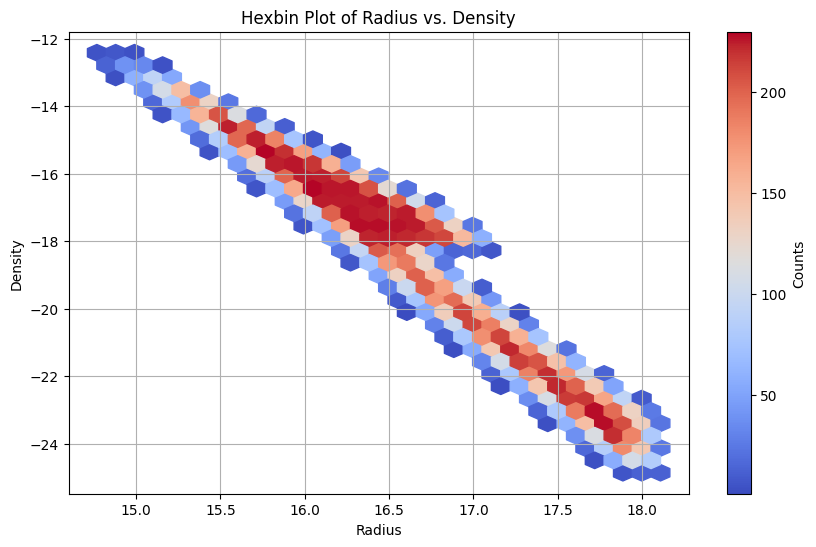

In [32]:
# Combine all data for Hexbin plot
all_radius = np.concatenate([Radius_v, Radius_vb, Radius_vc, Radius_vd, Radius_ve])
all_density = np.concatenate([density_v, density_vb, density_vc, density_vd, density_ve])

# Hexbin Plot
plt.figure(figsize=(10, 6))
hb = plt.hexbin(np.log10(all_radius), np.log10(all_density), gridsize=30, cmap='coolwarm', mincnt=1)
plt.colorbar(hb, label='Counts')
plt.xlabel("Radius")
plt.ylabel("Density")
plt.title("Hexbin Plot of Radius vs. Density")
plt.grid(True)
plt.show()


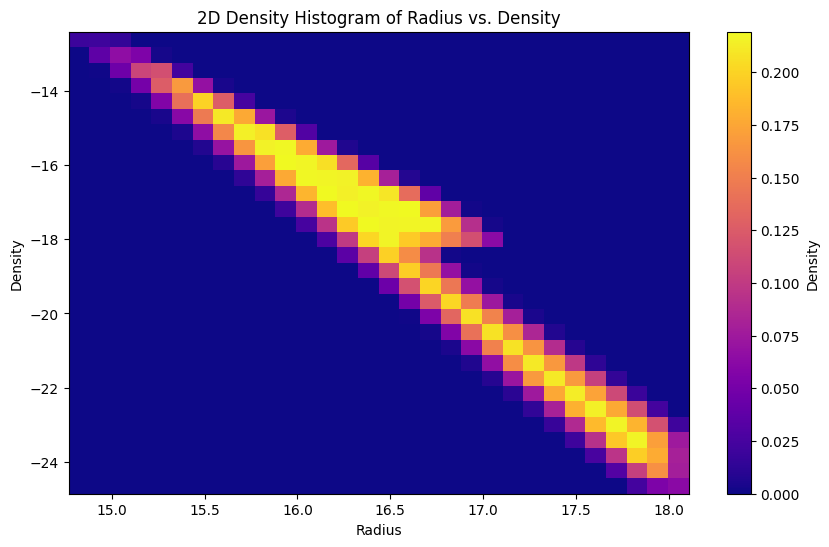

In [27]:
# 2D Density Histogram
plt.figure(figsize=(10, 6))
plt.hist2d(np.log10(all_radius), np.log10(all_density), bins=(30, 30), cmap='plasma', density=True)
plt.colorbar(label='Density')
plt.xlabel('Radius')
plt.ylabel('Density')
plt.title('2D Density Histogram of Radius vs. Density')
#plt.grid(True)
plt.show()


In [3]:
#Run some model
### Define parameters that are specific to the supernova you want to model:###

t_p = 1224.288326 #(date_obs - date_expl)/(1+redshift) # time of observation in days #1261.509031#
D_L = 2337.2 # distance to SN in Mpc
z = 0.422
F_ul = [0.6,0.0272]
nu_ul = np.array([3,9])*(1+z)
### Define the grid of F_p and nu_p that you want to search over:###
F_p = np.logspace(np.log10(0.001),np.log10(10.0),num=100) #mJy (this is an array evenly spaced in log between 0.01 annd 1)
nu_p = np.logspace(np.log10(0.05),np.log10(50),num=100) #GHz (this is an array evenly spaced in log between 0.5 annd 50)
file_out = 'PS11ad.csv' #File that you will save the results in.

### Define array of frequencies to calculate the SSA and SSA+FFA spectrum at ###
#nu_sed = np.array([0.5,0.7,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
nu_sed=np.logspace(np.log10(0.1),np.log10(50),num=100)

### Define empty arrays of the values that you want to save for each value in the grid you are searching over: ###
Fp_g = [] #peak flux
nup_g =[] #peak frequency
R_g =[] #radius
B_g = [] #Bfield
vsh_g = [] #velocity of shock
M_g = [] #mass loss rate
den_g = []
RuledOut_g = [] #flag for whether it is ruled out

######### SEARCH OVER GRID ############

for F in F_p:
    for nu in nu_p:
        #calculate SSA
        SSA_sed = F_nu(t_p,nu,F,nu_sed)
        
        #calculate Mass loss rate, Radius, velocity, etc.
        R,B,E,v,M = SSA_props(t_p,nu,F,D_L)
        
        #calculate the density of the CSM
        density = den(M,R)
       
        #calculate tau_ff
        tauff = taufreefree(M,R,nu_sed)
        
        #Correct SED for FFA:
        SSA_FFA_sed = SSA_sed*np.exp(-tauff)
        
        
        #Evaluate if this SED is allowed:
        RuledOut = False #Assume a default position that this combination is allowed.
        
        #First loop over the upper limits and see if any of them rule it out.
        for i in range(len(F_ul)):
            freq = nu_ul[i]
            flux = F_ul[i]
            #Interpolate this SSA+FFA to the frequency of your data point:
            flux_test1 = np.interp(nu_ul[i], nu_sed, SSA_FFA_sed)
            if np.any(flux_test1 > flux):
                RuledOut = True
                break

      
            
        # Append the values from this loop into the arrays that we defined above:
        
        Fp_g.append(F) 
        nup_g.append(nu) 
        R_g.append(R) 
        B_g.append(B) 
        vsh_g.append(v) 
        M_g.append(M) 
        den_g.append(density)
        RuledOut_g.append(RuledOut) 
 
        #It will now go on to the next set in the loop:
    
# Now it has gone over the whole loop. So write out the results into a data file that you can use later:
data = [Fp_g,nup_g,R_g,B_g,vsh_g,M_g,den_g,RuledOut_g]
names = ['F_peak','nu_peak','Radius','Bfield','v_shock','Mdot','den','RuledOut']
ascii.write(data,file_out,names=names,overwrite=True,format='csv')

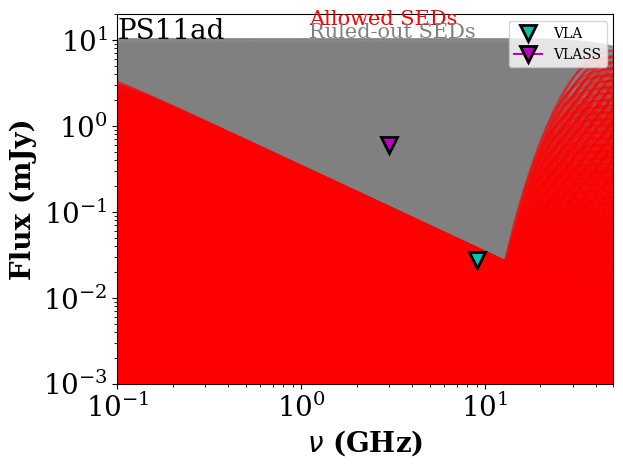

6729
3271


In [4]:
file_in = 'PS11ad.csv' #R4_vlassbright.csv
data_plot = ascii.read(file_in)

t_p = 1224.288326 # time of observation in days 
D = 2337.2 
z = 0.422
D_L = 2337.2 
plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 20})
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)

#Not Allowed
index = np.where(data_plot['RuledOut'] == 'True')[0]
data_plot1 = data_plot[index]
##overplot the SEDs with v_shock < 20,000km/s
Fcalc = data_plot1['F_peak']#[data_plot1['v_shock'] <= 100000]
nucalc = data_plot1['nu_peak']#[data_plot1['v_shock'] <= 100000]
nu_sed=np.logspace(np.log10(0.1),np.log10(50),num=100)
#nu_sed = np.array([0.5,0.7,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
###Cycle over the SEDs to show######
for i in range(len(Fcalc)):
   #calculate SSA
    SSA_sed = F_nu(t_p,nucalc[i],Fcalc[i],nu_sed)
    
    #calculate Mass loss rate, Radius, velocity, etc.
    R,B,E,v,M = SSA_props(t_p,nucalc[i],Fcalc[i],D)

    #calculate tau_ff
    tauff = taufreefree(M,R,nu_sed)
        
    #Correct SED for FFA:
    SSA_FFA_sed = SSA_sed*np.exp(-tauff)
    
    #Plot it:
    plt.plot(nu_sed,SSA_FFA_sed,'gray',zorder=1,alpha=0.5)

#Allowed
##overplot the SEDs with v_shock < 20,000km/s
indexa = np.where(data_plot['RuledOut'] == 'False')[0]
data_plota = data_plot[indexa]
Fcalc_v = data_plota['F_peak']#[data_plota['v_shock'] <= 100000]
nucalc_v = data_plota['nu_peak']#[data_plota['v_shock'] <= 100000]
nu_sed=np.logspace(np.log10(0.1),np.log10(50),num=100)
#nu_sed = np.array([0.5,0.7,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])

###Cycle over the SEDs to show######
for i in range(len(Fcalc_v)):
    #calculate SSA
    SSA_sedv = F_nu(t_p,nucalc_v[i],Fcalc_v[i],nu_sed)
    
    #calculate Mass loss rate, Radius, velocity, etc.
    Ra,Ba,Ea,va,Ma = SSA_props(t_p,nucalc_v[i],Fcalc_v[i],D_L)

    #calculate tau_ff
    tauffv = taufreefree(Ma,Ra,nu_sed)
        
    #Correct SED for FFA:
    SSA_FFA_sedv = SSA_sedv*np.exp(-tauffv)
    
    #Plot it:
    plt.plot(nu_sed,SSA_FFA_sedv,'r',zorder=1,alpha=0.5)
    
#Overplot the data: 0.65149
plt.plot(9,0.0272,'v',color='xkcd:turquoise',markersize=12,markeredgecolor='k',markeredgewidth=2, label='VLA')
#subplots[0].plot(3,0.70982,marker = 'v',color='xkcd:turquoise',markersize=12,markeredgecolor='k',markeredgewidth=2, label='VLASS up')#'ro', markersize=10)
plt.plot(3,0.60,marker = 'v',color='m',markersize=12,markeredgecolor='k',markeredgewidth=2,label='VLASS')
plt.text(1.1,15,'Allowed SEDs',color='r',fontsize =15)
plt.text(1.1,10.6,'Ruled-out SEDs',color='gray',fontsize =15)
plt.text(0.1,10.2,'PS11ad',color='k',fontsize =20)
plt.xscale('log')
plt.yscale('log')

plt.ylabel('Flux (mJy)', fontweight='bold', fontsize=20) 
plt.xlabel(r'$\nu$ (GHz)', fontweight='bold', fontsize=20) 
#subplots[0].title.set_fontsize(16) 
plt.ylim(0.001,20)
plt.xlim(0.1,50)
plt.legend(fontsize=10, loc = 'upper right')
plt.show()
print(len(data_plota))
print(len(data_plot1))
#plt.savefig("sn-ejecta.jpeg",dpi=300,bbox_inches='tight')

In [11]:
file_in = 'PS11ad.csv'
data_plot = ascii.read(file_in)

indexa = np.where(data_plot['RuledOut'] == 'False')[0]
data_plota = data_plot[indexa]
indexb = np.where(data_plot['RuledOut'] == 'True')[0]
data_plotb = data_plot[indexb]
indexc = np.where(data_plota['Radius'] < 4e15)[0] #based on allowed SED
data_plotc = data_plota[indexc]
indexd = np.where((data_plota['v_shock'] > 2e4) & (data_plota['v_shock'] < 3e6))[0] #based on allowed sed
data_plotd = data_plota[indexd]
indexe = np.where(data_plota['v_shock'] < 1500)[0] #based on allowed sed
data_plote = data_plota[indexe]
indexf = np.where((data_plota['Radius'] < 2e16) & (data_plota['Radius'] > 4e15))[0] #based on allowed SED
data_plotf = data_plota[indexf]

indexg = np.where(data_plota['v_shock'] > 3e6)[0] #based on allowed SED
data_plotg = data_plota[indexg]

Fcalca = data_plota['F_peak']
nucalca = data_plota['nu_peak']
Fcalcb = data_plotb['F_peak']
nucalcb = data_plotb['nu_peak']
Fcalcc = data_plotc['F_peak']
nucalcc = data_plotc['nu_peak']

Fcalcd = data_plotd['F_peak']
nucalcd = data_plotd['nu_peak']

Fcalce = data_plote['F_peak']
nucalce = data_plote['nu_peak']

Fcalcf = data_plotf['F_peak']
nucalcf = data_plotf['nu_peak']
Fcalcg = data_plotg['F_peak']
nucalcg = data_plotg['nu_peak']

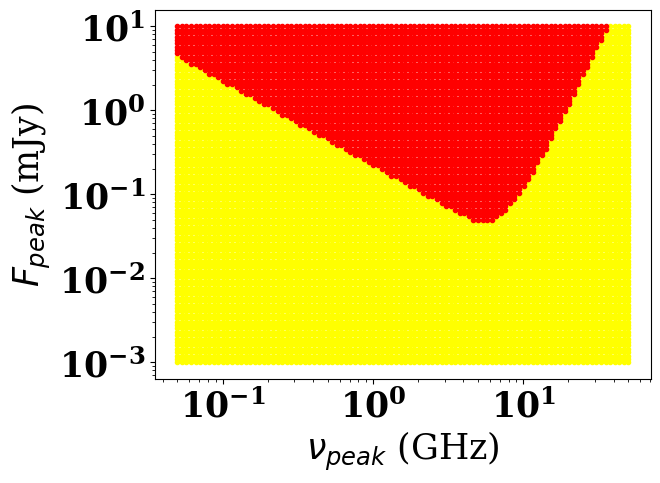

In [12]:
plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 20})
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.rc('font', weight='bold')

plt.plot(nucalca,Fcalca,'.',color='yellow')#,label='allowed SED')
plt.plot(nucalcb,Fcalcb,'.',color='red',label='Not allowed SED')
#plt.plot(nucalcg,Fcalcg,'.',color='tomato',label=r'v = R/t > speed of light')
#plt.plot(nucalcd,Fcalcd,'.',color='pink',label='v = R/t > 2e4 km/s')
#plt.plot(nucalce,Fcalce,'.',color='green',alpha=0.2,label='v = R/t < 1500 km/s')
#plt.plot(nucalcf,Fcalcf,'.',color='yellow',alpha=0.5,label='4e15 < Radius < 2e16 cm')
#plt.plot(nucalcc,Fcalcc,'.',color='orange',alpha=0.5,label='Radius < 4e15 cm')

#Add label
#plt.text(0.02,15,r'Ruled out by radio', color='white')
#plt.text(0.1,3,r'upper limits',color='white')

#plt.text(0.3, 1e-6, r'$4\times10^{15} <$ $R_{CSM}$ $< 2\times10^{16} cm$', color='gray',rotation=50, rotation_mode='anchor')
#plt.text(2, 1e-6, r'$R_{CSM}$ $< 4\times10^{15} cm$', color='white',rotation=50, rotation_mode='anchor')
#plt.text(3e-3, 0.1, r'$v > c$', color='white',rotation=50, rotation_mode='anchor')
#plt.text(2e-3, 1e-5, r'$c < v < 2\times10^{4}$', color='white',rotation=50, rotation_mode='anchor')
#plt.text(3e-2, 4e-4, r'$(km$ $s^{-1})$', color='white',rotation=50, rotation_mode='anchor')

plt.xscale('log')
plt.yscale('log')
plt.tick_params(labelsize = 25)
plt.xlabel(r'$\nu_{peak}$ (GHz)',fontsize=25)
plt.ylabel(r'$F_{peak}$ (mJy)',fontsize=25)
#plt.savefig('flux-freq-limit.png',bbox_inches='tight',dpi = 500, transparent = True)
#plt.legend()
plt.show()

In [13]:
indexa = np.where(data_plot['RuledOut'] == 'False')[0]
data_plota = data_plot[indexa]
indexb = np.where(data_plot['RuledOut'] == 'True')[0]
data_plotb = data_plot[indexb]
indexc = np.where(data_plota['Radius'] < 4e15)[0] #based on allowed SED
data_plotc = data_plota[indexc]
indexd = np.where((data_plota['v_shock'] > 2e4) & (data_plota['v_shock'] < 3e6))[0] #based on allowed sed
data_plotd = data_plota[indexd]
indexe = np.where(data_plota['v_shock'] < 1500)[0] #based on allowed sed
data_plote = data_plota[indexe]
indexf = np.where((data_plota['Radius'] < 2e16) & (data_plota['Radius'] > 4e15))[0] #based on allowed SED
data_plotf = data_plota[indexf]

indexg = np.where(data_plota['v_shock'] > 3e6)[0] #based on allowed SED
data_plotg = data_plota[indexg]

v1 = data_plota['v_shock']
M1 = data_plota['Mdot']
v2 = data_plotb['v_shock']
M2 = data_plotb['Mdot']
v3 = data_plotc['v_shock']
M3 = data_plotc['Mdot']

v4 = data_plotd['v_shock']
M4 = data_plotd['Mdot']

v5 = data_plote['v_shock']
M5 = data_plote['Mdot']

v6 = data_plotf['v_shock']
M6 = data_plotf['Mdot']
v7 = data_plotg['v_shock']
M7 = data_plotg['Mdot']

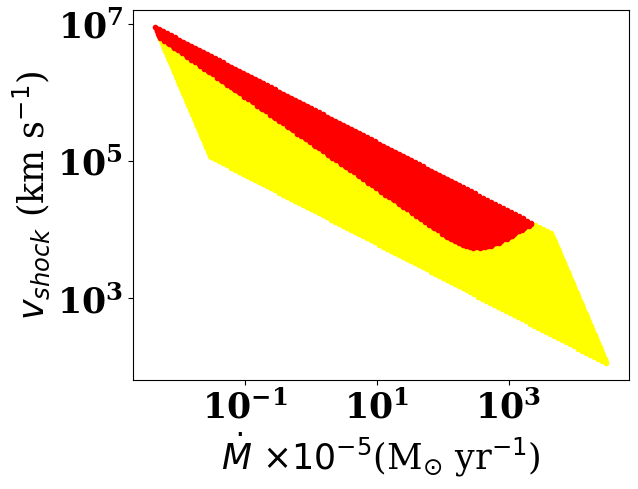

In [14]:
plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 20})
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.rc('font', weight='bold')

plt.plot(M1,v1,'.',color='yellow')#,label='allowed SED')
plt.plot(M2,v2,'.',color='red',label='Ruled out SED')
#plt.plot(M7,v7,'.',color='tomato',label=r'v = R/t > speed of light')
#plt.plot(M4,v4,'.',color='pink',label=r'v = R/t > 2 $\times$ $10^{4}$ km/s')
#plt.plot(M5,v5,'.',color='green',alpha=0.2,label='v = R/t < 1500 km/s')
#plt.plot(M6,v6,'.',color='yellow',alpha=0.2,label=r'4 $\times$ $10^{15}$ < $R_{CSM}$ < 2 $\times$ $10^{16}$ cm')
#plt.plot(M3,v3,'.',color='orange',alpha=0.2,label=r'$R_{CSM}$ < 4 $\times$ $10^{15}$ cm')
plt.xscale('log')
plt.yscale('log')
plt.tick_params(labelsize = 25)
plt.xlabel(r'$\.{M}$ $\times 10^{-5}$(M$_{\odot}$ yr$^{-1}$)',fontsize=25)
plt.ylabel(r'$v_{shock}$ (km s$^{-1}$)',fontsize=25)
#plt.legend(fontsize = 10)
#plt.savefig('v-Mdot-limit.png',bbox_inches='tight',dpi = 500, transparent = True)
plt.show()

In [20]:
#PS11ad
#Synchrotron model of the fluxes
import numpy as np
#plt.rc('text', usetex=True)

t =1224.288326 
t_p = 1224.288326 #days
nu =np.arange(1, 100, dtype=float)
nu_p = 10 #GHz
F_nup = 0.0272 #mjansky 2.72E-05
m = 0.88 #using stAandard model
p = 3.0 #using standard model
a = (2*m)+0.5
b = (p+5-(6*m))/2

F_nu = F_nup*1.582*(t/t_p)**a*(nu/nu_p)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p)**(-(p+4)/2)))

print(F_nu)                  

#plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(8,5))
#plt.ylim(0.0001400,0.01570)
plt.xlim(2, 30)
plt.xscale('log')
plt.yscale('log')
ax=plt.subplot(111)
plt.plot(8,0.0272, 'mv', markersize=10) #label = 'SN1988I') #

plt.plot(nu,F_nu, label ='PS11ad')
plt.xlabel(r'$\nu$ (GHz)', fontsize=20) #Log$_{10}$ t$_{rest}$(days)($\u03BD$ /5 GHz)', fontsize=14)
plt.ylabel('Flux (mJy)', fontsize=20) #Log$_{10}$ Luminosity (erg $s^{-1}$ $Hz^{-1}$)', fontsize =14)
#plt.legend(frameon=True, framealpha=0.1, loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='lower left')# bbox_to_anchor=(1, 0.5))
#plt.show()
plt.savefig('synPS11ad.pdf')

[0.00013607 0.00076975 0.00212118 0.00435437 0.00760668 0.01196879
 0.01709993 0.02185777 0.02527817 0.0272004  0.0279303  0.02785593
 0.02729137 0.02645338 0.02548058 0.02445782 0.0234352  0.0224412
 0.021491   0.02059176 0.01974587 0.01895292 0.01821095 0.01751718
 0.01686846 0.01626157 0.01569332 0.0151607  0.01466086 0.0141912
 0.01374929 0.01333295 0.01294015 0.01256908 0.01221808 0.01188563
 0.01157036 0.01127102 0.01098648 0.01071569 0.01045771 0.01021167
 0.00997678 0.00975232 0.00953762 0.00933207 0.0091351  0.00894619
 0.00876488 0.0085907  0.00842327 0.00826219 0.00810711 0.00795771
 0.00781369 0.00767476 0.00754066 0.00741115 0.00728598 0.00716496
 0.00704788 0.00693454 0.00682478 0.00671843 0.00661534 0.00651535
 0.00641832 0.00632414 0.00623268 0.00614381 0.00605744 0.00597346
 0.00589177 0.00581228 0.0057349  0.00565956 0.00558616 0.00551464
 0.00544492 0.00537694 0.00531064 0.00524595 0.00518281 0.00512118
 0.00506099 0.00500219 0.00494475 0.00488861 0.00483373 0.004780

In [25]:
#PS11ad
#Radius at time t_p in centimeters
alpha = 1  #fraction of charged particles and magnetic field (epsilon_e/epsilon_b)
f =  0.5   # filling factor (fraction of the emitting region)
D =   2337.2  # in Mpc distance to the SN

R = 4.0e14*(alpha)**(-1/19)*(f/0.5)**(-1/19)*(F_nup)**(9/19)*(D)**(18/19)*(nu_p/5)**(-1)

# Magnetic field flux
B = 1.1*(alpha)**(-4/19)*(f/0.5)**(-4/19)*(F_nup)**(-2/19)*(D)**(-4/19)*(nu_p/5)

#Internal energy of the emitting material
epsilon_b = 0.1
E = (1/epsilon_b)*((B**2)/(8* 3.142))*((4*3.142*f*R**3)/3)

#expansion velocity in km/s
v = (R/t)*1.1574e-10

#pre-explosion mass-loss in 1e-5 solar mass per year
v_w = 100  #wind speed in km/s
M = 0.925*(alpha)**(-8/19)*(epsilon_b/0.1)**(-1)*(f/0.5)**(-8/19)*(F_nup)**(-4/19)*(D)**(-8/19)*(nu_p/5)**(2)*(t_p/10)**(2)*(v_w/1000)

vw_cgs = 100 * 1e5
M_cgs =  M * 1e-5 * 6.307e+25 #mass loss rate in cgs units 
#density of the CSM
density = M_cgs/(4*3.142*R**2*vw_cgs)

print (R)
print (B)
print(E)
print(v)
print(M)
print(density)

5.635158000392043e+16
0.6280667022098954
5.882319164929477e+49
5327.284211688016
451.99675591654017
7.142985719487117e-19


[5.25285942e-05 2.97146601e-04 8.18839746e-04 1.68091501e-03
 2.93640185e-03 4.62030619e-03 6.60107622e-03 8.43774124e-03
 9.75811651e-03 1.05001546e-02 1.07819190e-02 1.07532083e-02
 1.05352710e-02 1.02117809e-02 9.83625477e-03 9.44143673e-03
 9.04667639e-03 8.66296194e-03 8.29615660e-03 7.94902494e-03
 7.62248610e-03 7.31638449e-03 7.02996193e-03 6.76214574e-03
 6.51172295e-03 6.27744424e-03 6.05808435e-03 5.85247558e-03
 5.65952471e-03 5.47821993e-03 5.30763165e-03 5.14690993e-03
 4.99527992e-03 4.85203646e-03 4.71653838e-03 4.58820272e-03
 4.46649937e-03 4.35094597e-03 4.24110318e-03 4.13657048e-03
 4.03698231e-03 3.94200456e-03 3.85133149e-03 3.76468294e-03
 3.68180184e-03 3.60245196e-03 3.52641593e-03 3.45349347e-03
 3.38349978e-03 3.31626415e-03 3.25162861e-03 3.18944686e-03
 3.12958320e-03 3.07191160e-03 3.01631492e-03 2.96268408e-03
 2.91091745e-03 2.86092021e-03 2.81260378e-03 2.76588536e-03
 2.72068745e-03 2.67693744e-03 2.63456723e-03 2.59351289e-03
 2.55371436e-03 2.515115

/usr/lib/python3/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


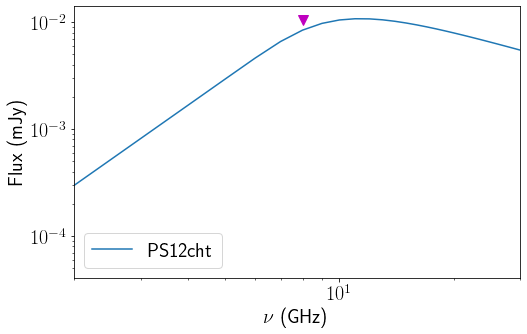

In [14]:
#PS1-12cht
#Synchrotron model of the fluxes
import numpy as np
plt.rc('text', usetex=True)

t =  948.460801393727 
t_p =  948.460801393727 #days
nu =np.arange(1, 100, dtype=float)
nu_p = 10 #GHz
F_nup = 0.0105 #mjansky 2.72E-05
m = 0.88 #using stAandard model
p = 3.0 #using standard model
a = (2*m)+0.5
b = (p+5-(6*m))/2

F_nu = F_nup*1.582*(t/t_p)**a*(nu/nu_p)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p)**(-(p+4)/2)))

print(F_nu)                  

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(8,5))
#plt.ylim(0.0001400,0.01570)
plt.xlim(2, 30)
plt.xscale('log')
plt.yscale('log')
ax=plt.subplot(111)
plt.plot(8,0.0105, 'mv', markersize=10) 
plt.plot(nu,F_nu, label ='PS12cht')
plt.xlabel(r'$\nu$ (GHz)', fontsize=20) #Log$_{10}$ t$_{rest}$(days)($\u03BD$ /5 GHz)', fontsize=14)
plt.ylabel('Flux (mJy)', fontsize=20) #Log$_{10}$ Luminosity (erg $s^{-1}$ $Hz^{-1}$)', fontsize =14)
plt.legend(frameon=True, framealpha=0.1, loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='lower left') #, bbox_to_anchor=(1, 0.5))
#plt.show()
plt.savefig('synPS12cht.pdf')


In [15]:
#PS12cht
#Radius at time t_p in centimeters
alpha = 1  #fraction of charged particles and magnetic field (epsilon_e/epsilon_b)
f =  0.5   # filling factor (fraction of the emiting region)
D = 707.9     # in Mpc distance to the SN

R = 4.0e14*(alpha)**(-1/19)*(f/0.5)**(-1/19)*(F_nup)**(9/19)*(D)**(18/19)*(nu_p/5)**(-1)

# Magnetic field flux
B = 1.1*(alpha)**(-4/19)*(f/0.5)**(-4/19)*(F_nup)**(-2/19)*(D)**(-4/19)*(nu_p/5)

#Internal energy of the emitting material
epsilon_b = 0.1
E = (1/epsilon_b)*((B**2)/(8* 3.142))*((4*3.142*f*R**3)/3)

#expansion velocity in km/s
v = (R/t)*1.1574e-10

#pre-explosion mass-loss in 1e-5 solar mass per year
v_w = 1000  #wind speed in km/s
M = 1.0*(alpha)**(-8/19)*epsilon_b*(f)**(-8/19)*(F_nup)**(-4/19)*(D)**(-4/19)*(nu_p/5)*(t_p/10)*(v_w/1000)

print (R)
print (B)
print(E)
print(v)
print(M)


1.1579025267510604e+16
0.892738896377307
1.03105937014855e+48
1412.9802544210247
16.649319750422574


[8.75476570e-05 4.95244336e-04 1.36473291e-03 2.80152502e-03
 4.89400308e-03 7.70051032e-03 1.10017937e-02 1.40629021e-02
 1.62635275e-02 1.75002577e-02 1.79698649e-02 1.79220138e-02
 1.75587851e-02 1.70196349e-02 1.63937580e-02 1.57357279e-02
 1.50777940e-02 1.44382699e-02 1.38269277e-02 1.32483749e-02
 1.27041435e-02 1.21939741e-02 1.17166032e-02 1.12702429e-02
 1.08528716e-02 1.04624071e-02 1.00968073e-02 9.75412597e-03
 9.43254119e-03 9.13036655e-03 8.84605276e-03 8.57818322e-03
 8.32546653e-03 8.08672744e-03 7.86089729e-03 7.64700453e-03
 7.44416562e-03 7.25157661e-03 7.06850529e-03 6.89428414e-03
 6.72830385e-03 6.57000760e-03 6.41888582e-03 6.27447157e-03
 6.13633640e-03 6.00408659e-03 5.87735988e-03 5.75582244e-03
 5.63916631e-03 5.52710691e-03 5.41938102e-03 5.31574477e-03
 5.21597199e-03 5.11985267e-03 5.02719153e-03 4.93780680e-03
 4.85152909e-03 4.76820034e-03 4.68767296e-03 4.60980894e-03
 4.53447909e-03 4.46156241e-03 4.39094538e-03 4.32252148e-03
 4.25619060e-03 4.191858

/usr/lib/python3/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


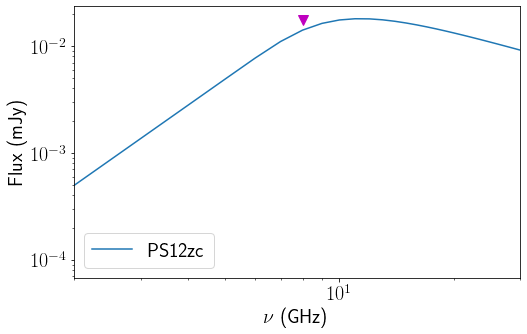

In [16]:
#PS12zc
#Synchrotron model of the fluxes
import numpy as np
plt.rc('text', usetex=True)

t =1091.92948586118
t_p = 1091.92948586118 #days
nu =np.arange(1, 100, dtype=float)
nu_p = 10 #GHz
F_nup = 0.0175 #mjansky 
m = 0.88 #using stAandard model
p = 3.0 #using standard model
a = (2*m)+0.5
b = (p+5-(6*m))/2

F_nu = F_nup*1.582*(t/t_p)**a*(nu/nu_p)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p)**(-(p+4)/2)))

print(F_nu)                  

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(8,5))
#plt.ylim(0.0001400,0.01570)
plt.xlim(2, 30)
plt.xscale('log')
plt.yscale('log')
ax=plt.subplot(111)
plt.plot(8,0.0175, 'mv', markersize=10) 
plt.plot(nu,F_nu, label ='PS12zc')
plt.xlabel(r'$\nu$ (GHz)', fontsize=20) #Log$_{10}$ t$_{rest}$(days)($\u03BD$ /5 GHz)', fontsize=14)
plt.ylabel('Flux (mJy)', fontsize=20) #Log$_{10}$ Luminosity (erg $s^{-1}$ $Hz^{-1}$)', fontsize =14)
plt.legend(frameon=True, framealpha=0.1, loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='lower left') #, bbox_to_anchor=(1, 0.5))
#plt.show()
plt.savefig('synPS12zc.pdf')


In [17]:
#PS12zc
#Radius at time t_p in centimeters
alpha = 1  #fraction of charged particles and magnetic field (epsilon_e/epsilon_b)
f =  0.5   # filling factor (fraction of the emiting region)
D =  808.4  # in Mpc distance to the SN

R = 4.0e14*(alpha)**(-1/19)*(f/0.5)**(-1/19)*(F_nup)**(9/19)*(D)**(18/19)*(nu_p/5)**(-1)

# Magnetic field flux
B = 1.1*(alpha)**(-4/19)*(f/0.5)**(-4/19)*(F_nup)**(-2/19)*(D)**(-4/19)*(nu_p/5)

#Internal energy of the emitting material
epsilon_b = 0.1
E = (1/epsilon_b)*((B**2)/(8* 3.142))*((4*3.142*f*R**3)/3)

#expansion velocity in km/s
v = (R/t)*1.1574e-10

#pre-explosion mass-loss in 1e-5 solar mass per year
v_w = 1000  #wind speed in km/s
M = 1.0*(alpha)**(-8/19)*epsilon_b*(f)**(-8/19)*(F_nup)**(-4/19)*(D)**(-4/19)*(nu_p/5)*(t_p/10)*(v_w/1000)

print (R)
print (B)
print(E)
print(v)
print(M)




1.6725465055246052e+16
0.8226861585027087
2.638892760385153e+48
1772.8299771733452
16.738977826099042


[5.90321344e-05 3.33936181e-04 9.20219905e-04 1.88902830e-03
 3.29995636e-03 5.19234410e-03 7.41835232e-03 9.48241396e-03
 1.09662643e-02 1.18001737e-02 1.21168232e-02 1.20845579e-02
 1.18396379e-02 1.14760967e-02 1.10540768e-02 1.06103765e-02
 1.01667411e-02 9.73551913e-03 9.32329979e-03 8.93318993e-03
 8.56622248e-03 8.22222257e-03 7.90033817e-03 7.59936379e-03
 7.31793627e-03 7.05465162e-03 6.80813289e-03 6.57706779e-03
 6.36022777e-03 6.15647573e-03 5.96476700e-03 5.78414640e-03
 5.61374314e-03 5.45276479e-03 5.30049075e-03 5.15626591e-03
 5.01949453e-03 4.88963451e-03 4.76619214e-03 4.64871730e-03
 4.53679917e-03 4.43006226e-03 4.32816301e-03 4.23078655e-03
 4.13764397e-03 4.04846982e-03 3.96301980e-03 3.88106885e-03
 3.80240928e-03 3.72684923e-03 3.65421120e-03 3.58433076e-03
 3.51705540e-03 3.45224352e-03 3.38976343e-03 3.32949259e-03
 3.27131676e-03 3.21512937e-03 3.16083091e-03 3.10832831e-03
 3.05753447e-03 3.00836779e-03 2.96075174e-03 2.91461449e-03
 2.86988852e-03 2.826510

/usr/lib/python3/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


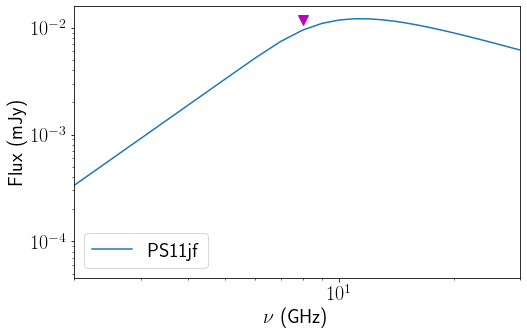

In [18]:
#PS11jf

#Synchrotron model of the fluxes
import numpy as np
plt.rc('text', usetex=True)

t =1338.751950078
t_p = 1338.751950078 #days
nu =np.arange(1, 100, dtype=float)
nu_p = 10 #GHz
F_nup = 0.0118  #mjansky 2.72E-05
m = 0.88 #using stAandard model
p = 3.0 #using standard model
a = (2*m)+0.5
b = (p+5-(6*m))/2

F_nu = F_nup*1.582*(t/t_p)**a*(nu/nu_p)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p)**(-(p+4)/2)))

print(F_nu)                  

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(8,5))
#plt.ylim(0.0001400,0.01570)
plt.xlim(2, 30)
plt.xscale('log')
plt.yscale('log')
ax=plt.subplot(111)
plt.plot(8,0.0118, 'mv', markersize=10) 
plt.plot(nu,F_nu, label ='PS11jf')
plt.xlabel(r'$\nu$ (GHz)', fontsize=20) #Log$_{10}$ t$_{rest}$(days)($\u03BD$ /5 GHz)', fontsize=14)
plt.ylabel('Flux (mJy)', fontsize=20) #Log$_{10}$ Luminosity (erg $s^{-1}$ $Hz^{-1}$)', fontsize =14)
plt.legend(frameon=True, framealpha=0.1, loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='lower left') #, bbox_to_anchor=(1, 0.5))
#plt.show()
plt.savefig('synPS11jf.pdf')

In [19]:
#PS11jf

#Radius at time t_p in centimeters
alpha = 1  #fraction of charged particles and magnetic field (epsilon_e/epsilon_b)
f =  0.5   # filling factor (fraction of the emiting region)
D =   1458.5   # in Mpc distance to the SN

R = 4.0e14*(alpha)**(-1/19)*(f/0.5)**(-1/19)*(F_nup)**(9/19)*(D)**(18/19)*(nu_p/5)**(-1)

# Magnetic field flux
B = 1.1*(alpha)**(-4/19)*(f/0.5)**(-4/19)*(F_nup)**(-2/19)*(D)**(-4/19)*(nu_p/5)

#Internal energy of the emitting material
epsilon_b = 0.1
E = (1/epsilon_b)*((B**2)/(8* 3.142))*((4*3.142*f*R**3)/3)

#expansion velocity in km/s
v = (R/t)*1.1574e-10

#pre-explosion mass-loss in 1e-5 solar mass per year
v_w = 1000  #wind speed in km/s
M = 1.0*(alpha)**(-8/19)*epsilon_b*(f)**(-8/19)*(F_nup)**(-4/19)*(D)**(-4/19)*(nu_p/5)*(t_p/10)*(v_w/1000)

print (R)
print (B)
print(E)
print(v)
print(M)


2.427146489028702e+16
0.757350479278497
6.834402138994308e+48
2098.3568660633123
19.693077791067783


[5.40294112e-05 3.05636504e-04 8.42235168e-04 1.72894116e-03
 3.02029904e-03 4.75231494e-03 6.78967840e-03 8.67881956e-03
 1.00369198e-02 1.08001590e-02 1.10899738e-02 1.10604428e-02
 1.08362788e-02 1.05035461e-02 1.01172906e-02 9.71119206e-03
 9.30515286e-03 8.91047514e-03 8.53318964e-03 8.17613994e-03
 7.84027142e-03 7.52542404e-03 7.23081799e-03 6.95534991e-03
 6.69777218e-03 6.45679979e-03 6.23117248e-03 6.01968917e-03
 5.82122542e-03 5.63474050e-03 5.45927827e-03 5.29396450e-03
 5.13800220e-03 4.99066608e-03 4.85129662e-03 4.71929422e-03
 4.59411364e-03 4.47525871e-03 4.36227755e-03 4.25475821e-03
 4.15232466e-03 4.05463326e-03 3.96136953e-03 3.87224531e-03
 3.78699618e-03 3.70537915e-03 3.62717067e-03 3.55216471e-03
 3.48017121e-03 3.41101455e-03 3.34453228e-03 3.28057391e-03
 3.21899986e-03 3.15968051e-03 3.10249535e-03 3.04733220e-03
 2.99408652e-03 2.94266078e-03 2.89296389e-03 2.84491066e-03
 2.79842138e-03 2.75342137e-03 2.70984058e-03 2.66761326e-03
 2.62667763e-03 2.586975

/usr/lib/python3/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


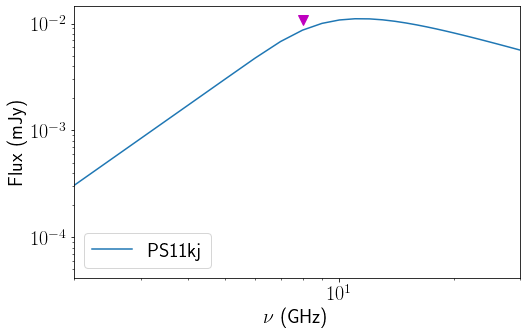

In [20]:
#PS11kj

#Synchrotron model of the fluxes
import numpy as np
plt.rc('text', usetex=True)

t = 1170.95
t_p = 1170.95 #days
nu =np.arange(1, 100, dtype=float)
nu_p = 10 #GHz
F_nup = 0.0108 #mjansky 2.72E-05
m = 0.88 #using stAandard model
p = 3.0 #using standard model
a = (2*m)+0.5
b = (p+5-(6*m))/2

F_nu = F_nup*1.582*(t/t_p)**a*(nu/nu_p)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p)**(-(p+4)/2)))

print(F_nu)                  

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(8,5))
#plt.ylim(0.0001400,0.01570)
plt.xlim(2, 30)
plt.xscale('log')
plt.yscale('log')
ax=plt.subplot(111)
plt.plot(8, 0.0108, 'mv', markersize=10) 
plt.plot(nu,F_nu, label ='PS11kj')
plt.xlabel(r'$\nu$ (GHz)', fontsize=20) #Log$_{10}$ t$_{rest}$(days)($\u03BD$ /5 GHz)', fontsize=14)
plt.ylabel('Flux (mJy)', fontsize=20) #Log$_{10}$ Luminosity (erg $s^{-1}$ $Hz^{-1}$)', fontsize =14)
plt.legend(frameon=True, framealpha=0.1, loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='lower left')# bbox_to_anchor=(1, 0.5))
#plt.show()
plt.savefig('synPS11kj.pdf')

In [21]:
#PS11kj

#Radius at time t_p in centimeters
alpha = 1  #fraction of charged particles and magnetic field (epsilon_e/epsilon_b)
f =  0.5   # filling factor (fraction of the emiting region)
D =    2193.4  # in Mpc distance to the SN

R = 4.0e14*(alpha)**(-1/19)*(f/0.5)**(-1/19)*(F_nup)**(9/19)*(D)**(18/19)*(nu_p/5)**(-1)

# Magnetic field flux
B = 1.1*(alpha)**(-4/19)*(f/0.5)**(-4/19)*(F_nup)**(-2/19)*(D)**(-4/19)*(nu_p/5)

#Internal energy of the emitting material
epsilon_b = 0.1
E = (1/epsilon_b)*((B**2)/(8* 3.142))*((4*3.142*f*R**3)/3)

#expansion velocity in km/s
v = (R/t)*1.1574e-10

#pre-explosion mass-loss in 1e-5 solar mass per year
v_w = 1000  #wind speed in km/s
M = 1.0*(alpha)**(-8/19)*epsilon_b*(f)**(-8/19)*(F_nup)**(-4/19)*(D)**(-4/19)*(nu_p/5)*(t_p/10)*(v_w/1000)

print (R)
print (B)
print(E)
print(v)
print(M)


3.4258110957359844e+16
0.7015158328370082
1.648860611052672e+49
3386.168292587069
16.104255072136215


[8.20446614e-05 4.64114692e-04 1.27894970e-03 2.62542917e-03
 4.58638003e-03 7.21647825e-03 1.03102524e-02 1.31789482e-02
 1.52412486e-02 1.64002415e-02 1.68403306e-02 1.67954872e-02
 1.64550900e-02 1.59498293e-02 1.53632932e-02 1.47466250e-02
 1.41300469e-02 1.35307215e-02 1.29578065e-02 1.24156199e-02
 1.19055973e-02 1.14274958e-02 1.09801310e-02 1.05618276e-02
 1.01706911e-02 9.80477005e-03 9.46215080e-03 9.14100948e-03
 8.83963860e-03 8.55645780e-03 8.29001516e-03 8.03898313e-03
 7.80215149e-03 7.57841886e-03 7.36678375e-03 7.16633567e-03
 6.97624664e-03 6.79576322e-03 6.62419925e-03 6.46092913e-03
 6.30538189e-03 6.15703569e-03 6.01541299e-03 5.88007622e-03
 5.75062383e-03 5.62668686e-03 5.50792583e-03 5.39402789e-03
 5.28470443e-03 5.17968877e-03 5.07873421e-03 4.98161224e-03
 4.88811090e-03 4.79803336e-03 4.71119664e-03 4.62743038e-03
 4.54657583e-03 4.46848489e-03 4.39301923e-03 4.32004952e-03
 4.24945469e-03 4.18112134e-03 4.11494310e-03 4.05082013e-03
 3.98865862e-03 3.928370

/usr/lib/python3/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


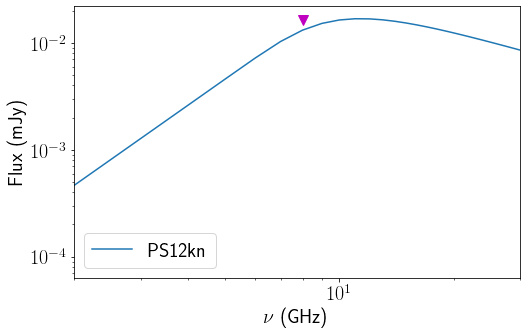

In [22]:
#PS12kn

#Synchrotron model of the fluxes
import numpy as np
plt.rc('text', usetex=True)

t = 907.163041412084 
t_p = 907.163041412084 #days
nu =np.arange(1, 100, dtype=float)
nu_p = 10 #GHz
F_nup = 0.0164  #mjansky 2.72E-05
m = 0.88 #using stAandard model
p = 3.0 #using standard model
a = (2*m)+0.5
b = (p+5-(6*m))/2

F_nu = F_nup*1.582*(t/t_p)**a*(nu/nu_p)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p)**(-(p+4)/2)))

print(F_nu)                  

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(8,5))
#plt.ylim(0.0001400,0.01570)
plt.xlim(2, 30)
plt.xscale('log')
plt.yscale('log')
ax=plt.subplot(111)
plt.plot(8,0.0164, 'mv', markersize=10) 
plt.plot(nu,F_nu, label ='PS12kn')
plt.xlabel(r'$\nu$ (GHz)', fontsize=20) #Log$_{10}$ t$_{rest}$(days)($\u03BD$ /5 GHz)', fontsize=14)
plt.ylabel('Flux (mJy)', fontsize=20) #Log$_{10}$ Luminosity (erg $s^{-1}$ $Hz^{-1}$)', fontsize =14)
plt.legend(frameon=True, framealpha=0.1, loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='lower left')#, bbox_to_anchor=(1, 0.5))
#plt.show()
plt.savefig('synPS12kn.pdf')

In [23]:
#PS12kn

#Radius at time t_p in centimeters
alpha = 1  #fraction of charged particles and magnetic field (epsilon_e/epsilon_b)
f =  0.5   # filling factor (fraction of the emiting region)
D =  2678.3   # in Mpc distance to the SN

R = 4.0e14*(alpha)**(-1/19)*(f/0.5)**(-1/19)*(F_nup)**(9/19)*(D)**(18/19)*(nu_p/5)**(-1)

# Magnetic field flux
B = 1.1*(alpha)**(-4/19)*(f/0.5)**(-4/19)*(F_nup)**(-2/19)*(D)**(-4/19)*(nu_p/5)

#Internal energy of the emitting material
epsilon_b = 0.1
E = (1/epsilon_b)*((B**2)/(8* 3.142))*((4*3.142*f*R**3)/3)

#expansion velocity in km/s
v = (R/t)*1.1574e-10

#pre-explosion mass-loss in 1e-5 solar mass per year
v_w = 1000  #wind speed in km/s
M = 1.0*(alpha)**(-8/19)*epsilon_b*(f)**(-8/19)*(F_nup)**(-4/19)*(D)**(-4/19)*(nu_p/5)*(t_p/10)*(v_w/1000)

print (R)
print (B)
print(E)
print(v)
print(M)


5.045164036048345e+16
0.6436937343994084
4.434076598839553e+49
6436.850476440245
10.955509777288695


[5.15280496e-05 2.91486666e-04 8.03242799e-04 1.64889759e-03
 2.88047038e-03 4.53230036e-03 6.47534143e-03 8.27702235e-03
 9.57224763e-03 1.03001517e-02 1.05765491e-02 1.05483852e-02
 1.03345992e-02 1.00172708e-02 9.64889754e-03 9.26159984e-03
 8.87435875e-03 8.49795314e-03 8.13813457e-03 7.79761494e-03
 7.47729589e-03 7.17702478e-03 6.89605789e-03 6.63334297e-03
 6.38769013e-03 6.15787387e-03 5.94269227e-03 5.74099985e-03
 5.55172424e-03 5.37387288e-03 5.20653391e-03 5.04887355e-03
 4.90013173e-03 4.75961672e-03 4.62669955e-03 4.50080838e-03
 4.38142320e-03 4.26807080e-03 4.16032026e-03 4.05777866e-03
 3.96008741e-03 3.86691876e-03 3.77797279e-03 3.69297470e-03
 3.61167228e-03 3.53383382e-03 3.45924610e-03 3.38771264e-03
 3.31905217e-03 3.25309721e-03 3.18969283e-03 3.12869549e-03
 3.06997209e-03 3.01339900e-03 2.95886130e-03 2.90625200e-03
 2.85547140e-03 2.80642649e-03 2.75903037e-03 2.71320183e-03
 2.66886484e-03 2.62594816e-03 2.58438500e-03 2.54411265e-03
 2.50507218e-03 2.467208

/usr/lib/python3/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


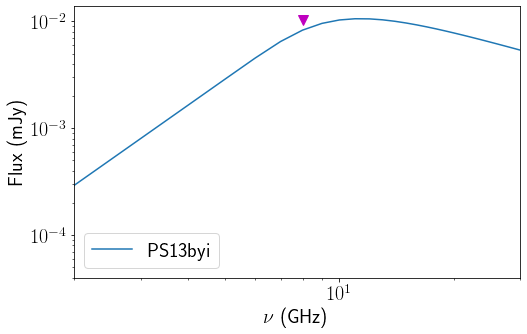

In [24]:
#PS13byi

#Synchrotron model of the fluxes
import numpy as np
plt.rc('text', usetex=True)

t =510.88991082045 
t_p = 510.88991082045 #days
nu =np.arange(1, 100, dtype=float)
nu_p = 10 #GHz
F_nup = 0.0103 #mjansky 2.72E-05
m = 0.88 #using stAandard model
p = 3.0 #using standard model
a = (2*m)+0.5
b = (p+5-(6*m))/2

F_nu = F_nup*1.582*(t/t_p)**a*(nu/nu_p)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p)**(-(p+4)/2)))

print(F_nu)                  

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(8,5))
#plt.ylim(0.0001400,0.01570)
plt.xlim(2, 30)
plt.xscale('log')
plt.yscale('log')
ax=plt.subplot(111)
plt.plot(8,0.0103, 'mv', markersize=10) 
plt.plot(nu,F_nu, label ='PS13byi')
plt.xlabel(r'$\nu$ (GHz)', fontsize=20) #Log$_{10}$ t$_{rest}$(days)($\u03BD$ /5 GHz)', fontsize=14)
plt.ylabel('Flux (mJy)', fontsize=20) #Log$_{10}$ Luminosity (erg $s^{-1}$ $Hz^{-1}$)', fontsize =14)
plt.legend(frameon=True, framealpha=0.1, loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='lower left')# bbox_to_anchor=(1, 0.5))
#plt.show()
plt.savefig('synPS13byi.pdf')

In [25]:
#PS13byi

#Radius at time t_p in centimeters
alpha = 1  #fraction of charged particles and magnetic field (epsilon_e/epsilon_b)
f =  0.5   # filling factor (fraction of the emiting region)
D =  4176.1   # in Mpc distance to the SN

R = 4.0e14*(alpha)**(-1/19)*(f/0.5)**(-1/19)*(F_nup)**(9/19)*(D)**(18/19)*(nu_p/5)**(-1)

# Magnetic field flux
B = 1.1*(alpha)**(-4/19)*(f/0.5)**(-4/19)*(F_nup)**(-2/19)*(D)**(-4/19)*(nu_p/5)

#Internal energy of the emitting material
epsilon_b = 0.1
E = (1/epsilon_b)*((B**2)/(8* 3.142))*((4*3.142*f*R**3)/3)

#expansion velocity in km/s
v = (R/t)*1.1574e-10

#pre-explosion mass-loss in 1e-5 solar mass per year
v_w = 1000  #wind speed in km/s
M = 1.0*(alpha)**(-8/19)*epsilon_b*(f)**(-8/19)*(F_nup)**(-4/19)*(D)**(-4/19)*(nu_p/5)*(t_p/10)*(v_w/1000)

print (R)
print (B)
print(E)
print(v)
print(M)


6.165188589872019e+16
0.6156447128202579
7.401473014371388e+49
13966.980209999972
6.197111297684444


[0.00010556 0.00059712 0.00164548 0.00337784 0.00590077 0.00928462
 0.01326502 0.01695584 0.01960917 0.02110031 0.02166652 0.02160883
 0.02117088 0.02052082 0.01976619 0.01897279 0.01817951 0.01740843
 0.01667132 0.01597375 0.01531757 0.01470245 0.01412688 0.01358869
 0.01308546 0.01261467 0.01217386 0.01176069 0.01137295 0.01100861
 0.01066581 0.01034284 0.01003813 0.00975028 0.009478   0.0092201
 0.00897554 0.00874333 0.0085226  0.00831254 0.00811241 0.00792155
 0.00773934 0.00756522 0.00739867 0.00723921 0.00708642 0.00693988
 0.00679922 0.00666411 0.00653423 0.00640927 0.00628897 0.00617308
 0.00606136 0.00595358 0.00584956 0.00574909 0.00565199 0.00555811
 0.00546729 0.00537937 0.00529423 0.00521173 0.00513175 0.00505418
 0.00497892 0.00490586 0.00483491 0.00476597 0.00469897 0.00463383
 0.00457046 0.00450879 0.00444877 0.00439032 0.00433338 0.0042779
 0.00422382 0.00417108 0.00411965 0.00406947 0.00402049 0.00397268
 0.00392599 0.00388038 0.00383582 0.00379227 0.00374969 0.003708

/usr/lib/python3/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


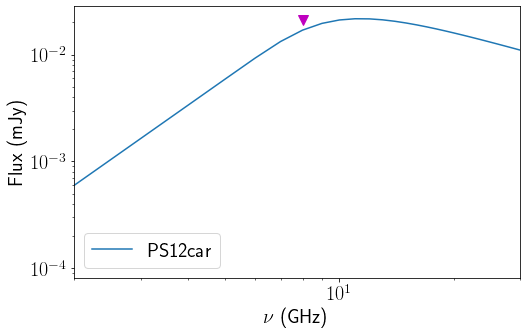

In [26]:
#PS12car

#Synchrotron model of the fluxes
import numpy as np
plt.rc('text', usetex=True)

t =656.602916666664 
t_p = 656.602916666664 #days
nu =np.arange(1, 100, dtype=float)
nu_p = 10 #GHz
F_nup = 0.0211  #mjansky 2.72E-05
m = 0.88 #using stAandard model
p = 3.0 #using standard model
a = (2*m)+0.5
b = (p+5-(6*m))/2

F_nu = F_nup*1.582*(t/t_p)**a*(nu/nu_p)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p)**(-(p+4)/2)))

print(F_nu)                  

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(8,5))
#plt.ylim(0.0001400,0.01570)
plt.xlim(2, 30)
plt.xscale('log')
plt.yscale('log')
ax=plt.subplot(111)
plt.plot(8,0.0211, 'mv', markersize=10) 
plt.plot(nu,F_nu, label ='PS12car')
plt.xlabel(r'$\nu$ (GHz)', fontsize=20) #Log$_{10}$ t$_{rest}$(days)($\u03BD$ /5 GHz)', fontsize=14)
plt.ylabel('Flux (mJy)', fontsize=20) #Log$_{10}$ Luminosity (erg $s^{-1}$ $Hz^{-1}$)', fontsize =14)
plt.legend(frameon=True, framealpha=0.1, loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='lower left')# bbox_to_anchor=(1, 0.5))
#plt.show()
plt.savefig('synPS12car.pdf')

In [27]:
#PS12car

#Radius at time t_p in centimeters
alpha = 1  #fraction of charged particles and magnetic field (epsilon_e/epsilon_b)
f =  0.5   # filling factor (fraction of the emiting region)
D =  4161.1   # in Mpc distance to the SN

R = 4.0e14*(alpha)**(-1/19)*(f/0.5)**(-1/19)*(F_nup)**(9/19)*(D)**(18/19)*(nu_p/5)**(-1)

# Magnetic field flux
B = 1.1*(alpha)**(-4/19)*(f/0.5)**(-4/19)*(F_nup)**(-2/19)*(D)**(-4/19)*(nu_p/5)

#Internal energy of the emitting material
epsilon_b = 0.1
E = (1/epsilon_b)*((B**2)/(8* 3.142))*((4*3.142*f*R**3)/3)

#expansion velocity in km/s
v = (R/t)*1.1574e-10

#pre-explosion mass-loss in 1e-5 solar mass per year
v_w = 1000  #wind speed in km/s
M = 1.0*(alpha)**(-8/19)*epsilon_b*(f)**(-8/19)*(F_nup)**(-4/19)*(D)**(-4/19)*(nu_p/5)*(t_p/10)*(v_w/1000)

print (R)
print (B)
print(E)
print(v)
print(M)


8.629637773965946e+16
0.5713147580780533
1.748023793391361e+50
15211.541871140882
6.853719994481917


[4.41240191e-05 2.49603145e-04 6.87825387e-04 1.41196861e-03
 2.46657755e-03 3.88105720e-03 5.54490402e-03 7.08770264e-03
 8.19681787e-03 8.82012987e-03 9.05681192e-03 9.03269494e-03
 8.84962767e-03 8.57789598e-03 8.26245401e-03 7.93080685e-03
 7.59920817e-03 7.27688803e-03 6.96877154e-03 6.67718095e-03
 6.40288833e-03 6.14576297e-03 5.90516802e-03 5.68020242e-03
 5.46984728e-03 5.27305316e-03 5.08879086e-03 4.91607949e-03
 4.75400076e-03 4.60170474e-03 4.45841059e-03 4.32340434e-03
 4.19603513e-03 4.07571063e-03 3.96189224e-03 3.85409028e-03
 3.75185947e-03 3.65479461e-03 3.56252667e-03 3.47471920e-03
 3.39106514e-03 3.31128383e-03 3.23511845e-03 3.16233367e-03
 3.09271355e-03 3.02605964e-03 2.96218938e-03 2.90093451e-03
 2.84213982e-03 2.78566189e-03 2.73136803e-03 2.67913536e-03
 2.62884988e-03 2.58040575e-03 2.53370453e-03 2.48865463e-03
 2.44517066e-03 2.40317297e-03 2.36258717e-03 2.32334370e-03
 2.28537746e-03 2.24862745e-03 2.21303647e-03 2.17855083e-03
 2.14512006e-03 2.112696

/usr/lib/python3/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


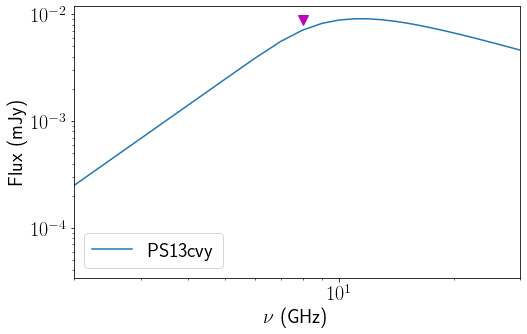

In [28]:
#PS13cvy

#Synchrotron model of the fluxes
import numpy as np
plt.rc('text', usetex=True)

t =445.840280898879
t_p =  445.840280898879 #days
nu =np.arange(1, 100, dtype=float)
nu_p = 10 #GHz
F_nup = 0.00882 #mjansky 2.72E-05
m = 0.88 #using stAandard model
p = 3.0 #using standard model
a = (2*m)+0.5
b = (p+5-(6*m))/2

F_nu = F_nup*1.582*(t/t_p)**a*(nu/nu_p)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p)**(-(p+4)/2)))

print(F_nu)                  

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(8,5))
#plt.ylim(0.0001400,0.01570)
plt.xlim(2, 30)
plt.xscale('log')
plt.yscale('log')
ax=plt.subplot(111)
plt.plot(8,0.00882, 'mv', markersize=10) 
plt.plot(nu,F_nu, label ='PS13cvy')
plt.xlabel(r'$\nu$ (GHz)', fontsize=20) #Log$_{10}$ t$_{rest}$(days)($\u03BD$ /5 GHz)', fontsize=14)
plt.ylabel('Flux (mJy)', fontsize=20) #Log$_{10}$ Luminosity (erg $s^{-1}$ $Hz^{-1}$)', fontsize =14)
plt.legend(frameon=True, framealpha=0.1, loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='lower left')#, bbox_to_anchor=(1, 0.5))
#plt.show()
plt.savefig('synPS13cvy.pdf')

In [29]:
#PS13cvy

#Radius at time t_p in centimeters
alpha = 1  #fraction of charged particles and magnetic field (epsilon_e/epsilon_b)
f =  0.5   # filling factor (fraction of the emiting region)
D =  4926.3    # in Mpc distance to the SN

R = 4.0e14*(alpha)**(-1/19)*(f/0.5)**(-1/19)*(F_nup)**(9/19)*(D)**(18/19)*(nu_p/5)**(-1)

# Magnetic field flux
B = 1.1*(alpha)**(-4/19)*(f/0.5)**(-4/19)*(F_nup)**(-2/19)*(D)**(-4/19)*(nu_p/5)

#Internal energy of the emitting material
epsilon_b = 0.1
E = (1/epsilon_b)*((B**2)/(8* 3.142))*((4*3.142*f*R**3)/3)

#expansion velocity in km/s
v = (R/t)*1.1574e-10

#pre-explosion mass-loss in 1e-5 solar mass per year
v_w = 1000  #wind speed in km/s
M = 1.0*(alpha)**(-8/19)*epsilon_b*(f)**(-8/19)*(F_nup)**(-4/19)*(D)**(-4/19)*(nu_p/5)*(t_p/10)*(v_w/1000)

print (R)
print (B)
print(E)
print(v)
print(M)


6.698978088729457e+16
0.6043886970390766
9.151179906674969e+49
17390.526545209184
5.396583347300322


[8.15443891e-05 4.61284724e-04 1.27115123e-03 2.60942045e-03
 4.55841430e-03 7.17247533e-03 1.02473850e-02 1.30985888e-02
 1.51483142e-02 1.63002400e-02 1.67376456e-02 1.66930757e-02
 1.63547541e-02 1.58525742e-02 1.52696146e-02 1.46567065e-02
 1.40438881e-02 1.34482171e-02 1.28787955e-02 1.23399149e-02
 1.18330022e-02 1.13578159e-02 1.09131790e-02 1.04974262e-02
 1.01086747e-02 9.74498487e-03 9.40445476e-03 9.08527161e-03
 8.78573836e-03 8.50428427e-03 8.23946628e-03 7.98996494e-03
 7.75457739e-03 7.53220899e-03 7.32186434e-03 7.12263851e-03
 6.93370855e-03 6.75432564e-03 6.58380779e-03 6.42153322e-03
 6.26693444e-03 6.11949279e-03 5.97873365e-03 5.84422209e-03
 5.71555905e-03 5.59237780e-03 5.47434091e-03 5.36113748e-03
 5.25248062e-03 5.14810530e-03 5.04776632e-03 4.95123655e-03
 4.85830534e-03 4.76877706e-03 4.68246983e-03 4.59921434e-03
 4.51885281e-03 4.44123803e-03 4.36623253e-03 4.29370775e-03
 4.22354338e-03 4.15562670e-03 4.08985199e-03 4.02612001e-03
 3.96433753e-03 3.904416

/usr/lib/python3/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


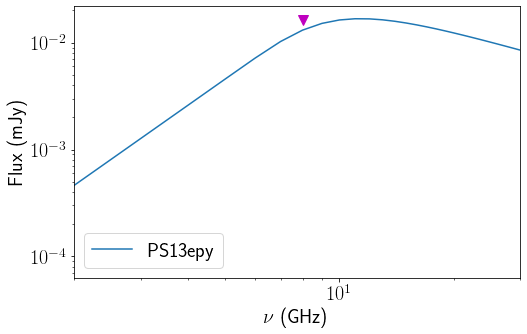

In [30]:
#PS13epy

#Synchrotron model of the fluxes
import numpy as np
plt.rc('text', usetex=True)

t = 529.994590417312 
t_p = 529.994590417312 #days
nu =np.arange(1, 100, dtype=float)
nu_p = 10 #GHz
F_nup = 0.0163 #mjansky 2.72E-05
m = 0.88 #using stAandard model
p = 3.0 #using standard model
a = (2*m)+0.5
b = (p+5-(6*m))/2

F_nu = F_nup*1.582*(t/t_p)**a*(nu/nu_p)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p)**(-(p+4)/2)))

print(F_nu)                  

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(8,5))
#plt.ylim(0.0001400,0.01570)
plt.xlim(2, 30)
plt.xscale('log')
plt.yscale('log')
ax=plt.subplot(111)
plt.plot(8,0.0163, 'mv', markersize=10) 
plt.plot(nu,F_nu, label ='PS13epy')
plt.xlabel(r'$\nu$ (GHz)', fontsize=20) #Log$_{10}$ t$_{rest}$(days)($\u03BD$ /5 GHz)', fontsize=14)
plt.ylabel('Flux (mJy)', fontsize=20) #Log$_{10}$ Luminosity (erg $s^{-1}$ $Hz^{-1}$)', fontsize =14)
plt.legend(frameon=True, framealpha=0.1, loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='lower left')#, bbox_to_anchor=(1, 0.5))
#plt.show()
plt.savefig('synPS13epy.pdf')

In [31]:
#PS13epy

#Radius at time t_p in centimeters
alpha = 1  #fraction of charged particles and magnetic field (epsilon_e/epsilon_b)
f =  0.5   # filling factor (fraction of the emiting region)
D =  1530.3   # in Mpc distance to the SN

R = 4.0e14*(alpha)**(-1/19)*(f/0.5)**(-1/19)*(F_nup)**(9/19)*(D)**(18/19)*(nu_p/5)**(-1)

# Magnetic field flux
B = 1.1*(alpha)**(-4/19)*(f/0.5)**(-4/19)*(F_nup)**(-2/19)*(D)**(-4/19)*(nu_p/5)

#Internal energy of the emitting material
epsilon_b = 0.1
E = (1/epsilon_b)*((B**2)/(8* 3.142))*((4*3.142*f*R**3)/3)

#expansion velocity in km/s
v = (R/t)*1.1574e-10

#pre-explosion mass-loss in 1e-5 solar mass per year
v_w = 1000  #wind speed in km/s
M = 1.0*(alpha)**(-8/19)*epsilon_b*(f)**(-8/19)*(F_nup)**(-4/19)*(D)**(-4/19)*(nu_p/5)*(t_p/10)*(v_w/1000)

print (R)
print (B)
print(E)
print(v)
print(M)


2.9602490528349172e+16
0.7246598164740452
1.135198649508366e+49
6464.5796687347065
7.21029745732153


[0.00010406 0.00058863 0.00162208 0.00332981 0.00581687 0.00915261
 0.01307642 0.01671476 0.01933036 0.02080031 0.02135847 0.02130159
 0.02086987 0.02022905 0.01948515 0.01870304 0.01792104 0.01716092
 0.01643429 0.01574664 0.01509978 0.01449341 0.01392602 0.01339549
 0.01289941 0.01243532 0.01200078 0.01159348 0.01121125 0.01085209
 0.01051417 0.01019578 0.00989541 0.00961165 0.00934324 0.00908901
 0.00884792 0.00861902 0.00840142 0.00819435 0.00799707 0.00780892
 0.0076293  0.00745766 0.00729347 0.00713629 0.00698566 0.00684121
 0.00670255 0.00656936 0.00644132 0.00631814 0.00619956 0.00608531
 0.00597518 0.00586894 0.00576639 0.00566735 0.00557163 0.00547909
 0.00538955 0.00530289 0.00521895 0.00513763 0.00505879 0.00498232
 0.00490813 0.00483611 0.00476617 0.00469821 0.00463216 0.00456794
 0.00450547 0.00444469 0.00438552 0.0043279  0.00427177 0.00421708
 0.00416376 0.00411178 0.00406108 0.00401161 0.00396333 0.00391619
 0.00387017 0.00382521 0.00378128 0.00373835 0.00369638 0.0036

/usr/lib/python3/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


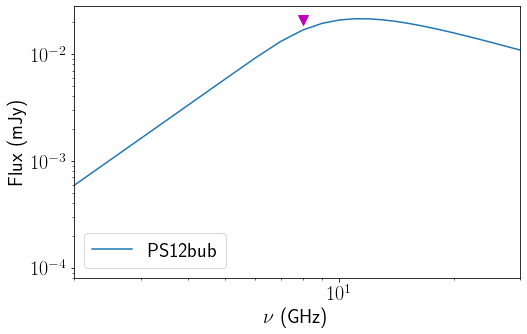

In [32]:
#PS12bub

#Synchrotron model of the fluxes
import numpy as np
plt.rc('text', usetex=True)

t =1057.25358490566
t_p = 1057.25358490566 #days
nu =np.arange(1, 100, dtype=float)
nu_p = 10 #GHz
F_nup = 0.0208 #mjansky 2.72E-05
m = 0.88 #using stAandard model
p = 3.0 #using standard model
a = (2*m)+0.5
b = (p+5-(6*m))/2

F_nu = F_nup*1.582*(t/t_p)**a*(nu/nu_p)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p)**(-(p+4)/2)))

print(F_nu)                  

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(8,5))
#plt.ylim(0.0001400,0.01570)
plt.xlim(2, 30)
plt.xscale('log')
plt.yscale('log')
ax=plt.subplot(111)
plt.plot(8,0.0208, 'mv', markersize=10) 
plt.plot(nu,F_nu, label ='PS12bub')
plt.xlabel(r'$\nu$ (GHz)', fontsize=20) #Log$_{10}$ t$_{rest}$(days)($\u03BD$ /5 GHz)', fontsize=14)
plt.ylabel('Flux (mJy)', fontsize=20) #Log$_{10}$ Luminosity (erg $s^{-1}$ $Hz^{-1}$)', fontsize =14)
plt.legend(frameon=True, framealpha=0.1, loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='lower left')#, bbox_to_anchor=(1, 0.5))
#plt.show()
plt.savefig('synPS12bub.pdf')

In [33]:
#PS12bub

#Radius at time t_p in centimeters
alpha = 1  #fraction of charged particles and magnetic field (epsilon_e/epsilon_b)
f =  0.5   # filling factor (fraction of the emiting region)
D =  1718.8  # in Mpc distance to the SN

R = 4.0e14*(alpha)**(-1/19)*(f/0.5)**(-1/19)*(F_nup)**(9/19)*(D)**(18/19)*(nu_p/5)**(-1)

# Magnetic field flux
B = 1.1*(alpha)**(-4/19)*(f/0.5)**(-4/19)*(F_nup)**(-2/19)*(D)**(-4/19)*(nu_p/5)

#Internal energy of the emitting material
epsilon_b = 0.1
E = (1/epsilon_b)*((B**2)/(8* 3.142))*((4*3.142*f*R**3)/3)

#expansion velocity in km/s
v = (R/t)*1.1574e-10

#pre-explosion mass-loss in 1e-5 solar mass per year
v_w = 1000  #wind speed in km/s
M = 1.0*(alpha)**(-8/19)*epsilon_b*(f)**(-8/19)*(F_nup)**(-4/19)*(D)**(-4/19)*(nu_p/5)*(t_p/10)*(v_w/1000)

print (R)
print (B)
print(E)
print(v)
print(M)


3.709142180205662e+16
0.6892369833230143
2.0201161625610483e+49
4060.4838996626336
13.333694204773513


[0.00011556 0.00065372 0.00180145 0.00369801 0.00646008 0.01016467
 0.01452237 0.01856303 0.02146786 0.02310034 0.02372022 0.02365706
 0.0231776  0.02246592 0.02163976 0.02077116 0.01990269 0.01905852
 0.01825154 0.01748785 0.01676947 0.01609605 0.01546592 0.01487672
 0.01432579 0.01381038 0.01332779 0.01287545 0.01245095 0.01205208
 0.01167679 0.0113232  0.01098962 0.01067448 0.01037638 0.01009405
 0.0098263  0.00957208 0.00933043 0.00910046 0.00888136 0.00867241
 0.00847293 0.0082823  0.00809996 0.00792539 0.00775812 0.00759769
 0.0074437  0.00729578 0.00715358 0.00701678 0.00688508 0.00675821
 0.00663589 0.0065179  0.00640402 0.00629402 0.00618773 0.00608495
 0.00598551 0.00588926 0.00579605 0.00570573 0.00561817 0.00553325
 0.00545086 0.00537087 0.00529319 0.00521772 0.00514437 0.00507305
 0.00500367 0.00493617 0.00487045 0.00480646 0.00474413 0.00468339
 0.00462418 0.00456645 0.00451014 0.0044552  0.00440158 0.00434923
 0.00429812 0.00424819 0.0041994  0.00415172 0.00410511 0.0040

/usr/lib/python3/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


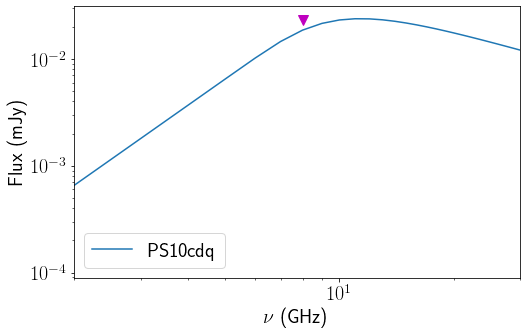

In [34]:
#PS10cdq

#Synchrotron model of the fluxes
import numpy as np
plt.rc('text', usetex=True)

t =1287.55458515284
t_p = 1287.55458515284 #days
nu =np.arange(1, 100, dtype=float)
nu_p = 10 #GHz
F_nup = 0.0231  #mjansky 2.72E-05
m = 0.88 #using stAandard model
p = 3.0 #using standard model
a = (2*m)+0.5
b = (p+5-(6*m))/2

F_nu = F_nup*1.582*(t/t_p)**a*(nu/nu_p)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p)**(-(p+4)/2)))

print(F_nu)                  

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(8,5))
#plt.ylim(0.0001400,0.01570)
plt.xlim(2, 30)
plt.xscale('log')
plt.yscale('log')
ax=plt.subplot(111)
plt.plot(8,0.0231, 'mv', markersize=10) 
plt.plot(nu,F_nu, label ='PS10cdq')
plt.xlabel(r'$\nu$ (GHz)', fontsize=20) #Log$_{10}$ t$_{rest}$(days)($\u03BD$ /5 GHz)', fontsize=14)
plt.ylabel('Flux (mJy)', fontsize=20) #Log$_{10}$ Luminosity (erg $s^{-1}$ $Hz^{-1}$)', fontsize =14)
plt.legend(frameon=True, framealpha=0.1, loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='lower left')#, bbox_to_anchor=(1, 0.5))
#plt.show()
plt.savefig('synPS10cdq.pdf')

In [35]:
#PS10cdq

#Radius at time t_p in centimeters
alpha = 1  #fraction of charged particles and magnetic field (epsilon_e/epsilon_b)
f =  0.5   # filling factor (fraction of the emiting region)
D =   2026.0   # in Mpc distance to the SN

R = 4.0e14*(alpha)**(-1/19)*(f/0.5)**(-1/19)*(F_nup)**(9/19)*(D)**(18/19)*(nu_p/5)**(-1)

# Magnetic field flux
B = 1.1*(alpha)**(-4/19)*(f/0.5)**(-4/19)*(F_nup)**(-2/19)*(D)**(-4/19)*(nu_p/5)

#Internal energy of the emitting material
epsilon_b = 0.1
E = (1/epsilon_b)*((B**2)/(8* 3.142))*((4*3.142*f*R**3)/3)

#expansion velocity in km/s
v = (R/t)*1.1574e-10

#pre-explosion mass-loss in 1e-5 solar mass per year
v_w = 1000  #wind speed in km/s
M = 1.0*(alpha)**(-8/19)*epsilon_b*(f)**(-8/19)*(F_nup)**(-4/19)*(D)**(-4/19)*(nu_p/5)*(t_p/10)*(v_w/1000)

print (R)
print (B)
print(E)
print(v)
print(M)


4.555170261123833e+16
0.658475214137363
3.415163197543158e+49
4094.703339974429
15.343104366867584


[5.80315898e-05 3.28276245e-04 9.04622958e-04 1.85701087e-03
 3.24402490e-03 5.10433827e-03 7.29261754e-03 9.32169508e-03
 1.07803954e-02 1.16001708e-02 1.19114533e-02 1.18797348e-02
 1.16389661e-02 1.12815865e-02 1.08667196e-02 1.04305396e-02
 9.99442344e-03 9.57051033e-03 9.16527776e-03 8.78177993e-03
 8.42103227e-03 8.08286286e-03 7.76643413e-03 7.47056101e-03
 7.19390345e-03 6.93508126e-03 6.69274081e-03 6.46559207e-03
 6.25242730e-03 6.05212869e-03 5.86366926e-03 5.68611002e-03
 5.51859495e-03 5.36034505e-03 5.21065192e-03 5.06887157e-03
 4.93441836e-03 4.80675935e-03 4.68540922e-03 4.56992548e-03
 4.45990427e-03 4.35497646e-03 4.25480431e-03 4.15907830e-03
 4.06751441e-03 3.97985168e-03 3.89584997e-03 3.81528802e-03
 3.73796167e-03 3.66368230e-03 3.59227542e-03 3.52357939e-03
 3.45744429e-03 3.39373091e-03 3.33230982e-03 3.27306051e-03
 3.21587071e-03 3.16063566e-03 3.10725751e-03 3.05564478e-03
 3.00571185e-03 2.95737851e-03 2.91056951e-03 2.86521424e-03
 2.82124634e-03 2.778603

/usr/lib/python3/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


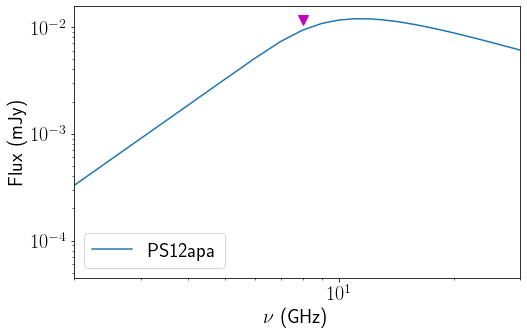

In [36]:
#PS12apa

#Synchrotron model of the fluxes
import numpy as np
plt.rc('text', usetex=True)

t =807.329842931936
t_p = 807.329842931936 #days
nu =np.arange(1, 100, dtype=float)
nu_p = 10 #GHz
F_nup = 0.0116 #mjansky 2.72E-05
m = 0.88 #using stAandard model
p = 3.0 #using standard model
a = (2*m)+0.5
b = (p+5-(6*m))/2

F_nu = F_nup*1.582*(t/t_p)**a*(nu/nu_p)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p)**(-(p+4)/2)))

print(F_nu)                  

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(8,5))
#plt.ylim(0.0001400,0.01570)
plt.xlim(2, 30)
plt.xscale('log')
plt.yscale('log')
ax=plt.subplot(111)
plt.plot(8, 0.0116, 'mv', markersize=10) 
plt.plot(nu,F_nu, label ='PS12apa')
plt.xlabel(r'$\nu$ (GHz)', fontsize=20) #Log$_{10}$ t$_{rest}$(days)($\u03BD$ /5 GHz)', fontsize=14)
plt.ylabel('Flux (mJy)', fontsize=20) #Log$_{10}$ Luminosity (erg $s^{-1}$ $Hz^{-1}$)', fontsize =14)
plt.legend(frameon=True, framealpha=0.1, loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='lower left')# bbox_to_anchor=(1, 0.5))
#plt.show()
plt.savefig('synPS12apa.pdf')

In [37]:
#PS12apa

#Radius at time t_p in centimeters
alpha = 1  #fraction of charged particles and magnetic field (epsilon_e/epsilon_b)
f =  0.5   # filling factor (fraction of the emiting region)
D =  3057.6  # in Mpc distance to the SN

R = 4.0e14*(alpha)**(-1/19)*(f/0.5)**(-1/19)*(F_nup)**(9/19)*(D)**(18/19)*(nu_p/5)**(-1)

# Magnetic field flux
B = 1.1*(alpha)**(-4/19)*(f/0.5)**(-4/19)*(F_nup)**(-2/19)*(D)**(-4/19)*(nu_p/5)

#Internal energy of the emitting material
epsilon_b = 0.1
E = (1/epsilon_b)*((B**2)/(8* 3.142))*((4*3.142*f*R**3)/3)

#expansion velocity in km/s
v = (R/t)*1.1574e-10

#pre-explosion mass-loss in 1e-5 solar mass per year
v_w = 1000  #wind speed in km/s
M = 1.0*(alpha)**(-8/19)*epsilon_b*(f)**(-8/19)*(F_nup)**(-4/19)*(D)**(-4/19)*(nu_p/5)*(t_p/10)*(v_w/1000)

print (R)
print (B)
print(E)
print(v)
print(M)


4.854381322991401e+16
0.6492315156052223
4.0180894961003736e+49
6959.312841484947
10.198790037501162


[0.00016509 0.00093389 0.0025735  0.00528288 0.00922869 0.01452096
 0.02074624 0.02651862 0.03066837 0.03300049 0.03388603 0.0337958
 0.03311085 0.03209417 0.03091394 0.02967309 0.02843241 0.02722645
 0.02607364 0.02498265 0.02395638 0.02299435 0.02209417 0.02125246
 0.02046541 0.01972911 0.01903969 0.01839349 0.01778708 0.01721726
 0.01668113 0.016176   0.01569945 0.01524926 0.01482341 0.01442007
 0.01403757 0.0136744  0.01332918 0.01300065 0.01268766 0.01238916
 0.01210418 0.01183186 0.01157138 0.01132199 0.01108302 0.01085384
 0.01063386 0.01042254 0.0102194  0.01002398 0.00983583 0.00965458
 0.00947985 0.00931129 0.0091486  0.00899146 0.00883961 0.00869278
 0.00855073 0.00841323 0.00828007 0.00815104 0.00802596 0.00790465
 0.00778694 0.00767267 0.0075617  0.00745389 0.0073491  0.00724721
 0.00714811 0.00705167 0.00695779 0.00686637 0.00677732 0.00669055
 0.00660597 0.0065235  0.00644306 0.00636457 0.00628797 0.00621319
 0.00614017 0.00606884 0.00599915 0.00593103 0.00586445 0.00579

/usr/lib/python3/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


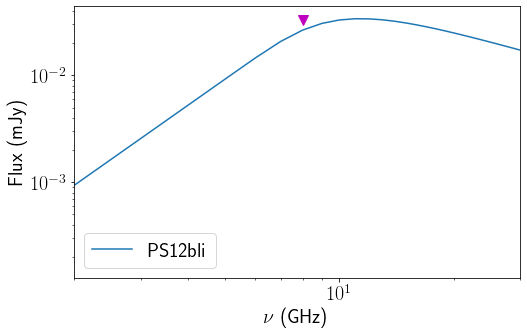

In [38]:
#PS12bli

#Synchrotron model of the fluxes
import numpy as np
plt.rc('text', usetex=True)

t =947.656013456685
t_p = 947.656013456685 #days
nu =np.arange(1, 100, dtype=float)
nu_p = 10 #GHz
F_nup = 0.033 #mjansky 2.72E-05
m = 0.88 #using stAandard model
p = 3.0 #using standard model
a = (2*m)+0.5
b = (p+5-(6*m))/2

F_nu = F_nup*1.582*(t/t_p)**a*(nu/nu_p)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p)**(-(p+4)/2)))

print(F_nu)                  

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(8,5))
#plt.ylim(0.0001400,0.01570)
plt.xlim(2, 30)
plt.xscale('log')
plt.yscale('log')
ax=plt.subplot(111)
plt.plot(8,0.033, 'mv', markersize=10) 
plt.plot(nu,F_nu, label ='PS12bli')
plt.xlabel(r'$\nu$ (GHz)', fontsize=20) #Log$_{10}$ t$_{rest}$(days)($\u03BD$ /5 GHz)', fontsize=14)
plt.ylabel('Flux (mJy)', fontsize=20) #Log$_{10}$ Luminosity (erg $s^{-1}$ $Hz^{-1}$)', fontsize =14)
plt.legend(frameon=True, framealpha=0.1, loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='lower left')#, bbox_to_anchor=(1, 0.5))
#plt.show()
plt.savefig('synPS12bli.pdf')

In [39]:
#PS12bli

#Radius at time t_p in centimeters
alpha = 1  #fraction of charged particles and magnetic field (epsilon_e/epsilon_b)
f =  0.5   # filling factor (fraction of the emiting region)
D =   927.3   # in Mpc distance to the SN

R = 4.0e14*(alpha)**(-1/19)*(f/0.5)**(-1/19)*(F_nup)**(9/19)*(D)**(18/19)*(nu_p/5)**(-1)

# Magnetic field flux
B = 1.1*(alpha)**(-4/19)*(f/0.5)**(-4/19)*(F_nup)**(-2/19)*(D)**(-4/19)*(nu_p/5)

#Internal energy of the emitting material
epsilon_b = 0.1
E = (1/epsilon_b)*((B**2)/(8* 3.142))*((4*3.142*f*R**3)/3)

#expansion velocity in km/s
v = (R/t)*1.1574e-10

#pre-explosion mass-loss in 1e-5 solar mass per year
v_w = 1000  #wind speed in km/s
M = 1.0*(alpha)**(-8/19)*epsilon_b*(f)**(-8/19)*(F_nup)**(-4/19)*(D)**(-4/19)*(nu_p/5)*(t_p/10)*(v_w/1000)

print (R)
print (B)
print(E)
print(v)
print(M)


2.5723153734182816e+16
0.7476367354223808
7.928164611211422e+48
3141.6439835955302
12.349348397681254


[9.60522866e-05 5.43353785e-04 1.49730696e-03 3.07367317e-03
 5.36942052e-03 8.44855990e-03 1.20705394e-02 1.54290125e-02
 1.78434131e-02 1.92002827e-02 1.97155089e-02 1.96630094e-02
 1.92644956e-02 1.86729708e-02 1.79862944e-02 1.72643414e-02
 1.65424940e-02 1.58408447e-02 1.51701149e-02 1.45353599e-02
 1.39382603e-02 1.33785316e-02 1.28547875e-02 1.23650665e-02
 1.19071505e-02 1.14787552e-02 1.10776400e-02 1.07016696e-02
 1.03488452e-02 1.00173164e-02 9.70538360e-03 9.41149244e-03
 9.13422613e-03 8.87229525e-03 8.62452732e-03 8.38985640e-03
 8.16731314e-03 7.95601548e-03 7.75516009e-03 7.56401460e-03
 7.38191051e-03 7.20823691e-03 7.04243472e-03 6.88399167e-03
 6.73243765e-03 6.58734072e-03 6.44830341e-03 6.31495948e-03
 6.18697104e-03 6.06402587e-03 5.94583517e-03 5.83213140e-03
 5.72266642e-03 5.61720979e-03 5.51554728e-03 5.41747946e-03
 5.32282048e-03 5.23139695e-03 5.14304691e-03 5.05761895e-03
 4.97497135e-03 4.89497133e-03 4.81749436e-03 4.74242357e-03
 4.66964912e-03 4.599067

/usr/lib/python3/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


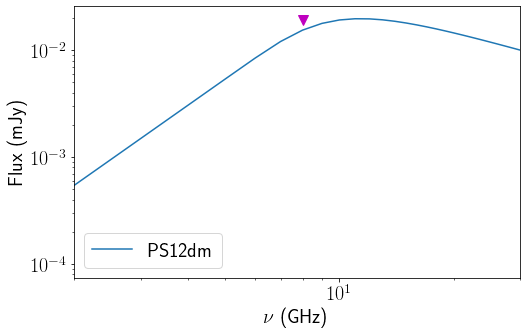

In [40]:
#PS12dm

#Synchrotron model of the fluxes
import numpy as np
plt.rc('text', usetex=True)

t =1132.31215653622
t_p = 1132.31215653622 #days
nu =np.arange(1, 100, dtype=float)
nu_p = 10 #GHz
F_nup = 0.0192 #mjansky 2.72E-05
m = 0.88 #using stAandard model
p = 3.0 #using standard model
a = (2*m)+0.5
b = (p+5-(6*m))/2

F_nu = F_nup*1.582*(t/t_p)**a*(nu/nu_p)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p)**(-(p+4)/2)))

print(F_nu)                  

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(8,5))
#plt.ylim(0.0001400,0.01570)
plt.xlim(2, 30)
plt.xscale('log')
plt.yscale('log')
ax=plt.subplot(111)
plt.plot(8,0.0192, 'mv', markersize=10) 
plt.plot(nu,F_nu, label ='PS12dm')
plt.xlabel(r'$\nu$ (GHz)', fontsize=20) #Log$_{10}$ t$_{rest}$(days)($\u03BD$ /5 GHz)', fontsize=14)
plt.ylabel('Flux (mJy)', fontsize=20) #Log$_{10}$ Luminosity (erg $s^{-1}$ $Hz^{-1}$)', fontsize =14)
plt.legend(frameon=True, framealpha=0.1, loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='lower left')#, bbox_to_anchor=(1, 0.5))
#plt.show()
plt.savefig('synPS12dm.pdf')

In [41]:
#PS12dm

#Radius at time t_p in centimeters
alpha = 1  #fraction of charged particles and magnetic field (epsilon_e/epsilon_b)
f =  0.5   # filling factor (fraction of the emiting region)
D =   993.3   # in Mpc distance to the SN

R = 4.0e14*(alpha)**(-1/19)*(f/0.5)**(-1/19)*(F_nup)**(9/19)*(D)**(18/19)*(nu_p/5)**(-1)

# Magnetic field flux
B = 1.1*(alpha)**(-4/19)*(f/0.5)**(-4/19)*(F_nup)**(-2/19)*(D)**(-4/19)*(nu_p/5)

#Internal energy of the emitting material
epsilon_b = 0.1
E = (1/epsilon_b)*((B**2)/(8* 3.142))*((4*3.142*f*R**3)/3)

#expansion velocity in km/s
v = (R/t)*1.1574e-10

#pre-explosion mass-loss in 1e-5 solar mass per year
v_w = 1000  #wind speed in km/s
M = 1.0*(alpha)**(-8/19)*epsilon_b*(f)**(-8/19)*(F_nup)**(-4/19)*(D)**(-4/19)*(nu_p/5)*(t_p/10)*(v_w/1000)

print (R)
print (B)
print(E)
print(v)
print(M)


2.12420415204503e+16
0.7801237728546242
4.8610998182102706e+48
2171.2686483007606
16.300150072679227


[0.00011256 0.00063674 0.00175466 0.00360196 0.00629229 0.00990066
 0.01414516 0.01808087 0.02091025 0.02250033 0.02310411 0.02304259
 0.02257558 0.02188239 0.02107769 0.02023165 0.01938574 0.01856349
 0.01777748 0.01703362 0.0163339  0.01567797 0.0150642  0.01449031
 0.01395369 0.01345167 0.01298161 0.01254102 0.01212755 0.01173904
 0.0113735  0.01102909 0.01070417 0.01039722 0.01010687 0.00983186
 0.00957107 0.00932346 0.00908808 0.00886408 0.00865068 0.00844715
 0.00825285 0.00806718 0.00788958 0.00771954 0.00755661 0.00740034
 0.00725036 0.00710628 0.00696778 0.00683453 0.00670625 0.00658267
 0.00646353 0.00634861 0.00623768 0.00613054 0.00602701 0.0059269
 0.00583004 0.00573629 0.0056455  0.00555753 0.00547225 0.00538953
 0.00530928 0.00523137 0.00515571 0.0050822  0.00501075 0.00494128
 0.00487371 0.00480795 0.00474395 0.00468162 0.0046209  0.00456174
 0.00450407 0.00444784 0.00439299 0.00433948 0.00428725 0.00423627
 0.00418648 0.00413784 0.00409033 0.00404389 0.00399849 0.00395

/usr/lib/python3/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


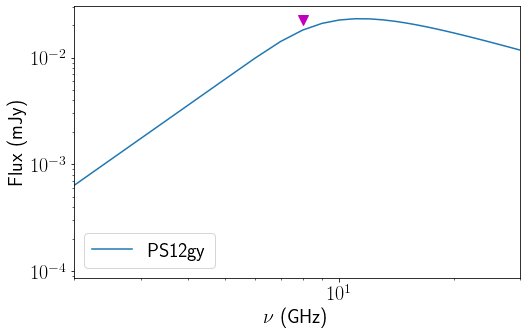

In [42]:
#PS12gy

#Synchrotron model of the fluxes
import numpy as np
plt.rc('text', usetex=True)

t = 1031.40308171206
t_p = 1031.40308171206 #days
nu =np.arange(1, 100, dtype=float)
nu_p = 10 #GHz
F_nup = 0.0225  #mjansky 2.72E-05
m = 0.88 #using stAandard model
p = 3.0 #using standard model
a = (2*m)+0.5
b = (p+5-(6*m))/2

F_nu = F_nup*1.582*(t/t_p)**a*(nu/nu_p)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p)**(-(p+4)/2)))

print(F_nu)                  

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(8,5))
#plt.ylim(0.0001400,0.01570)
plt.xlim(2, 30)
plt.xscale('log')
plt.yscale('log')
ax=plt.subplot(111)
plt.plot(8,0.0225, 'mv', markersize=10) 
plt.plot(nu,F_nu, label ='PS12gy')
plt.xlabel(r'$\nu$ (GHz)', fontsize=20) #Log$_{10}$ t$_{rest}$(days)($\u03BD$ /5 GHz)', fontsize=14)
plt.ylabel('Flux (mJy)', fontsize=20) #Log$_{10}$ Luminosity (erg $s^{-1}$ $Hz^{-1}$)', fontsize =14)
plt.legend(frameon=True, framealpha=0.1, loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='lower left')#, bbox_to_anchor=(1, 0.5))
#plt.show()
plt.savefig('synPS12gy.pdf')

In [43]:
#PS12gy

#Radius at time t_p in centimeters
alpha = 1  #fraction of charged particles and magnetic field (epsilon_e/epsilon_b)
f =  0.5   # filling factor (fraction of the emiting region)
D =  1476.4   # in Mpc distance to the SN

R = 4.0e14*(alpha)**(-1/19)*(f/0.5)**(-1/19)*(F_nup)**(9/19)*(D)**(18/19)*(nu_p/5)**(-1)

# Magnetic field flux
B = 1.1*(alpha)**(-4/19)*(f/0.5)**(-4/19)*(F_nup)**(-2/19)*(D)**(-4/19)*(nu_p/5)

#Internal energy of the emitting material
epsilon_b = 0.1
E = (1/epsilon_b)*((B**2)/(8* 3.142))*((4*3.142*f*R**3)/3)

#expansion velocity in km/s
v = (R/t)*1.1574e-10

#pre-explosion mass-loss in 1e-5 solar mass per year
v_w = 1000  #wind speed in km/s
M = 1.0*(alpha)**(-8/19)*epsilon_b*(f)**(-8/19)*(F_nup)**(-4/19)*(D)**(-4/19)*(nu_p/5)*(t_p/10)*(v_w/1000)

print (R)
print (B)
print(E)
print(v)
print(M)


3.333409714477161e+16
0.7057913034430254
1.537579038725117e+49
3740.621365152117
13.210400550130018


[0.00013808 0.00078107 0.00215238 0.00441841 0.00771854 0.0121448
 0.0173514  0.02217921 0.02564991 0.02760041 0.02834104 0.02826558
 0.02769271 0.0268424  0.0258553  0.02481749 0.02377984 0.02277121
 0.02180704 0.02089458 0.02003625 0.01923164 0.01847876 0.01777478
 0.01711653 0.01650071 0.01592411 0.01538365 0.01487646 0.01439989
 0.01395149 0.01352902 0.01313045 0.01275392 0.01239776 0.01206042
 0.01174051 0.01143677 0.01114804 0.01087327 0.0106115  0.01036184
 0.0101235  0.00989574 0.00967788 0.0094693  0.00926944 0.00907775
 0.00889377 0.00871704 0.00854714 0.00838369 0.00822633 0.00807474
 0.0079286  0.00778763 0.00765155 0.00752013 0.00739313 0.00727033
 0.00715152 0.00703652 0.00692515 0.00681723 0.00671262 0.00661116
 0.00651271 0.00641714 0.00632433 0.00623416 0.00614652 0.00606131
 0.00597842 0.00589776 0.00581924 0.00574278 0.00566831 0.00559573
 0.00552499 0.00545602 0.00538874 0.00532309 0.00525903 0.00519649
 0.00513541 0.00507576 0.00501747 0.0049605  0.00490481 0.00485

/usr/lib/python3/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


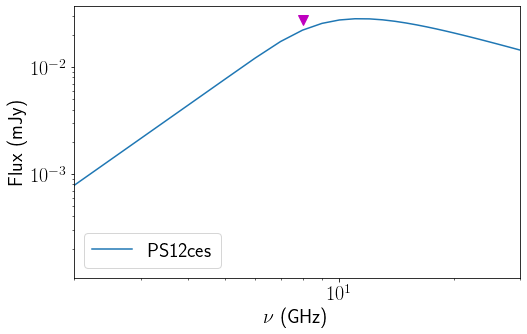

In [44]:
#PS12ces

#Synchrotron model of the fluxes
import numpy as np
plt.rc('text', usetex=True)

t =922.673512154231
t_p = 922.673512154231 #days
nu =np.arange(1, 100, dtype=float)
nu_p = 10 #GHz
F_nup = 0.0276  #mjansky 2.72E-05
m = 0.88 #using stAandard model
p = 3.0 #using standard model
a = (2*m)+0.5
b = (p+5-(6*m))/2

F_nu = F_nup*1.582*(t/t_p)**a*(nu/nu_p)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p)**(-(p+4)/2)))

print(F_nu)                  

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(8,5))
#plt.ylim(0.0001400,0.01570)
plt.xlim(2, 30)
plt.xscale('log')
plt.yscale('log')
ax=plt.subplot(111)
plt.plot(8, 0.0276, 'mv', markersize=10) 
plt.plot(nu,F_nu, label ='PS12ces')
plt.xlabel(r'$\nu$ (GHz)', fontsize=20) #Log$_{10}$ t$_{rest}$(days)($\u03BD$ /5 GHz)', fontsize=14)
plt.ylabel('Flux (mJy)', fontsize=20) #Log$_{10}$ Luminosity (erg $s^{-1}$ $Hz^{-1}$)', fontsize =14)
plt.legend(frameon=True, framealpha=0.1, loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='lower left')# bbox_to_anchor=(1, 0.5))
#plt.show()
plt.savefig('synPS12ces.pdf')

In [45]:
#PS12ces

#Radius at time t_p in centimeters
alpha = 1  #fraction of charged particles and magnetic field (epsilon_e/epsilon_b)
f =  0.5   # filling factor (fraction of the emiting region)
D =  949.2    # in Mpc distance to the SN

R = 4.0e14*(alpha)**(-1/19)*(f/0.5)**(-1/19)*(F_nup)**(9/19)*(D)**(18/19)*(nu_p/5)**(-1)

# Magnetic field flux
B = 1.1*(alpha)**(-4/19)*(f/0.5)**(-4/19)*(F_nup)**(-2/19)*(D)**(-4/19)*(nu_p/5)

#Internal energy of the emitting material
epsilon_b = 0.1
E = (1/epsilon_b)*((B**2)/(8* 3.142))*((4*3.142*f*R**3)/3)

#expansion velocity in km/s
v = (R/t)*1.1574e-10

#pre-explosion mass-loss in 1e-5 solar mass per year
v_w = 1000  #wind speed in km/s
M = 1.0*(alpha)**(-8/19)*epsilon_b*(f)**(-8/19)*(F_nup)**(-4/19)*(D)**(-4/19)*(nu_p/5)*(t_p/10)*(v_w/1000)

print (R)
print (B)
print(E)
print(v)
print(M)


2.4163950433679344e+16
0.7580980171190448
6.75730129935524e+48
3031.1216116568808
12.423530601018852


[4.25231477e-05 2.40547249e-04 6.62870271e-04 1.36074073e-03
 2.37708721e-03 3.74024787e-03 5.34372837e-03 6.83055243e-03
 7.89942765e-03 8.50012515e-03 8.72822011e-03 8.70497812e-03
 8.52855274e-03 8.26667980e-03 7.96268244e-03 7.64306783e-03
 7.32349994e-03 7.01287395e-03 6.71593629e-03 6.43492495e-03
 6.17058399e-03 5.92278744e-03 5.69092156e-03 5.47411798e-03
 5.27139477e-03 5.08174058e-03 4.90416352e-03 4.73771833e-03
 4.58152001e-03 4.43474947e-03 4.29665420e-03 4.16654613e-03
 4.04379803e-03 3.92783904e-03 3.81815011e-03 3.71425934e-03
 3.61573759e-03 3.52219435e-03 3.43327400e-03 3.34865229e-03
 3.26803330e-03 3.19114655e-03 3.11774454e-03 3.04760048e-03
 2.98050625e-03 2.91627063e-03 2.85471765e-03 2.79568519e-03
 2.73902364e-03 2.68459479e-03 2.63227078e-03 2.58193317e-03
 2.53347211e-03 2.48678558e-03 2.44177874e-03 2.39836330e-03
 2.35645698e-03 2.31598302e-03 2.27686972e-03 2.23905005e-03
 2.20246127e-03 2.16704460e-03 2.13274490e-03 2.09951044e-03
 2.06729258e-03 2.036045

/usr/lib/python3/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


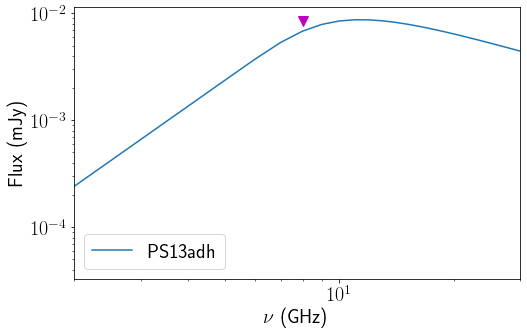

In [46]:
#PS13adh

#Synchrotron model of the fluxes
import numpy as np
plt.rc('text', usetex=True)

t =834.012304309588
t_p = 834.012304309588 #days
nu =np.arange(1, 100, dtype=float)
nu_p = 10 #GHz
F_nup = 0.0085 #mjansky 2.72E-05
m = 0.88 #using stAandard model
p = 3.0 #using standard model
a = (2*m)+0.5
b = (p+5-(6*m))/2

F_nu = F_nup*1.582*(t/t_p)**a*(nu/nu_p)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p)**(-(p+4)/2)))

print(F_nu)                  

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(8,5))
#plt.ylim(0.0001400,0.01570)
plt.xlim(2, 30)
plt.xscale('log')
plt.yscale('log')
ax=plt.subplot(111)
plt.plot(8,0.0085, 'mv', markersize=10) 
plt.plot(nu,F_nu, label ='PS13adh')
plt.xlabel(r'$\nu$ (GHz)', fontsize=20) #Log$_{10}$ t$_{rest}$(days)($\u03BD$ /5 GHz)', fontsize=14)
plt.ylabel('Flux (mJy)', fontsize=20) #Log$_{10}$ Luminosity (erg $s^{-1}$ $Hz^{-1}$)', fontsize =14)
plt.legend(frameon=True, framealpha=0.1, loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='lower left')#, bbox_to_anchor=(1, 0.5))
#plt.show()
plt.savefig('synPS13adh.pdf')

In [47]:
#PS13adh

#Radius at time t_p in centimeters
alpha = 1  #fraction of charged particles and magnetic field (epsilon_e/epsilon_b)
f =  0.5   # filling factor (fraction of the emiting region)
D =  650.7  # in Mpc distance to the SN

R = 4.0e14*(alpha)**(-1/19)*(f/0.5)**(-1/19)*(F_nup)**(9/19)*(D)**(18/19)*(nu_p/5)**(-1)

# Magnetic field flux
B = 1.1*(alpha)**(-4/19)*(f/0.5)**(-4/19)*(F_nup)**(-2/19)*(D)**(-4/19)*(nu_p/5)

#Internal energy of the emitting material
epsilon_b = 0.1
E = (1/epsilon_b)*((B**2)/(8* 3.142))*((4*3.142*f*R**3)/3)

#expansion velocity in km/s
v = (R/t)*1.1574e-10

#pre-explosion mass-loss in 1e-5 solar mass per year
v_w = 1000  #wind speed in km/s
M = 1.0*(alpha)**(-8/19)*epsilon_b*(f)**(-8/19)*(F_nup)**(-4/19)*(D)**(-4/19)*(nu_p/5)*(t_p/10)*(v_w/1000)

print (R)
print (B)
print(E)
print(v)
print(M)


9672451636163978.0
0.9291543986982623
6.510348378923506e+47
1342.2938085983692
15.580200217103798


[6.65362193e-05 3.76385695e-04 1.03719701e-03 2.12915902e-03
 3.71944234e-03 5.85238785e-03 8.36136321e-03 1.06878056e-02
 1.23602809e-02 1.33001958e-02 1.36570973e-02 1.36207305e-02
 1.33446766e-02 1.29349225e-02 1.24592560e-02 1.19591532e-02
 1.14591234e-02 1.09730851e-02 1.05084650e-02 1.00687649e-02
 9.65514906e-03 9.26742035e-03 8.90461845e-03 8.56538461e-03
 8.24818240e-03 7.95142937e-03 7.67357351e-03 7.41313573e-03
 7.16873130e-03 6.93907858e-03 6.72300010e-03 6.51941924e-03
 6.32735456e-03 6.14591285e-03 5.97428194e-03 5.81172344e-03
 5.65756587e-03 5.51119822e-03 5.37206402e-03 5.23965594e-03
 5.11351093e-03 4.99320577e-03 4.87835322e-03 4.76859840e-03
 4.66361567e-03 4.56310581e-03 4.46679351e-03 4.37442506e-03
 4.28576639e-03 4.20060126e-03 4.11872957e-03 4.03996602e-03
 3.96413871e-03 3.89108803e-03 3.82066557e-03 3.75273317e-03
 3.68716211e-03 3.62383226e-03 3.56263145e-03 3.50345479e-03
 3.44620411e-03 3.39078743e-03 3.33711849e-03 3.28511633e-03
 3.23470486e-03 3.185812

/usr/lib/python3/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


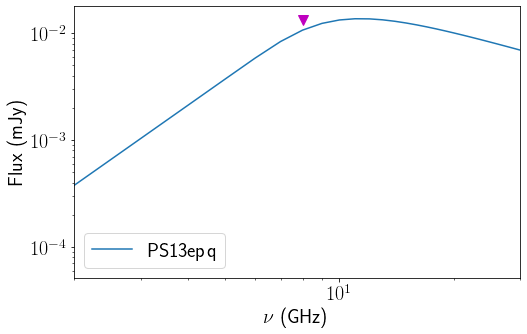

In [48]:
#PS13epq

#Synchrotron model of the fluxes
import numpy as np
plt.rc('text', usetex=True)

t =562.926249008722
t_p = 562.926249008722 #days
nu =np.arange(1, 100, dtype=float)
nu_p = 10 #GHz
F_nup = 0.0133 #mjansky 2.72E-05
m = 0.88 #using stAandard model
p = 3.0 #using standard model
a = (2*m)+0.5
b = (p+5-(6*m))/2

F_nu = F_nup*1.582*(t/t_p)**a*(nu/nu_p)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p)**(-(p+4)/2)))

print(F_nu)                  

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(8,5))
#plt.ylim(0.0001400,0.01570)
plt.xlim(2, 30)
plt.xscale('log')
plt.yscale('log')
ax=plt.subplot(111)
plt.plot(8, 0.0133, 'mv', markersize=10) 
plt.plot(nu,F_nu, label ='PS13epq')
plt.xlabel(r'$\nu$ (GHz)', fontsize=20) #Log$_{10}$ t$_{rest}$(days)($\u03BD$ /5 GHz)', fontsize=14)
plt.ylabel('Flux (mJy)', fontsize=20) #Log$_{10}$ Luminosity (erg $s^{-1}$ $Hz^{-1}$)', fontsize =14)
plt.legend(frameon=True, framealpha=0.1, loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='lower left')#, bbox_to_anchor=(1, 0.5))
#plt.show()
plt.savefig('synPS13epq.pdf')

In [49]:
#PS13epq

#Radius at time t_p in centimeters
alpha = 1  #fraction of charged particles and magnetic field (epsilon_e/epsilon_b)
f =  0.5   # filling factor (fraction of the emiting region)
D =  1334.7  # in Mpc distance to the SN

R = 4.0e14*(alpha)**(-1/19)*(f/0.5)**(-1/19)*(F_nup)**(9/19)*(D)**(18/19)*(nu_p/5)**(-1)

# Magnetic field flux
B = 1.1*(alpha)**(-4/19)*(f/0.5)**(-4/19)*(F_nup)**(-2/19)*(D)**(-4/19)*(nu_p/5)

#Internal energy of the emitting material
epsilon_b = 0.1
E = (1/epsilon_b)*((B**2)/(8* 3.142))*((4*3.142*f*R**3)/3)

#expansion velocity in km/s
v = (R/t)*1.1574e-10

#pre-explosion mass-loss in 1e-5 solar mass per year
v_w = 1000  #wind speed in km/s
M = 1.0*(alpha)**(-8/19)*epsilon_b*(f)**(-8/19)*(F_nup)**(-4/19)*(D)**(-4/19)*(nu_p/5)*(t_p/10)*(v_w/1000)

print (R)
print (B)
print(E)
print(v)
print(M)


2.3616629967266656e+16
0.7619675463540903
6.373022878029267e+48
4855.678265536151
8.226859152498523


[0.00011606 0.00065655 0.00180925 0.00371402 0.00648805 0.01020868
 0.01458524 0.01864339 0.02156079 0.02320034 0.02382291 0.02375947
 0.02327793 0.02256317 0.02173344 0.02086108 0.01998885 0.01914102
 0.01833056 0.01756356 0.01684206 0.01616573 0.01553287 0.01494112
 0.01438781 0.01387016 0.01338548 0.01293118 0.01250485 0.01210426
 0.01172734 0.01137222 0.01103719 0.01072069 0.0104213  0.01013774
 0.00986884 0.00961352 0.00937082 0.00913985 0.00891981 0.00870995
 0.00850961 0.00831816 0.00813503 0.0079597  0.0077917  0.00763058
 0.00747592 0.00732736 0.00718455 0.00704716 0.00691489 0.00678746
 0.00666462 0.00654612 0.00643174 0.00632127 0.00621452 0.00611129
 0.00601142 0.00591476 0.00582114 0.00573043 0.00564249 0.00555721
 0.00547445 0.00539412 0.00531611 0.00524031 0.00516664 0.00509501
 0.00502534 0.00495753 0.00489154 0.00482727 0.00476466 0.00470366
 0.0046442  0.00458622 0.00452966 0.00447449 0.00442063 0.00436806
 0.00431672 0.00426658 0.00421758 0.0041697  0.00412288 0.0040

/usr/lib/python3/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


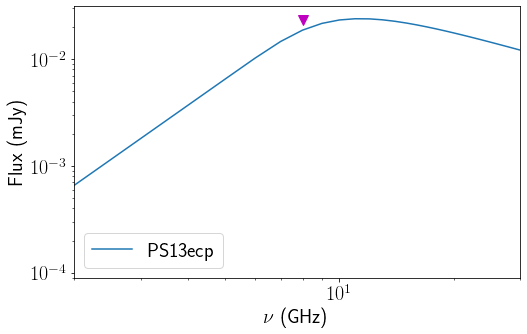

In [50]:
#PS13ecp

#Synchrotron model of the fluxes
import numpy as np
plt.rc('text', usetex=True)

t =618.078800675676
t_p = 618.078800675676 #days
nu =np.arange(1, 100, dtype=float)
nu_p = 10 #GHz
F_nup = 0.0232 #mjansky 2.72E-05
m = 0.88 #using stAandard model
p = 3.0 #using standard model
a = (2*m)+0.5
b = (p+5-(6*m))/2

F_nu = F_nup*1.582*(t/t_p)**a*(nu/nu_p)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p)**(-(p+4)/2)))

print(F_nu)                  

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(8,5))
#plt.ylim(0.0001400,0.01570)
plt.xlim(2, 30)
plt.xscale('log')
plt.yscale('log')
ax=plt.subplot(111)
plt.plot(8,0.0232, 'mv', markersize=10) 
plt.plot(nu,F_nu, label ='PS13ecp')
plt.xlabel(r'$\nu$ (GHz)', fontsize=20) #Log$_{10}$ t$_{rest}$(days)($\u03BD$ /5 GHz)', fontsize=14)
plt.ylabel('Flux (mJy)', fontsize=20) #Log$_{10}$ Luminosity (erg $s^{-1}$ $Hz^{-1}$)', fontsize =14)
plt.legend(frameon=True, framealpha=0.1, loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='lower left')#, bbox_to_anchor=(1, 0.5))
#plt.show()
plt.savefig('synPS13ecp.pdf')

In [51]:
#PS13ecp

#Radius at time t_p in centimeters
alpha = 1  #fraction of charged particles and magnetic field (epsilon_e/epsilon_b)
f =  0.5   # filling factor (fraction of the emiting region)
D =  900.0   # in Mpc distance to the SN

R = 4.0e14*(alpha)**(-1/19)*(f/0.5)**(-1/19)*(F_nup)**(9/19)*(D)**(18/19)*(nu_p/5)**(-1)

# Magnetic field flux
B = 1.1*(alpha)**(-4/19)*(f/0.5)**(-4/19)*(F_nup)**(-2/19)*(D)**(-4/19)*(nu_p/5)

#Internal energy of the emitting material
epsilon_b = 0.1
E = (1/epsilon_b)*((B**2)/(8* 3.142))*((4*3.142*f*R**3)/3)

#expansion velocity in km/s
v = (R/t)*1.1574e-10

#pre-explosion mass-loss in 1e-5 solar mass per year
v_w = 1000  #wind speed in km/s
M = 1.0*(alpha)**(-8/19)*epsilon_b*(f)**(-8/19)*(F_nup)**(-4/19)*(D)**(-4/19)*(nu_p/5)*(t_p/10)*(v_w/1000)

print (R)
print (B)
print(E)
print(v)
print(M)


2.1161357477575284e+16
0.7807837853369066
4.814053325046133e+48
3962.6266291241695
8.729418543404735


[0.00010756 0.00060844 0.00167667 0.00344187 0.00601263 0.00946063
 0.01351649 0.01727728 0.01998091 0.02150032 0.02207726 0.02201847
 0.02157222 0.02090984 0.0201409  0.01933247 0.01852415 0.01773845
 0.01698737 0.01627657 0.01560795 0.01498117 0.01439468 0.0138463
 0.01333353 0.01285381 0.01240465 0.01198364 0.01158855 0.01121731
 0.01086801 0.01053891 0.01022843 0.00993512 0.00965767 0.00939489
 0.00914569 0.00890908 0.00868416 0.00847012 0.0082662  0.00807172
 0.00788606 0.00770864 0.00753893 0.00737645 0.00722076 0.00707144
 0.00692812 0.00679045 0.0066581  0.00653077 0.00640819 0.0062901
 0.00617626 0.00606645 0.00596045 0.00585807 0.00575914 0.00566348
 0.00557093 0.00548135 0.00539459 0.00531053 0.00522903 0.00515
 0.00507331 0.00499886 0.00492657 0.00485632 0.00478805 0.00472167
 0.0046571  0.00459427 0.0045331  0.00447355 0.00441553 0.004359
 0.00430389 0.00425016 0.00419775 0.00414661 0.00409671 0.00404799
 0.00400041 0.00395394 0.00390853 0.00386416 0.00382078 0.00377836
 0

/usr/lib/python3/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


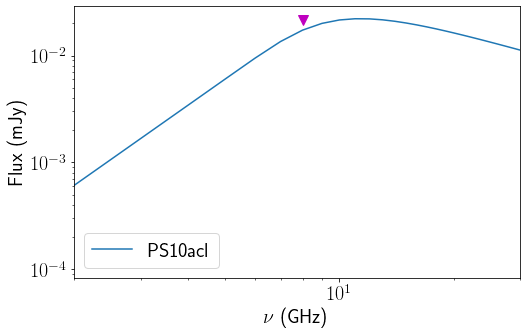

In [52]:
#PS10acl

#Synchrotron model of the fluxes
import numpy as np
plt.rc('text', usetex=True)

t =1488.23113582208
t_p = 1488.23113582208 #days
nu =np.arange(1, 100, dtype=float)
nu_p = 10 #GHz
F_nup = 0.0215  #mjansky 2.72E-05
m = 0.88 #using stAandard model
p = 3.0 #using standard model
a = (2*m)+0.5
b = (p+5-(6*m))/2

F_nu = F_nup*1.582*(t/t_p)**a*(nu/nu_p)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p)**(-(p+4)/2)))

print(F_nu)                  

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(8,5))
#plt.ylim(0.0001400,0.01570)
plt.xlim(2, 30)
plt.xscale('log')
plt.yscale('log')
ax=plt.subplot(111)
plt.plot(8, 0.0215, 'mv', markersize=10) 
plt.plot(nu,F_nu, label ='PS10acl')
plt.xlabel(r'$\nu$ (GHz)', fontsize=20) #Log$_{10}$ t$_{rest}$(days)($\u03BD$ /5 GHz)', fontsize=14)
plt.ylabel('Flux (mJy)', fontsize=20) #Log$_{10}$ Luminosity (erg $s^{-1}$ $Hz^{-1}$)', fontsize =14)
plt.legend(frameon=True, framealpha=0.1, loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='lower left')# bbox_to_anchor=(1, 0.5))
#plt.show()
plt.savefig('synPS10acl.pdf')

In [53]:
#PS10acl

#Radius at time t_p in centimeters
alpha = 1  #fraction of charged particles and magnetic field (epsilon_e/epsilon_b)
f =  0.5   # filling factor (fraction of the emiting region)
D =  1323.0  # in Mpc distance to the SN

R = 4.0e14*(alpha)**(-1/19)*(f/0.5)**(-1/19)*(F_nup)**(9/19)*(D)**(18/19)*(nu_p/5)**(-1)

# Magnetic field flux
B = 1.1*(alpha)**(-4/19)*(f/0.5)**(-4/19)*(F_nup)**(-2/19)*(D)**(-4/19)*(nu_p/5)

#Internal energy of the emitting material
epsilon_b = 0.1
E = (1/epsilon_b)*((B**2)/(8* 3.142))*((4*3.142*f*R**3)/3)

#expansion velocity in km/s
v = (R/t)*1.1574e-10

#pre-explosion mass-loss in 1e-5 solar mass per year
v_w = 1000  #wind speed in km/s
M = 1.0*(alpha)**(-8/19)*epsilon_b*(f)**(-8/19)*(F_nup)**(-4/19)*(D)**(-4/19)*(nu_p/5)*(t_p/10)*(v_w/1000)

print (R)
print (B)
print(E)
print(v)
print(M)


2.9403541691872972e+16
0.725746551688386
1.1158033231557606e+49
2286.7186645288884
19.694499465790255


[0.00015458 0.00087446 0.00240973 0.00494669 0.00864141 0.0135969
 0.01942602 0.02483107 0.02871674 0.03090045 0.03172965 0.03164516
 0.0310038  0.03005181 0.02894669 0.0277848  0.02662308 0.02549386
 0.0244144  0.02339284 0.02243189 0.02153107 0.02068817 0.01990003
 0.01916307 0.01847362 0.01782808 0.017223   0.01665517 0.01612162
 0.0156196  0.01514662 0.0147004  0.01427885 0.0138801  0.01350243
 0.01314427 0.01280421 0.01248096 0.01217334 0.01188026 0.01160076
 0.01133392 0.01107892 0.01083502 0.0106015  0.01037774 0.01016314
 0.00995716 0.00975929 0.00956908 0.00938609 0.00920992 0.0090402
 0.00887658 0.00871876 0.00856641 0.00841928 0.00827709 0.00813961
 0.00800659 0.00787784 0.00775315 0.00763234 0.00751522 0.00740162
 0.00729141 0.00718441 0.00708051 0.00697955 0.00688143 0.00678603
 0.00669323 0.00660292 0.00651502 0.00642942 0.00634604 0.00626479
 0.00618559 0.00610837 0.00603304 0.00595955 0.00588783 0.00581781
 0.00574943 0.00568264 0.00561738 0.0055536  0.00549126 0.005430

/usr/lib/python3/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


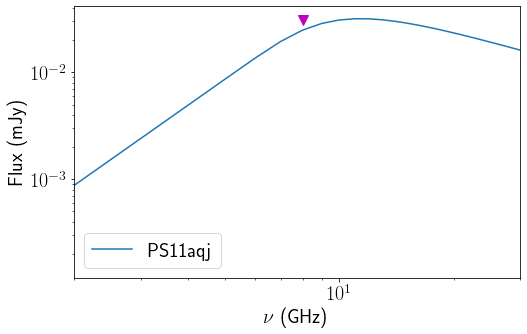

In [54]:
#PS11aqj

#Synchrotron model of the fluxes
import numpy as np
plt.rc('text', usetex=True)

t =1418.70356816102
t_p = 1418.70356816102 #days
nu =np.arange(1, 100, dtype=float)
nu_p = 10 #GHz
F_nup = 0.0309 #mjansky 2.72E-05
m = 0.88 #using stAandard model
p = 3.0 #using standard model
a = (2*m)+0.5
b = (p+5-(6*m))/2

F_nu = F_nup*1.582*(t/t_p)**a*(nu/nu_p)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p)**(-(p+4)/2)))

print(F_nu)                  

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(8,5))
#plt.ylim(0.0001400,0.01570)
plt.xlim(2, 30)
plt.xscale('log')
plt.yscale('log')
ax=plt.subplot(111)
plt.plot(8, 0.0309, 'mv', markersize=10) 
plt.plot(nu,F_nu, label ='PS11aqj')
plt.xlabel(r'$\nu$ (GHz)', fontsize=20) #Log$_{10}$ t$_{rest}$(days)($\u03BD$ /5 GHz)', fontsize=14)
plt.ylabel('Flux (mJy)', fontsize=20) #Log$_{10}$ Luminosity (erg $s^{-1}$ $Hz^{-1}$)', fontsize =14)
plt.legend(frameon=True, framealpha=0.1, loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='lower left')#, bbox_to_anchor=(1, 0.5))
#plt.show()
plt.savefig('synPS11aqj.pdf')

In [55]:
#PS11aqj

#Radius at time t_p in centimeters
alpha = 1  #fraction of charged particles and magnetic field (epsilon_e/epsilon_b)
f =  0.5   # filling factor (fraction of the emiting region)
D =  428.9  # in Mpc distance to the SN

R = 4.0e14*(alpha)**(-1/19)*(f/0.5)**(-1/19)*(F_nup)**(9/19)*(D)**(18/19)*(nu_p/5)**(-1)

# Magnetic field flux
B = 1.1*(alpha)**(-4/19)*(f/0.5)**(-4/19)*(F_nup)**(-2/19)*(D)**(-4/19)*(nu_p/5)

#Internal energy of the emitting material
epsilon_b = 0.1
E = (1/epsilon_b)*((B**2)/(8* 3.142))*((4*3.142*f*R**3)/3)

#expansion velocity in km/s
v = (R/t)*1.1574e-10

#pre-explosion mass-loss in 1e-5 solar mass per year
v_w = 1000  #wind speed in km/s
M = 1.0*(alpha)**(-8/19)*epsilon_b*(f)**(-8/19)*(F_nup)**(-4/19)*(D)**(-4/19)*(nu_p/5)*(t_p/10)*(v_w/1000)

print (R)
print (B)
print(E)
print(v)
print(M)


1.2010419073955142e+16
0.8855114875454172
1.1320917798912193e+48
979.8282987484502
22.049278668483836


[0.00020911 0.00118293 0.00325976 0.00669164 0.01168968 0.01839322
 0.02627857 0.03359025 0.0388466  0.04180062 0.04292231 0.04280801
 0.04194041 0.04065261 0.03915766 0.03758591 0.03601439 0.03448684
 0.0330266  0.03164469 0.03034475 0.02912618 0.02798594 0.02691978
 0.02592286 0.02499021 0.02411695 0.02329843 0.0225303  0.02180853
 0.02112943 0.0204896  0.01988597 0.01931573 0.01877631 0.01826542
 0.01778092 0.01732091 0.01688363 0.01646749 0.01607103 0.01569293
 0.01533197 0.01498702 0.01465708 0.01434119 0.01403849 0.01374819
 0.01346955 0.01320189 0.01294458 0.01269704 0.01245872 0.01222913
 0.01200781 0.0117943  0.01158822 0.01138919 0.01119684 0.01101086
 0.01083093 0.01065676 0.01048809 0.01032465 0.01016622 0.01001255
 0.00986345 0.00971872 0.00957816 0.0094416  0.00930887 0.00917981
 0.00905427 0.00893211 0.0088132  0.00869741 0.00858461 0.0084747
 0.00836756 0.0082631  0.0081612  0.00806179 0.00796476 0.00787004
 0.00777755 0.0076872  0.00759892 0.00751264 0.0074283  0.00734

/usr/lib/python3/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


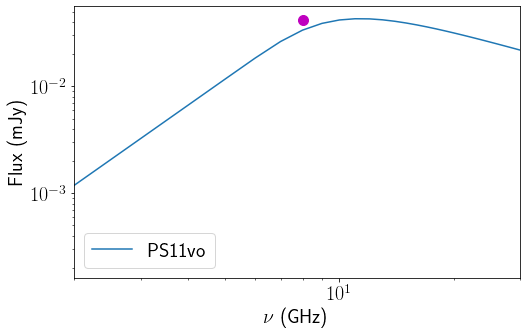

In [56]:
#PS1-11vo

#Synchrotron model of the fluxes
import numpy as np
plt.rc('text', usetex=True)

t =1430.32329749104
t_p = 1430.32329749104 #days
nu =np.arange(1, 100, dtype=float)
nu_p = 10 #GHz
F_nup = 0.0418  #mjansky 2.72E-05
m = 0.88 #using stAandard model
p = 3.0 #using standard model
a = (2*m)+0.5
b = (p+5-(6*m))/2

F_nu = F_nup*1.582*(t/t_p)**a*(nu/nu_p)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p)**(-(p+4)/2)))

print(F_nu)                  

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(8,5))
#plt.ylim(0.0001400,0.01570)
plt.xlim(2, 30)
plt.xscale('log')
plt.yscale('log')
ax=plt.subplot(111)
plt.plot(8,0.0418, 'mo', markersize=10) 
plt.plot(nu,F_nu, label ='PS11vo')
plt.xlabel(r'$\nu$ (GHz)', fontsize=20) #Log$_{10}$ t$_{rest}$(days)($\u03BD$ /5 GHz)', fontsize=14)
plt.ylabel('Flux (mJy)', fontsize=20) #Log$_{10}$ Luminosity (erg $s^{-1}$ $Hz^{-1}$)', fontsize =14)
plt.legend(frameon=True, framealpha=0.1, loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='lower left')#, bbox_to_anchor=(1, 0.5))
#plt.show()
plt.savefig('synPS11vo.pdf')

In [57]:
#PS1-11vo

#Radius at time t_p in centimeters
alpha = 1  #fraction of charged particles and magnetic field (epsilon_e/epsilon_b)
f =  0.5   # filling factor (fraction of the emiting region)
D =   543.4  # in Mpc distance to the SN

R = 4.0e14*(alpha)**(-1/19)*(f/0.5)**(-1/19)*(F_nup)**(9/19)*(D)**(18/19)*(nu_p/5)**(-1)

# Magnetic field flux
B = 1.1*(alpha)**(-4/19)*(f/0.5)**(-4/19)*(F_nup)**(-2/19)*(D)**(-4/19)*(nu_p/5)

#Internal energy of the emitting material
epsilon_b = 0.1
E = (1/epsilon_b)*((B**2)/(8* 3.142))*((4*3.142*f*R**3)/3)

#expansion velocity in km/s
v = (R/t)*1.1574e-10

#pre-explosion mass-loss in 1e-5 solar mass per year
v_w = 1000  #wind speed in km/s
M = 1.0*(alpha)**(-8/19)*epsilon_b*(f)**(-8/19)*(F_nup)**(-4/19)*(D)**(-4/19)*(nu_p/5)*(t_p/10)*(v_w/1000)

print (R)
print (B)
print(E)
print(v)
print(M)


1.7340792455061726e+16
0.8161074826183988
2.8941450575618537e+48
1403.1955728256723
19.846215272009854


/usr/lib/python3/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


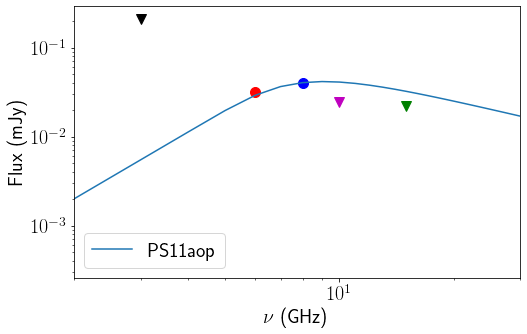

In [2]:
#PS1-11aop


#Synchrotron model of the fluxes
import numpy as np
plt.rc('text', usetex=True)

 #2161.50903119869
t_p = t = 1261.50903119869 #days 1690.01477832512
nu =np.arange(1, 100, dtype=float)
nu_p = 8 #GHz
F_nup = 0.0404 #mjansky 2.72E-05 0.0246#
m = 0.88 #using stAandard model
p = 3.0 #using standard model
a = (2*m)+0.5
b = (p+5-(6*m))/2

F_nu = F_nup*1.582*(t/t_p)**a*(nu/nu_p)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p)**(-(p+4)/2)))

#print(F_nu)                  

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(8,5))
#plt.ylim(0.0001400,0.01570)
plt.xlim(2, 30)
plt.xscale('log')
plt.yscale('log')
ax=plt.subplot(111)
plt.plot(8,0.0404, 'bo', markersize=10) 
plt.plot(6,0.0318, 'ro', markersize=10)
plt.plot(10,0.0246, 'mv', markersize=10)
plt.plot(3,0.211, 'kv', markersize=10)
plt.plot(15,0.0221, 'gv', markersize=10)

plt.plot(nu,F_nu, label ='PS11aop')
plt.xlabel(r'$\nu$ (GHz)', fontsize=20) #Log$_{10}$ t$_{rest}$(days)($\u03BD$ /5 GHz)', fontsize=14)
plt.ylabel('Flux (mJy)', fontsize=20) #Log$_{10}$ Luminosity (erg $s^{-1}$ $Hz^{-1}$)', fontsize =14)
plt.legend(frameon=True, framealpha=0.1, loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='lower left')#, bbox_to_anchor=(1, 0.5))
#plt.show()
plt.savefig('synPS11aop.pdf')

In [3]:
#PS1-11aop

#Radius at time t_p in centimeters
alpha = 1  #fraction of charged particles and magnetic field (epsilon_e/epsilon_b)
f =  0.5   # filling factor (fraction of the emiting region)
D =  1088.1  # in Mpc distance to the SN

R = 4.0e14*(alpha)**(-1/19)*(f/0.5)**(-1/19)*(F_nup)**(9/19)*(D)**(18/19)*(nu_p/5)**(-1)

# Magnetic field flux
B = 1.1*(alpha)**(-4/19)*(f/0.5)**(-4/19)*(F_nup)**(-2/19)*(D)**(-4/19)*(nu_p/5)

#Internal energy of the emitting material
epsilon_b = 0.1
E = (1/epsilon_b)*((B**2)/(8* 3.142))*((4*3.142*f*R**3)/3)

#expansion velocity in km/s
v = (R/t)*1.1574e-10

#pre-explosion mass-loss in 1e-5 solar mass per year
v_w = 1000  #wind speed in km/s
vw_cgs = 100 * 1e5 
M = 1.0*(alpha)**(-8/19)*epsilon_b*(f)**(-8/19)*(F_nup)**(-4/19)*(D)**(-4/19)*(nu_p/5)*(t_p/10)*(v_w/1000)
M_cgs =  M * 1e-5 * 6.307e+25
den = M_cgs/(4*3.142*R**2*vw_cgs)

print (R)
print (B)
print(E)
print(v)
print(M)
print(den)

4.117645952055539e+16
0.5661228304094349
1.864606089831026e+49
3777.8274328964867
12.185813256606835
3.606726191031983e-20
